# Freedom of Information Requests in the Region of Waterloo

*"The Waterloo Region strives to be open, transparent and accountable to citizens. Through a number of projects and initiatives, the Region is empowering citizens to become more engaged and to access government information."* [https://www.regionofwaterloo.ca/en/regional-government/open-government.aspx]

One of those initiatives is *Open Data*. With this, the Region shares its data for everyone to use and republish with few restrictions. The data is provided in machine-readable format. 

While searching the Region's Open Data Portal, one finds the *Freedom of Information Requests* (*FOIR*) data set. This data set spans 18 years. https://rowopendata-rmw.opendata.arcgis.com/

So let's find what this set holds and see if one can use machine learning to predict the outcome of a request based on the decisions made between 1999 and 2016.

## Importing, cleaning, and getting to know the data

First, let's import few must have libraries for such task:

* pandas - to be able to work work dataframes
* matplot and seaborn - to make plots
* numpy - for scientific computing


In [247]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns

Files are similarly named, e.g., *Freedom_of_Information_Requests__1999.csv*, except that they have different years, from 1999 to 2016. So let's add them to a pandas dataframe.

In [2]:
counter = 0
year_first = 1999
year_last = 2016
df = {}    # Dataframe of dataframes
for y in range(year_first, year_last+1):
    file = 'data/Freedom_of_Information_Requests__' + str(y) + '.csv'
    df[counter] = pd.read_csv(file, encoding='utf-8')
    counter += 1

In [3]:
# Number of files read and turned into dataframes
len(df)

18

Here is how the first few lines of the first file look like,

In [4]:
df[0].head(3)

Request_Number         Request_Type    Source  \
0           99001  General Information  Business   
1           99002  General Information  Business   
2           99003  General Information  Business   

                                  Summary_of_Request         Decision  \
0  Minutes of Service Delivery Subcommittee of ES...  Partly exempted   
1  Public Health inspection reports for the {loca...    All disclosed   
2  Public Health inspection records for {location...  Partly exempted   

   OBJECTID  
0         0  
1         1  
2         2

Let's find out if all the files have the same number of columns:

In [5]:
for y in range(0, len(df)):
    print(df[y].shape)

(27, 6)
(19, 6)
(25, 6)
(20, 6)
(24, 6)
(22, 6)
(22, 6)
(23, 6)
(24, 6)
(30, 6)
(39, 6)
(29, 6)
(43, 6)
(41, 6)
(33, 6)
(30, 6)
(43, 6)
(82, 6)


In [6]:
# Number of columns of the first file
df[0].shape[1]

6

While all the files have the same number of columns, it is possible that over the years, those columns would not be the same, that the structure of those files has changed. We need to verify that we can combine all those files into a single stacked dataframe.

In [7]:
# How does one get the name of the columns? Call df.columns.values
columnsNamesArr = df[0].columns.values
print(columnsNamesArr)
print(columnsNamesArr[5])

['Request_Number' 'Request_Type' 'Source' 'Summary_of_Request' 'Decision'
 'OBJECTID']
OBJECTID


In [8]:
# Start an array with the names of the columns for all the files.
columnsNamesArr = {}
for y in range(0, len(df)):
    columnsNamesArr[y] = df[y].columns.values

      

In [9]:
# Find out if they have the same columns or not. 
for i in range(0, len(df)-1):
    for j in range(0, df[0].shape[1]):
        assert columnsNamesArr[i][j] == columnsNamesArr[i + 1][j],\
        "The column names are different at (%d, %d) and (%d, %d): '%s' vs. '%s'" %\
        ( i, j, i + 1, j, columnsNamesArr[i][j], columnsNamesArr[i + 1][j]) 
        

AssertionError: The column names are different at (14, 0) and (15, 0): 'Request_Number' vs. 'Request_Number:'

In [10]:
# Let's do the same, but this time, use all lower case, and strip spaces and colons.
for i in range(0, len(df)-1):
    for j in range(0, df[0].shape[1]):
        assert columnsNamesArr[i][j].lower().strip(' :') == columnsNamesArr[i + 1][j].lower().strip(' :'), \
        "The column names are still different at (%d, %d) and (%d, %d): '%s' vs. '%s'" %\
        ( i, j, i + 1, j, columnsNamesArr[i][j], columnsNamesArr[i + 1][j])  
        

In [11]:
# As an example of what the stripping does:
i = 14
j = 0
print("The column name of (%d, %d) before .lower().strip(' :') is '%s', and after is '%s'." %\
        (i, j, columnsNamesArr[i][j], columnsNamesArr[i][j].lower().strip(' :')))

print("The column name of (%d, %d) before .lower().strip(' :') is '%s', and after is '%s'." %\
        (i + 1, j, columnsNamesArr[i + 1][j], columnsNamesArr[i + 1][j].lower().strip(' :')))

The column name of (14, 0) before .lower().strip(' :') is 'Request_Number', and after is 'request_number'.
The column name of (15, 0) before .lower().strip(' :') is 'Request_Number:', and after is 'request_number'.


In [12]:
df[0].columns.values[0]

'Request_Number'

Now that we know that all columns are the same, let's consolidate the names directly in the dataframe:

In [13]:
for i in range(0, 18):
    for j in range(0, df[0].shape[1]):
        df[i].columns.values[j] = df[i].columns.values[j].strip(' :')
        

In [14]:
# Check if it worked
i = 14
j = 0
print(df[i].columns.values[j])
print(df[i + 1].columns.values[j])

Request_Number
Request_Number


We can now proceed to concatenate the dataframes into a single one:

In [15]:
adf = pd.concat(df, ignore_index=True)

In [16]:
# Check shape
adf.shape

(576, 6)

In [17]:
adf.head(29)

Request_Number          Request_Type               Source  \
0            99001   General Information             Business   
1            99002   General Information             Business   
2            99003   General Information             Business   
3            99004   General Information               Public   
4            99005   General Information             Business   
5            99006  Personal Information               Public   
6            99007   General Information               Public   
7            99008   General Information               Public   
8            99009  Personal Information               Public   
9            99010   General Information             Business   
10           99011   General Information             Business   
11           99012  Personal Information               Public   
12           99013   General Information  Individual by Agent   
13           99014  Personal Information               Public   
14           99015   General Information             Business   
15           99016  Personal Information               Public   
16           99017  Personal Information               Public   
17           99018   General Information    Business by Agent   
18           99019   General Information               Public   
19           99020   General Information             Business   
20           99021  Personal Information               Public   
21           99022  Personal Information               Public   
22           99023   General Information             Business   
23           99024  Personal Information               Public   
24           99025   General Information  Individual by Agent   
25           99026   General Information               Public   
26           99027  Personal Information               Public   
27         2000001   General Information    Business by Agent   
28         2000002   General Information           Business     

                                   Summary_of_Request             Decision  \
0   Minutes of Service Delivery Subcommittee of ES...      Partly exempted   
1   Public Health inspection reports for the {loca...        All disclosed   
2   Public Health inspection records for {location...      Partly exempted   
3   Public Health inspection records for {address ...        All disclosed   
4   Vendor list report with total of year-to-date ...        All disclosed   
5   Public Health inspection file for {name remove...        All disclosed   
6   Scope of work and deliverables sections of con...        All disclosed   
7   Number of contracts and dollar amount of contr...            Withdrawn   
8   Public Health inspection report regarding a co...        All disclosed   
9   Phase I environmental site assessment regardin...            Withdrawn   
10  Complete fiscal year end vendor report for yea...  Partly non-existent   
11  A complete copy of Income Maintenance client f...        All disclosed   
12  Rabies control records related to dog bite aff...      Partly exempted   
13  Home Child Care Provider file for {name remove...      Partly exempted   
14  Records relating to complaint about {location ...        All disclosed   
15  Financial records documenting {name removed} e...        All disclosed   
16  Minutes and notes relating to {name removed} m...      Partly exempted   
17  All files relating to tendering, construction,...            Withdrawn   
18  List of all radio frequencies used by Region o...        Forwarded out   
19  Copies of purchase orders for last 12 months i...            Withdrawn   
20  {Name removed} personnel file for the period 1...            Withdrawn   
21  Complaint dated November 1, 1999 in {name remo...      Partly exempted   
22  All reports, studies and documents pertaining ...     No record exists   
23  Home Child Care Provider file for {name remove...      Partly exempted   
24  By-Law officer's notes regarding charges again...     No record exists   
25  List of all taxi lice

In [18]:
adf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 6 columns):
Request_Number        576 non-null int64
Request_Type          576 non-null object
Source                576 non-null object
Summary_of_Request    576 non-null object
Decision              576 non-null object
OBJECTID              576 non-null int64
dtypes: int64(2), object(4)
memory usage: 27.1+ KB


On further inspection, the OBJECTID column is just the order number in which the request arrived in a particular year, without any further meaning. So I will proceed to drop that column.

In [19]:
adf = adf.drop(columns=['OBJECTID'])

In [20]:
adf.head(3)

Request_Number         Request_Type    Source  \
0           99001  General Information  Business   
1           99002  General Information  Business   
2           99003  General Information  Business   

                                  Summary_of_Request         Decision  
0  Minutes of Service Delivery Subcommittee of ES...  Partly exempted  
1  Public Health inspection reports for the {loca...    All disclosed  
2  Public Health inspection records for {location...  Partly exempted

Before diving into the Machine Learning aspect of this, one needs to know the data better!

*Request_Number* has the file number, unique to each case. *Summary_of_Request* has, as the name says, the summarized version of the request, written by a clerk at the office. 

For the columns, *Request_Type*, *Source*, and *Decision*, it seems that we have a limited number of options, so let's see how many unique values they have.

Let's start with *Request_Type*:

In [21]:
adf.Request_Type.unique()

array(['General Information', 'Personal Information', 'Correction',
       'Personal Information/General Information',
       'Personal Health Information/General Information',
       'Personal Health Information',
       'Personal Health Information/General Informaiton',
       'General Records', 'Personal', 'General ',
       'Personal Health Information ', 'General', 'Personal '],
      dtype=object)

We see that given typos and extra white spaces, these categories can be combined. 

In [22]:
adf['Request_Type'] = adf['Request_Type'].str.strip()
print(adf.Request_Type.nunique())
adf.Request_Type.value_counts()

10


General Information                                283
Personal Information                               110
General                                             76
Personal                                            47
General Records                                     36
Personal Health Information/General Information     16
Personal Health Information                          3
Correction                                           2
Personal Information/General Information             2
Personal Health Information/General Informaiton      1
Name: Request_Type, dtype: int64

In [23]:
adf['Request_Type'] = adf['Request_Type'].str.replace('Informaiton', 'Information')

On further inspection (see below), one finds out that the terminology evolved over time. For example, in the early years, it was called *General Information*, then later on it was called *General Records*, and nowadays, it is called just *General*. 

In [24]:
adf[(adf['Request_Type'] == 'General Information') | (adf['Request_Type'] == 'General Records')]

Request_Number         Request_Type               Source  \
0             99001  General Information             Business   
1             99002  General Information             Business   
2             99003  General Information             Business   
3             99004  General Information               Public   
4             99005  General Information             Business   
6             99007  General Information               Public   
7             99008  General Information               Public   
9             99010  General Information             Business   
10            99011  General Information             Business   
12            99013  General Information  Individual by Agent   
14            99015  General Information             Business   
17            99018  General Information    Business by Agent   
18            99019  General Information               Public   
19            99020  General Information             Business   
22            99023  General Information             Business   
24            99025  General Information  Individual by Agent   
25            99026  General Information               Public   
27          2000001  General Information    Business by Agent   
28          2000002  General Information           Business     
29          2000003  General Information    Business by Agent   
32          2000006  General Information               Public   
33          2000007  General Information               Public   
36          2000010  General Information             Business   
37          2000011  General Information             Business   
38          2000012  General Information             Business   
42          2000016  General Information               Public   
43          2000017  General Information             Business   
44          2000018  General Information  Individual by Agent   
45          2001019  General Information             Business   
48          2001003  General Information    Business by Agent   
..              ...                  ...                  ...   
395         2013008      General Records             Business   
396         2013009      General Records             Business   
397         2013010      General Records                Media   
398         2013011      General Records             Business   
399         2013012      General Records               Public   
400         2013013      General Records                Media   
401         2013014      General Records             Business   
402         2013015      General Records  Individual by Agent   
403         2013016      General Records  Individual by Agent   
404         2013017      General Records             Business   
406         2013019      General Records               Public   
410         2013023      General Records  Individual by Agent   
413         2013026      General Records               Public   
414         2013027      General Records  Individual by Agent   
416         2013029      General Records  Individual by Agent   
417         2013030      General Records  Individual by Agent   
418         2013031      General Records               Public   
419         2013032      General Records               Public   
420         2013033      General Records             Business   
422         2014002      General Records  Individual by Agent   
423         2014003      General Records                Media   
428         2014008      General Records             Business   
429         2014009      General Records             Business   
434         2014014      General Records               Public   
436         2014016      General Records               Public   
440         2014020      General Records               Public   
441         2014021      General Records               Public   
442         2014022      General Records               Public   
443         2014023      General Records                Media   
450         2014030      General Records

In [25]:
adf[(adf['Request_Type'] == 'General Information') | (adf['Request_Type'] == 'General')]

Request_Number         Request_Type               Source  \
0             99001  General Information             Business   
1             99002  General Information             Business   
2             99003  General Information             Business   
3             99004  General Information               Public   
4             99005  General Information             Business   
6             99007  General Information               Public   
7             99008  General Information               Public   
9             99010  General Information             Business   
10            99011  General Information             Business   
12            99013  General Information  Individual by Agent   
14            99015  General Information             Business   
17            99018  General Information    Business by Agent   
18            99019  General Information               Public   
19            99020  General Information             Business   
22            99023  General Information             Business   
24            99025  General Information  Individual by Agent   
25            99026  General Information               Public   
27          2000001  General Information    Business by Agent   
28          2000002  General Information           Business     
29          2000003  General Information    Business by Agent   
32          2000006  General Information               Public   
33          2000007  General Information               Public   
36          2000010  General Information             Business   
37          2000011  General Information             Business   
38          2000012  General Information             Business   
42          2000016  General Information               Public   
43          2000017  General Information             Business   
44          2000018  General Information  Individual by Agent   
45          2001019  General Information             Business   
48          2001003  General Information    Business by Agent   
..              ...                  ...                  ...   
536         2016043              General           Individual   
537         2016044              General             Business   
538         2016045              General  Individual by agent   
543         2016050              General          Individual    
544         2016051              General             Business   
546         2016053              General  Individual by agent   
547         2016054              General  Individual by agent   
550         2016057              General          Individual    
551         2016058              General          Individual    
552         2016059              General  Individual by agent   
553         2016060              General          Individual    
556         2016063              General           Individual   
557         2016064              General           Individual   
558         2016065              General  Individual by agent   
559         2016066              General             Business   
560         2016067              General           Individual   
561         2016068              General           Individual   
562         2016069              General  Individual by agent   
563         2016070              General             Business   
564         2016071              General  Individual by agent   
565         2016072              General  Individual by agent   
566         2016073              General           Individual   
567         2016074              General           Individual   
568         2016075              General           Individual   
569         2016076              General             Business   
570         2016077              General             Business   
571         2016078              General             Business   
572         2016079              General                Media   
574         2016081              General             Business   
575         2016082              General

It is the same case for *Personal Information* and *Personal*. 

In [26]:
adf[(adf['Request_Type'] == 'Personal Information') | (adf['Request_Type'] =='Personal')]

Request_Number          Request_Type                    Source  \
5             99006  Personal Information                    Public   
8             99009  Personal Information                    Public   
11            99012  Personal Information                    Public   
13            99014  Personal Information                    Public   
15            99016  Personal Information                    Public   
16            99017  Personal Information                    Public   
20            99021  Personal Information                    Public   
21            99022  Personal Information                    Public   
23            99024  Personal Information                    Public   
26            99027  Personal Information                    Public   
30          2000004  Personal Information                    Public   
31          2000005  Personal Information                    Public   
34          2000008  Personal Information                    Public   
35          2000009  Personal Information                    Public   
39          2000013  Personal Information         Business by Agent   
41          2000015  Personal Information       Individual by Agent   
46          2001001  Personal Information                    Public   
47          2001002  Personal Information                    Public   
52          2001007  Personal Information       Individual by Agent   
66          2001021  Personal Information                    Public   
67          2001022  Personal Information                    Public   
68          2001023  Personal Information                    Public   
70          2001025  Personal Information       Individual by Agent   
71          2002001  Personal Information       Individual by Agent   
72          2002002  Personal Information       Individual by Agent   
77          2002007  Personal Information                    Public   
80          2002010  Personal Information                    Public   
81          2002011  Personal Information                    Public   
84          2002014  Personal Information                    Public   
94          2003004  Personal Information       Individual by Agent   
..              ...                   ...                       ...   
483         2015033              Personal      Individual by agent    
484         2015034              Personal      Individual by agent    
486         2015036              Personal      Individual by agent    
492         2015042              Personal               Individual    
493         2015043              Personal      Individual by agent    
498         2016005              Personal       Individual by agent   
499         2016006              Personal       Individual by agent   
500         2016007              Personal       Individual by agent   
503         2016010              Personal       Individual by agent   
506         2016013              Personal                Individual   
507         2016014              Personal  Individual for dependant   
512         2016019              Personal       Individual by agent   
513         2016020              Personal       Individual by agent   
514         2016021              Personal       Individual by agent   
517         2016024              Personal       Individual by agent   
518         2016025              Personal       Individual by agent   
528         2016035              Personal       Individual by agent   
530         2016037              Personal       Individual by agent   
533         2016040              Personal       Individual by agent   
534         2016041              Personal                Individual   
539         2016046              Personal       Individual by agent   
540         2016047              Personal       Individual by agent   
541         2016048              Personal       Individual by agent   
542         2016049              Personal               Individual    
545         2016052          

We can then proceed to combine those categories.

In [27]:
adf['Request_Type'] = adf['Request_Type'].str.replace('Personal Information', 'Personal')

In [28]:
adf['Request_Type'] = adf['Request_Type'].str.replace('General Information', 'General')

In [29]:
adf['Request_Type'] = adf['Request_Type'].str.replace('General Records', 'General')

In [30]:
print(adf.Request_Type.nunique())
adf.Request_Type.value_counts()

6


General                                395
Personal                               157
Personal Health Information/General     17
Personal Health Information              3
Personal/General                         2
Correction                               2
Name: Request_Type, dtype: int64

How about other categories?

In [31]:
adf[(adf['Request_Type'] == 'Personal Health Information/General')
    | (adf['Request_Type'] =='Personal Health Information')
    | (adf['Request_Type'] =='Personal/General')]


Request_Number                         Request_Type  \
78          2002008                     Personal/General   
89          2002019                     Personal/General   
120         2004006  Personal Health Information/General   
127         2004013  Personal Health Information/General   
152         2005016  Personal Health Information/General   
158         2005022  Personal Health Information/General   
169         2006011          Personal Health Information   
177         2006019  Personal Health Information/General   
182         2007001  Personal Health Information/General   
186         2007005  Personal Health Information/General   
189         2007008  Personal Health Information/General   
190         2007009  Personal Health Information/General   
193         2007012  Personal Health Information/General   
222         2008017  Personal Health Information/General   
230         2008025  Personal Health Information/General   
242         2009007  Personal Health Information/General   
288         2010014  Personal Health Information/General   
350         2012004  Personal Health Information/General   
366         2012020  Personal Health Information/General   
383         2012037  Personal Health Information/General   
482         2015032          Personal Health Information   
487         2015037          Personal Health Information   

                   Source                                 Summary_of_Request  \
78    Individual by Agent  Rabies incident report records regarding May 2...   
89    Individual by Agent  Food-borne illness incident records for {locat...   
120                Public  Rabies control investigation from April 2003 r...   
127   Individual by Agent                 Rabies control investigation file.   
152   Individual by Agent  Food premise inspections of {location removed}...   
158   Individual by Agent  Rabies control investigation file regarding do...   
169                Public  Ambulance Call Report for Emergency Medical Se...   
177                Public                 Rabies control investigation file.   
182                Public  Public Health investigation file regarding e-c...   
186                Public  Public Health investigation records regarding ...   
189   Individual by Agent  Rabies control investigation records affecting...   
190   Individual by Agent  Food borne illness investigation at {location ...   
193   Individual by Agent  Rabies control investigation regarding an inci...   
222   Individual by Agent                Rabies control investigation file.    
230   Individual by Agent  Emergency Medical Services and Waterloo Region...   
242   Individual by Agent  Records regarding cause of death and recalled ...   
288   Individual by Agent  Food-borne Illness investigation regarding e. ...   
350                Public  Rabies control investigation records regarding...   
366                Public              Rabies control investigation records.   
383   Individual by Agent  Rabies control inspection records for incident...   
482  Individual by agent   Investigation file and notes of Natan Somer, P...   
487            Individual  Copy of a report from the early 1990's about a...   

                                            Decision  
78                                     All disclosed  
89                                     All disclosed  
120                                  Partly exempted  
127                                  Partly exempted  
152                                    All disclosed  
158                                  Partly exempted  
169                                        Withdrawn  
177                                    All disclosed  
182                                  Partly exempted  
186                                  Partly exempted  
189                                  Partly exempted  
190                                 No record exists  
193                                  Partly exempted  
222          

While there may still be room to combine those categories even further, as *Personal Health Information/General* and *Personal Health Information* seem to involve cases of food-borne illnesses and rabies control investigations, I chose not to. 

This was given that if one takes a look at other requests involving the words *rabies* or *food borne* (see below), those requests turn out to be filed into other categories, such as general or personal. Whether there is a clear difference, or whether it depends on the clerk filing the request, it is unknown to me.

In [32]:
adf[(adf['Summary_of_Request'].str.contains('rabies')) | (adf['Summary_of_Request'].str.contains('Rabies'))]

Request_Number                         Request_Type               Source  \
12            99013                              General  Individual by Agent   
78          2002008                     Personal/General  Individual by Agent   
101         2003011                             Personal  Individual by Agent   
102         2003012                             Personal  Individual by Agent   
112         2003022                              General               Public   
120         2004006  Personal Health Information/General               Public   
127         2004013  Personal Health Information/General  Individual by Agent   
143         2005007                              General  Individual by Agent   
146         2005010                              General             Business   
158         2005022  Personal Health Information/General  Individual by Agent   
177         2006019  Personal Health Information/General               Public   
189         2007008  Personal Health Information/General  Individual by Agent   
193         2007012  Personal Health Information/General  Individual by Agent   
204         2007023                              General  Individual by Agent   
222         2008017  Personal Health Information/General  Individual by Agent   
256         2009021                              General               Public   
312         2011009                              General  Individual by Agent   
350         2012004  Personal Health Information/General               Public   
366         2012020  Personal Health Information/General               Public   
383         2012037  Personal Health Information/General  Individual by Agent   
562         2016069                              General  Individual by agent   

                                    Summary_of_Request  \
12   Rabies control records related to dog bite aff...   
78   Rabies incident report records regarding May 2...   
101  Rabies control records from an incident occurr...   
102  Rabies control records for incident that occur...   
112  Rabies control investigation records regarding...   
120  Rabies control investigation from April 2003 r...   
127                 Rabies control investigation file.   
143  Owner name and address in rabies control inves...   
146  Rabies control investigation file for incident...   
158  Rabies control investigation file regarding do...   
177                 Rabies control investigation file.   
189  Rabies control investigation records affecting...   
193  Rabies control investigation regarding an inci...   
204  Rabies control inspection records involving ca...   
222                Rabies control investigation file.    
256  Dog owner's identity contained in rabies contr...   
312                 Rabies control investigation file.   
350  Rabies control investigation records regarding...   
366              Rabies control investigation records.   
383  Rabies control inspection records for incident...   
562  Copy of {name removed} rabies file including a...   

                          Decision  
12                 Partly exempted  
78                   All disclosed  
101                Partly exempted  
102                  Forwarded out  
112                Partly exempted  
120                Partly exempted  
127                Partly exempted  
143                Partly exempted  
146                Partly exempted  
158                Partly exempted  
177                  All disclosed  
189                Partly exempted  
193                Partly exempted  
204                Partly exempted  
222                Partly exempted  
256                  All disclosed  
312                  All disclosed  
350                Partly exempted  
366                Partly exempted  
383                Partly exempted  
562  Information disclosed in part

In [33]:
adf[(adf['Summary_of_Request'].str.contains('Food-borne')) 
    | (adf['Summary_of_Request'].str.contains('Food borne'))
    | (adf['Summary_of_Request'].str.contains('food borne'))
    | (adf['Summary_of_Request'].str.contains('food-borne'))]

Request_Number                         Request_Type               Source  \
31          2000005                             Personal               Public   
32          2000006                              General               Public   
34          2000008                             Personal               Public   
89          2002019                     Personal/General  Individual by Agent   
94          2003004                             Personal  Individual by Agent   
129         2004015                             Personal  Individual by Agent   
152         2005016  Personal Health Information/General  Individual by Agent   
185         2007004                              General    Business by Agent   
190         2007009  Personal Health Information/General  Individual by Agent   
201         2007020                              General    Business by Agent   
288         2010014  Personal Health Information/General  Individual by Agent   
399         2013012                              General               Public   

                                    Summary_of_Request          Decision  
31   Public Health Inspection reports about food-bo...   Partly exempted  
32   Public Health Inspection report dated March 20...     All disclosed  
34   Public Health Inspection reports and laborator...   Partly exempted  
89   Food-borne illness incident records for {locat...     All disclosed  
94   Records regarding alleged food borne illness a...     All disclosed  
129  Food-borne illness incident records from {loca...     All disclosed  
152  Food premise inspections of {location removed}...     All disclosed  
185  Food-borne illness investigation at {company r...     All disclosed  
190  Food borne illness investigation at {location ...  No record exists  
201  Food-borne illness complaint investigation reg...   Partly exempted  
288  Food-borne Illness investigation regarding e. ...   Partly exempted  
399  Food-borne illness complaint records for {comp...     All disclosed

How about the *Source* column?

In [34]:
adf['Source'] = adf['Source'].str.strip()
print(adf.Source.nunique())
adf.Source.value_counts()

8


Business                    198
Public                      132
Individual by Agent         107
Individual by agent          59
Individual                   40
Media                        20
Business by Agent            19
Individual for dependant      1
Name: Source, dtype: int64

In [35]:
adf['Source'] = adf['Source'].str.replace('Individual by agent', 'Individual by Agent')

Again, is Source Public == Source Individual? I think so. Pre-2015, there were no *Individual* requests, just *Public*. Post-2015, there are no *Public* requests, just *Individual*.

In [36]:
adf[(adf['Source'] == 'Public') | (adf['Source'] == 'Individual')]

Request_Number Request_Type      Source  \
3             99004      General      Public   
5             99006     Personal      Public   
6             99007      General      Public   
7             99008      General      Public   
8             99009     Personal      Public   
11            99012     Personal      Public   
13            99014     Personal      Public   
15            99016     Personal      Public   
16            99017     Personal      Public   
18            99019      General      Public   
20            99021     Personal      Public   
21            99022     Personal      Public   
23            99024     Personal      Public   
25            99026      General      Public   
26            99027     Personal      Public   
30          2000004     Personal      Public   
31          2000005     Personal      Public   
32          2000006      General      Public   
33          2000007      General      Public   
34          2000008     Personal      Public   
35          2000009     Personal      Public   
40          2000014   Correction      Public   
42          2000016      General      Public   
46          2001001     Personal      Public   
47          2001002     Personal      Public   
49          2001004      General      Public   
51          2001006      General      Public   
53          2001008      General      Public   
56          2001011      General      Public   
58          2001013      General      Public   
..              ...          ...         ...   
490         2015040      General  Individual   
492         2015042     Personal  Individual   
495         2016002      General  Individual   
496         2016003      General  Individual   
497         2016004      General  Individual   
506         2016013     Personal  Individual   
511         2016018      General  Individual   
515         2016022      General  Individual   
516         2016023      General  Individual   
520         2016027      General  Individual   
524         2016031      General  Individual   
527         2016034      General  Individual   
529         2016036      General  Individual   
532         2016039      General  Individual   
534         2016041     Personal  Individual   
536         2016043      General  Individual   
542         2016049     Personal  Individual   
543         2016050      General  Individual   
550         2016057      General  Individual   
551         2016058      General  Individual   
553         2016060      General  Individual   
554         2016061     Personal  Individual   
555         2016062     Personal  Individual   
556         2016063      General  Individual   
557         2016064      General  Individual   
560         2016067      General  Individual   
561         2016068      General  Individual   
566         2016073      General  Individual   
567         2016074      General  Individual   
568         2016075      General  Individual   

                                    Summary_of_Request  \
3    Public Health inspection records for {address ...   
5    Public Health inspection file for {name remove...   
6    Scope of work and deliverables sections of con...   
7    Number of contracts and dollar amount of contr...   
8    Public Health inspection report regarding a co...   
11   A complete copy of Income Maintenance client f...   
13   Home Child Care Provider file for {name remove...   
15   Financial records documenting {name removed} e...   
16   Minutes and notes relating to {name removed} m...   
18   List of all radio frequencies used by Region o...   
20   {Name removed} personnel file for the period 1...   
21   Complaint dated November 1, 1999 in {name remo...   
23   Home Child Care Provider file for {name remove...   
25   List of all taxi license owners in the City of...   
26   Complaint regarding alleged fraud accusation m...   
30   Home Child Care Provider file for {name remove...   
31   Public Health Inspection reports abou

In [37]:
adf['Source'] = adf['Source'].str.replace('Public', 'Individual')

In [38]:
print(adf.Source.nunique())
adf.Source.value_counts()

6


Business                    198
Individual                  172
Individual by Agent         166
Media                        20
Business by Agent            19
Individual for dependant      1
Name: Source, dtype: int64

Let's look at the *Decision* column.

In [39]:
adf['Decision'] = adf['Decision'].str.strip()
print(adf.Decision.nunique())
adf.Decision.value_counts()

21


All disclosed                                      160
Partly exempted                                    102
Withdrawn                                           79
No records exist                                    51
Information disclosed in part                       50
Partly non-existent                                 23
Nothing disclosed                                   20
All Information disclosed                           16
No record exists                                    15
Abandoned                                           13
All information disclosed                           13
Forwarded out                                       12
No responsive records exist                         11
Non-existent                                         3
Transferred to Region of Waterloo Public Health      2
Request withdrawn                                    1
Transferred                                          1
Correction granted                                   1
No informa

We will again merge categories.

In [40]:
adf['Decision'] = adf['Decision'].str.replace('All disclosed', 'All information disclosed')

In [41]:
adf['Decision'] = adf['Decision'].str.replace('All Information disclosed', 'All information disclosed')

In [42]:
adf['Decision'] = adf['Decision'].str.replace('Nothing disclosed', 'No information disclosed')

In [43]:
adf['Decision'] = adf['Decision'].str.replace('Withdrawn', 'Request withdrawn')

In [44]:
adf['Decision'] = adf['Decision'].str.replace('No record exists', 'No records exist')

In [45]:
adf['Decision'] = adf['Decision'].str.replace('No responsive records exist', 'No records exist')

In [46]:
adf['Decision'] = adf['Decision'].str.replace('Non-existent', 'No records exist')

In [47]:
adf['Decision'] = adf['Decision'].str.replace('Forwarded out', 'Transferred')

In [48]:
adf['Decision'] = adf['Decision'].str.replace('Transferred to Region of Waterloo Public Health', 'Transferred')

In [49]:
# Up to 2015, it was called Partly exempted, now it is known as 'Information disclosed in part'
adf['Decision'] = adf['Decision'].str.replace('Partly exempted', 'Information disclosed in part')

In [50]:
adf[(adf['Decision'] == 'No additional records exist')]

Request_Number Request_Type      Source  \
520         2016027      General  Individual   

                                    Summary_of_Request  \
520  Follow up to request 2016018  for 1) Traffic S...   

                        Decision  
520  No additional records exist

In [51]:
print(adf.Decision.nunique())
adf.Decision.value_counts()

11


All information disclosed        189
Information disclosed in part    152
Request withdrawn                 80
No records exist                  80
Partly non-existent               23
No information disclosed          21
Transferred                       15
Abandoned                         13
Correction granted                 1
Correction refused                 1
No additional records exist        1
Name: Decision, dtype: int64

As one can see, of the 576 requests, information was not disclosed for only 21. This is a highly imbalanced case. So, before taking another approach, such as condensing all the categories into one of three (fully, partially, and nothing disclosed), I would like to take a deeper look at the data as is. 

## Decisions and Source of the Request

Let's see the distribution of decisions made based on who is making the request.

In [52]:
# By making use of the groupby() function, one can come up with a table. For example, if the source is 'Business':
adf_business_groupby_Decision = adf[adf['Source'] == 'Business'].groupby('Decision')\
                                      .count()[['Source']]
adf_business_groupby_Decision



Source
Decision                             
Abandoned                           3
All information disclosed          64
Information disclosed in part      36
No information disclosed            2
No records exist                   43
Partly non-existent                10
Request withdrawn                  38
Transferred                         2

In [395]:
# As for all the 576 decisions
adf_groupbyDecision = adf.groupby('Decision').count()[['Source']]
adf_groupbyDecision

Source
Decision                             
Abandoned                          13
All information disclosed         189
Correction granted                  1
Correction refused                  1
Information disclosed in part     152
No additional records exist         1
No information disclosed           21
No records exist                   80
Partly non-existent                23
Request withdrawn                  80
Transferred                        15

In [399]:
adf_groupbyDecision.index

Index(['Abandoned', 'All information disclosed', 'Correction granted',
       'Correction refused', 'Information disclosed in part',
       'No additional records exist', 'No information disclosed',
       'No records exist', 'Partly non-existent', 'Request withdrawn',
       'Transferred'],
      dtype='object', name='Decision')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

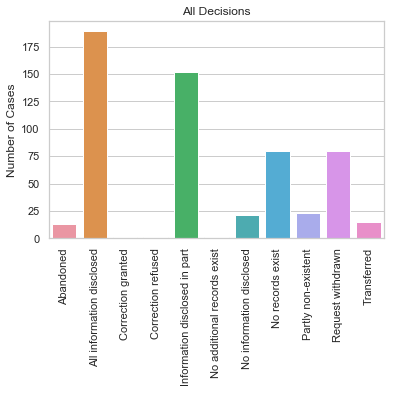

In [402]:
# Bar plot of all decisions made
columns = list(adf_groupbyDecision.index)

sns.set(style="whitegrid")
ax = sns.barplot(x=columns, y='Source', data=adf_groupbyDecision)
ax.set(ylabel='Number of Cases', title='All Decisions')
plt.xticks(rotation=90)


In [56]:
# Let's create a matrix of Decision vs Source

# Source Type:
# Business                    198 
# Individual                  172 
# Individual by Agent         166 
# Media                        20 
# Business by Agent            19 
# Individual for dependant      1

df_byDecision = {}

source_types = []
for i in range (0, len(adf.Source.unique())):
    source_types.append(adf.Source.unique()[i])

decision_types = []
for i in range (0, len(adf.Decision.unique())):
    decision_types.append(adf.Decision.unique()[i])

counter = 0

for source in source_types:
    temp_df = adf[adf['Source'] == source].groupby('Decision').count()[['Source']]
    df_byDecision[counter] = temp_df.T    # Transpose
    if len(df_byDecision[counter].columns) != len(decision_types):
        for column in decision_types:
            if column not in df_byDecision[counter].columns:
                df_byDecision[counter][column] = 0

    df_byDecision[counter].rename(index={'Source': source}, inplace=True)
    df_byDecision[counter].rename
    counter += 1
    
#print(len(df_byDecision))

df_byDecision = pd.concat(df_byDecision, sort=True)

df_byDecision


Abandoned  All information disclosed  \
0 Business                          3                         64   
1 Individual                        5                         56   
2 Individual by Agent               4                         63   
3 Business by Agent                 0                          4   
4 Media                             0                          2   
5 Individual for dependant          1                          0   

                            Correction granted  Correction refused  \
0 Business                                   0                   0   
1 Individual                                 1                   1   
2 Individual by Agent                        0                   0   
3 Business by Agent                          0                   0   
4 Media                                      0                   0   
5 Individual for dependant                   0                   0   

                            Information disclosed in part  \
0 Business                                             36   
1 Individual                                           45   
2 Individual by Agent                                  56   
3 Business by Agent                                     6   
4 Media                                                 9   
5 Individual for dependant                              0   

                            No additional records exist  \
0 Business                                            0   
1 Individual                                          1   
2 Individual by Agent                                 0   
3 Business by Agent                                   0   
4 Media                                               0   
5 Individual for dependant                            0   

                            No information disclosed  No records exist  \
0 Business                                         2                43   
1 Individual                                      10                14   
2 Individual by Agent                              1                20   
3 Business by Agent                                2                 2   
4 Media                                            6                 1   
5 Individual for dependant                         0                 0   

                            Partly non-existent  Request withdrawn  \
0 Business                                   10                 38   
1 Individual                                  9                 23   
2 Individual by Agent                         3                 13   
3 Business by Agent                           0                  5   
4 Media                                       1                  1   
5 Individual for dependant                    0                  0   

                            Transferred  
0 Business                            2  
1 Individual                          7  
2 Individual by Agent                 6  
3 Business by Agent                   0  
4 Media                               0  
5 Individual for dependant            0

We have now created a multi-index array:

In [57]:
df_byDecision.index

MultiIndex(levels=[[0, 1, 2, 3, 4, 5], ['Business', 'Business by Agent', 'Individual', 'Individual by Agent', 'Individual for dependant', 'Media']],
           labels=[[0, 1, 2, 3, 4, 5], [0, 2, 3, 1, 5, 4]])

So, let's reset index to be the Source:

In [58]:
df_byDecision = df_byDecision.reset_index(level=0, drop=True)

In [60]:
df_byDecision

Abandoned  All information disclosed  \
Business                          3                         64   
Individual                        5                         56   
Individual by Agent               4                         63   
Business by Agent                 0                          4   
Media                             0                          2   
Individual for dependant          1                          0   

                          Correction granted  Correction refused  \
Business                                   0                   0   
Individual                                 1                   1   
Individual by Agent                        0                   0   
Business by Agent                          0                   0   
Media                                      0                   0   
Individual for dependant                   0                   0   

                          Information disclosed in part  \
Business                                             36   
Individual                                           45   
Individual by Agent                                  56   
Business by Agent                                     6   
Media                                                 9   
Individual for dependant                              0   

                          No additional records exist  \
Business                                            0   
Individual                                          1   
Individual by Agent                                 0   
Business by Agent                                   0   
Media                                               0   
Individual for dependant                            0   

                          No information disclosed  No records exist  \
Business                                         2                43   
Individual                                      10                14   
Individual by Agent                              1                20   
Business by Agent                                2                 2   
Media                                            6                 1   
Individual for dependant                         0                 0   

                          Partly non-existent  Request withdrawn  Transferred  
Business                                   10                 38            2  
Individual                                  9                 23            7  
Individual by Agent                         3                 13            6  
Business by Agent                           0                  5            0  
Media                                       1                  1            0  
Individual for dependant                    0                  0            0

In [59]:
df_byDecision.index

Index(['Business', 'Individual', 'Individual by Agent', 'Business by Agent',
       'Media', 'Individual for dependant'],
      dtype='object')

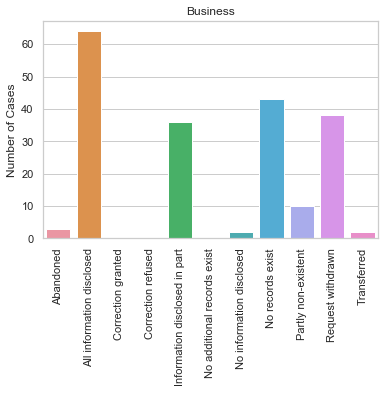

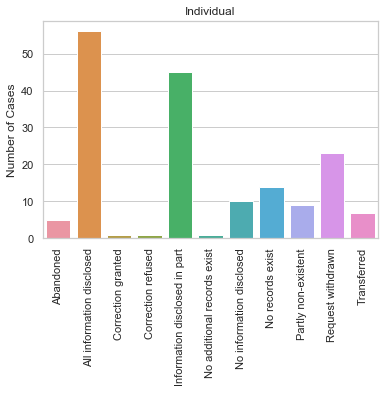

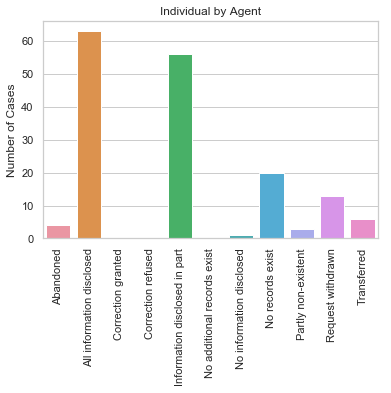

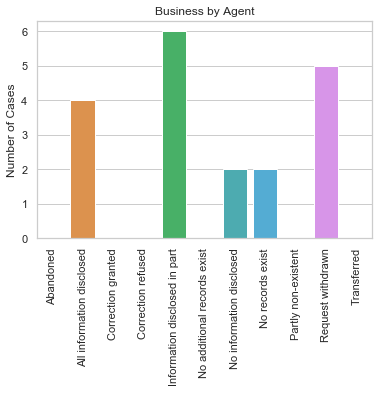

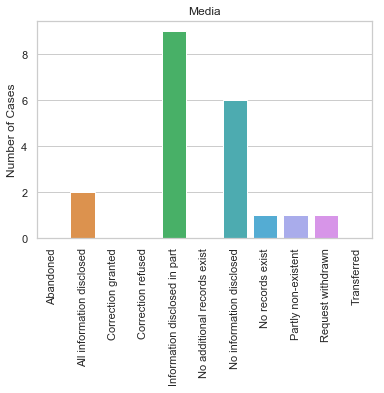

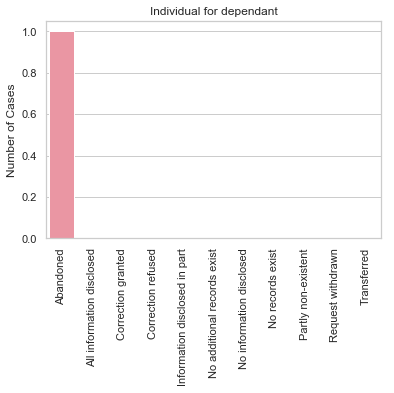

In [62]:
# Visualizing the data just obtained, for each of the sources

counter = 0

for source in source_types:
    sns.set(style="whitegrid")
    ax = sns.barplot(data=df_byDecision[counter: counter + 1])
    ax.set(ylabel='Number of Cases', title=source)
    plt.xticks(rotation=90)
    plt.show()
    counter += 1
    

Another useful view from the same data is looking at each type of decision for all the sources (the inverse of what we jsut did above.)

In [63]:
# Let's create a matrix of Source vs Decision

df_byEntity = {}

for decision in decision_types:
    temp_df = adf[adf['Decision'] == decision].groupby('Source').count()[['Decision']]
    df_byEntity[counter] = temp_df.T
    if len(df_byEntity[counter].columns) != len(source_types):
        for column in source_types:
            if column not in df_byEntity[counter].columns:
                df_byEntity[counter][column] = 0

    df_byEntity[counter].rename(index={'Decision': decision}, inplace=True)
    df_byEntity[counter].rename
    counter += 1
    
df_byEntity = pd.concat(df_byEntity, sort=True)

df_byEntity

Business  Business by Agent  Individual  \
6  Information disclosed in part        36                  6          45   
7  All information disclosed            64                  4          56   
8  Request withdrawn                    38                  5          23   
9  Partly non-existent                  10                  0           9   
10 Transferred                           2                  0           7   
11 No records exist                     43                  2          14   
12 No information disclosed              2                  2          10   
13 Correction refused                    0                  0           1   
14 Correction granted                    0                  0           1   
15 Abandoned                             3                  0           5   
16 No additional records exist           0                  0           1   

                                  Individual by Agent  \
6  Information disclosed in part                   56   
7  All information disclosed                       63   
8  Request withdrawn                               13   
9  Partly non-existent                              3   
10 Transferred                                      6   
11 No records exist                                20   
12 No information disclosed                         1   
13 Correction refused                               0   
14 Correction granted                               0   
15 Abandoned                                        4   
16 No additional records exist                      0   

                                  Individual for dependant  Media  
6  Information disclosed in part                         0      9  
7  All information disclosed                             0      2  
8  Request withdrawn                                     0      1  
9  Partly non-existent                                   0      1  
10 Transferred                                           0      0  
11 No records exist                                      0      1  
12 No information disclosed                              0      6  
13 Correction refused                                    0      0  
14 Correction granted                                    0      0  
15 Abandoned                                             1      0  
16 No additional records exist                           0      0

In [64]:
# Resetting index to remove multi-indexing
df_byEntity = df_byEntity.reset_index(level=0, drop=True)
df_byEntity

Business  Business by Agent  Individual  \
Information disclosed in part        36                  6          45   
All information disclosed            64                  4          56   
Request withdrawn                    38                  5          23   
Partly non-existent                  10                  0           9   
Transferred                           2                  0           7   
No records exist                     43                  2          14   
No information disclosed              2                  2          10   
Correction refused                    0                  0           1   
Correction granted                    0                  0           1   
Abandoned                             3                  0           5   
No additional records exist           0                  0           1   

                               Individual by Agent  Individual for dependant  \
Information disclosed in part                   56                         0   
All information disclosed                       63                         0   
Request withdrawn                               13                         0   
Partly non-existent                              3                         0   
Transferred                                      6                         0   
No records exist                                20                         0   
No information disclosed                         1                         0   
Correction refused                               0                         0   
Correction granted                               0                         0   
Abandoned                                        4                         1   
No additional records exist                      0                         0   

                               Media  
Information disclosed in part      9  
All information disclosed          2  
Request withdrawn                  1  
Partly non-existent                1  
Transferred                        0  
No records exist                   1  
No information disclosed           6  
Correction refused                 0  
Correction granted                 0  
Abandoned                          0  
No additional records exist        0

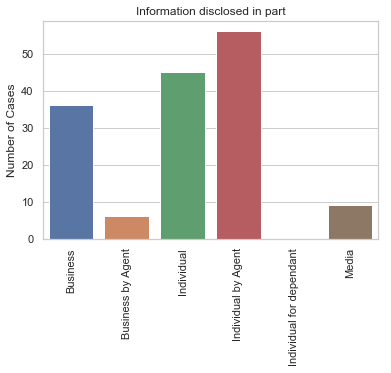

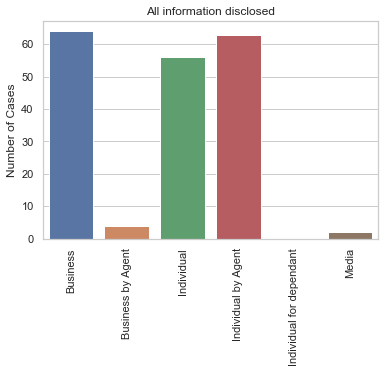

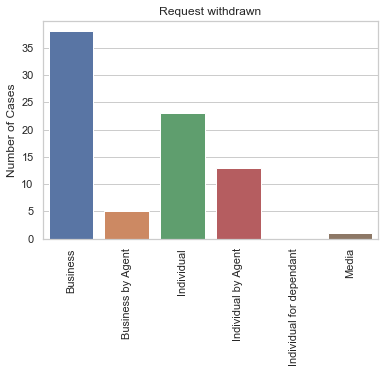

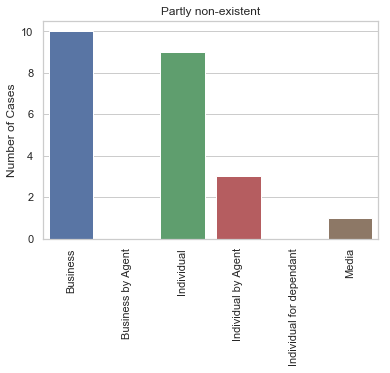

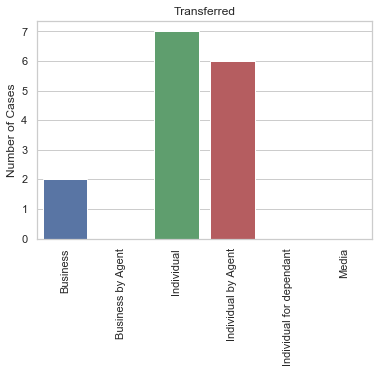

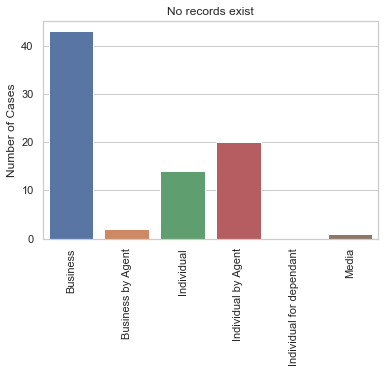

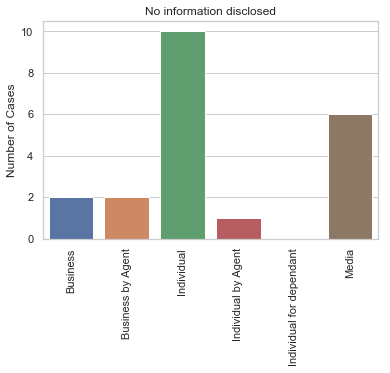

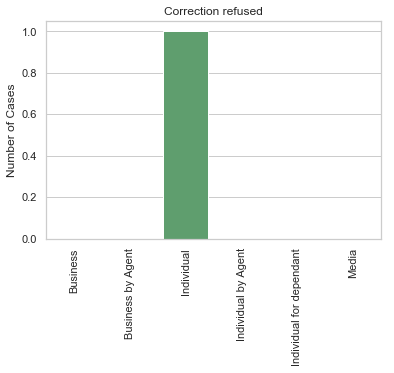

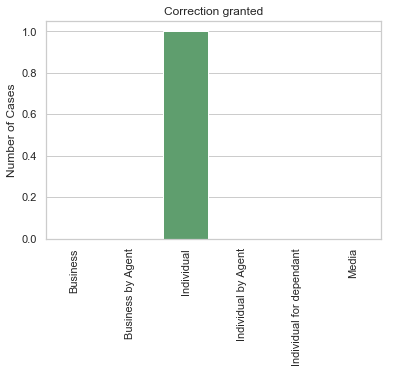

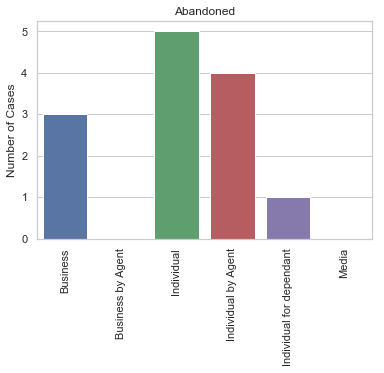

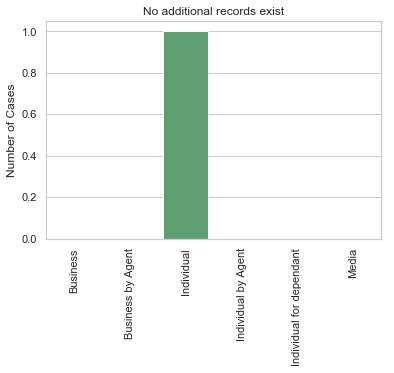

In [65]:
counter = 0

for decision in decision_types:
    sns.set(style="whitegrid")
    ax = sns.barplot(data=df_byEntity[counter: counter + 1])
    ax.set(ylabel='Number of Cases', title=decision)
    plt.xticks(rotation=90)
    plt.show()
    counter += 1

Another approach could be to drop the columns where there is no decision made. Meaning, when it was not on the hands of the person granting a decision, such as a request withdrawn or abandoned. It is important to note that the subset is still unbalanced.

In [66]:
sub_df_byDecision = df_byDecision.drop(columns=['Abandoned', 'Correction granted', 'Correction refused',
                                                'No additional records exist', 'No records exist', 
                                                'Partly non-existent', 'Request withdrawn', 'Transferred'])


In [67]:
sub_df_byDecision

All information disclosed  \
Business                                         64   
Individual                                       56   
Individual by Agent                              63   
Business by Agent                                 4   
Media                                             2   
Individual for dependant                          0   

                          Information disclosed in part  \
Business                                             36   
Individual                                           45   
Individual by Agent                                  56   
Business by Agent                                     6   
Media                                                 9   
Individual for dependant                              0   

                          No information disclosed  
Business                                         2  
Individual                                      10  
Individual by Agent                              1  
Business by Agent                                2  
Media                                            6  
Individual for dependant                         0

In [68]:
# Normalizing the subset by row - that is, each row (source) adds up to 100%
norm_sub_df_byDecision = sub_df_byDecision.div(sub_df_byDecision.sum(axis=1), axis=0)
norm_sub_df_byDecision

All information disclosed  \
Business                                   0.627451   
Individual                                 0.504505   
Individual by Agent                        0.525000   
Business by Agent                          0.333333   
Media                                      0.117647   
Individual for dependant                        NaN   

                          Information disclosed in part  \
Business                                       0.352941   
Individual                                     0.405405   
Individual by Agent                            0.466667   
Business by Agent                              0.500000   
Media                                          0.529412   
Individual for dependant                            NaN   

                          No information disclosed  
Business                                  0.019608  
Individual                                0.090090  
Individual by Agent                       0.008333  
Business by Agent                         0.166667  
Media                                     0.352941  
Individual for dependant                       NaN

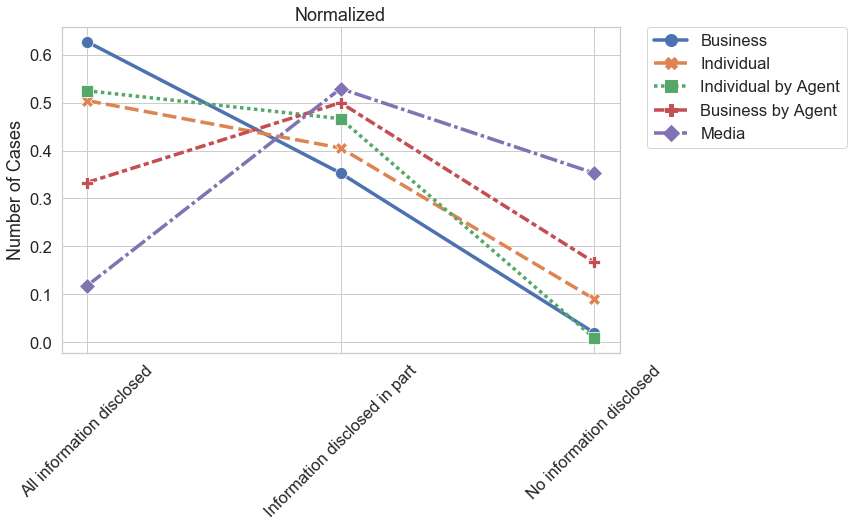

In [394]:
#sns.set_palette("husl")
sns.set_palette("deep")
# And plotting the decisions for each of the sources
plt.figure(figsize=(10, 6))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 3.5, "lines.markersize": 12.0})
ax = sns.lineplot(data=norm_sub_df_byDecision.T, markers=True)
ax.set(ylabel='Number of Cases', title='Normalized')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



With this view, one sees that business do better, followed by individuals by agent. Media, having few requests, does not do well.

Plotting the decisions for each of the sources (transposed of previous plot - each source adds up to 100%.)

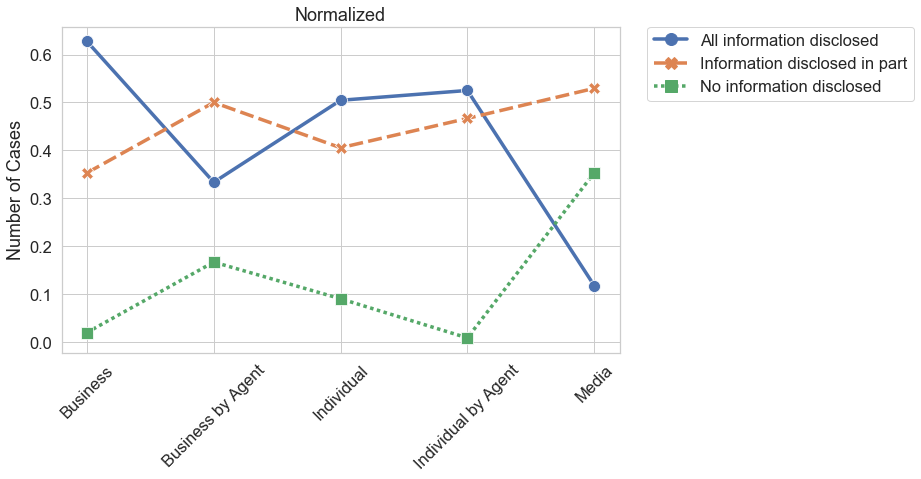

In [259]:
plt.figure(figsize=(10, 6))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 3.5, "lines.markersize": 12.0})
ax = sns.lineplot(data=norm_sub_df_byDecision, markers=True)
ax.set(ylabel='Number of Cases', title='Normalized')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

And looking at the same data but with some stacked or grouped bar plots!

In [289]:
norm_sub_df_byDecision

All information disclosed  \
Business                                   0.627451   
Individual                                 0.504505   
Individual by Agent                        0.525000   
Business by Agent                          0.333333   
Media                                      0.117647   
Individual for dependant                        NaN   

                          Information disclosed in part  \
Business                                       0.352941   
Individual                                     0.405405   
Individual by Agent                            0.466667   
Business by Agent                              0.500000   
Media                                          0.529412   
Individual for dependant                            NaN   

                          No information disclosed  
Business                                  0.019608  
Individual                                0.090090  
Individual by Agent                       0.008333  
Business by Agent                         0.166667  
Media                                     0.352941  
Individual for dependant                       NaN

In [294]:
# Individual for dependent does not have any of these cases.
norm_sub_df_byDecision = norm_sub_df_byDecision.drop('Individual for dependant')

In [295]:
norm_sub_df_byDecision.index

Index(['Business', 'Individual', 'Individual by Agent', 'Business by Agent',
       'Media'],
      dtype='object')

In [296]:
categ = list(norm_sub_df_byDecision.index)
categ

['Business', 'Individual', 'Individual by Agent', 'Business by Agent', 'Media']

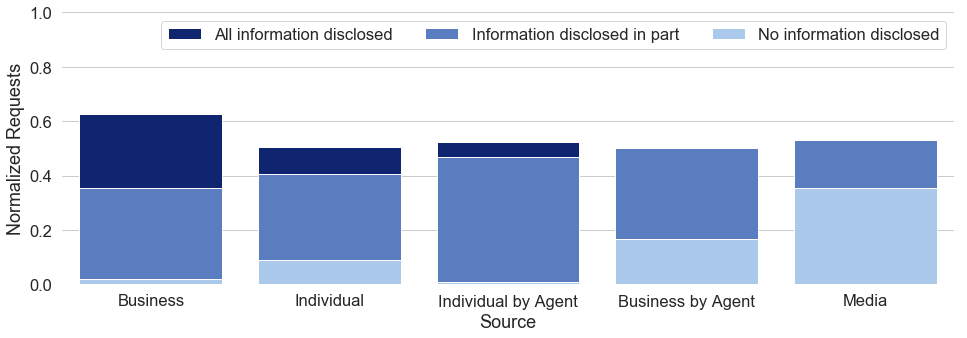

In [314]:
categ = list(norm_sub_df_byDecision.index)

f, ax = plt.subplots(figsize=(16, 5))

sns.set_color_codes('dark')
sns.barplot(y='All information disclosed', x=categ, data=norm_sub_df_byDecision,
            label='All information disclosed', color="b")

sns.set_color_codes('muted')
sns.barplot(y='Information disclosed in part', x=categ, data=norm_sub_df_byDecision,
            label='Information disclosed in part', color="b")

sns.set_color_codes('pastel')
sns.barplot(y='No information disclosed', x=categ, data=norm_sub_df_byDecision,
            label='No information disclosed', color="b")

ax.legend(ncol=3, loc="upper right", frameon=True)
ax.set(ylim=(0, 1), xlabel="Source",
       ylabel="Normalized Requests")
sns.despine(left=True, bottom=True)

In [333]:
norm_sub_df_byDecision

All information disclosed  Information disclosed in part  \
Business                              0.627451                       0.352941   
Individual                            0.504505                       0.405405   
Individual by Agent                   0.525000                       0.466667   
Business by Agent                     0.333333                       0.500000   
Media                                 0.117647                       0.529412   

                     No information disclosed  
Business                             0.019608  
Individual                           0.090090  
Individual by Agent                  0.008333  
Business by Agent                    0.166667  
Media                                0.352941

In [369]:
norm_sub_df_byDecision['All information disclosed'].values.tolist()

[0.6274509803921569,
 0.5045045045045045,
 0.525,
 0.3333333333333333,
 0.11764705882352941]

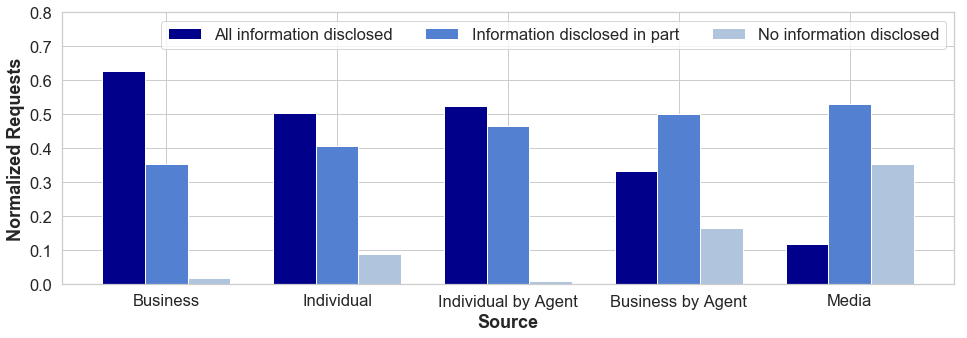

In [383]:
categ = list(norm_sub_df_byDecision.index)

plt.subplots(figsize=(16, 5))

# Set width of bar
barWidth = 0.25
 
# Set height of bar
bars1 = norm_sub_df_byDecision['All information disclosed'].values.tolist()
bars2 = norm_sub_df_byDecision['Information disclosed in part'].values.tolist()
bars3 = norm_sub_df_byDecision['No information disclosed'].values.tolist()

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
plt.bar(r1, bars1, color='darkblue', width=barWidth, edgecolor='white', label='All information disclosed')
plt.bar(r2, bars2, color='#5480d2', width=barWidth, edgecolor='white', label='Information disclosed in part')
plt.bar(r3, bars3, color='#b0c4de', width=barWidth, edgecolor='white', label='No information disclosed')

# Add xticks on the middle of the group bars
plt.xlabel('Source', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], categ)
 
# Create legend & Show graphic
plt.legend(ncol=3, loc="upper right", frameon=True)
plt.ylabel('Normalized Requests', fontweight='bold')
plt.ylim(0,0.8)
plt.show()


There are some interesting features in these plots. 

- Business get the most cases where the information is fully disclosed and the least with no disclosed information.
- Media is the other way around. 
- Individuals by Agent fare better than individuals without one, however, the opposite is true for business and business by agents.



And another view for the same data can be done by exchanging the axes, i.e., by finding the source for each of the decisions. We need to start the table form scratch, to drop the rows where the decision was not made by the clerks.

In [70]:
sub_df_byEntity = df_byEntity.drop(['Abandoned', 'Correction granted', 'Correction refused',
                                                'No additional records exist', 'No records exist', 
                                                'Partly non-existent', 'Request withdrawn', 'Transferred'], axis=0)

In [71]:
sub_df_byEntity

Business  Business by Agent  Individual  \
Information disclosed in part        36                  6          45   
All information disclosed            64                  4          56   
No information disclosed              2                  2          10   

                               Individual by Agent  Individual for dependant  \
Information disclosed in part                   56                         0   
All information disclosed                       63                         0   
No information disclosed                         1                         0   

                               Media  
Information disclosed in part      9  
All information disclosed          2  
No information disclosed           6

In [264]:
sub_df_byEntity = sub_df_byEntity.drop(columns='Individual for dependant')
sub_df_byEntity

Business  Business by Agent  Individual  \
Information disclosed in part        36                  6          45   
All information disclosed            64                  4          56   
No information disclosed              2                  2          10   

                               Individual by Agent  Media  
Information disclosed in part                   56      9  
All information disclosed                       63      2  
No information disclosed                         1      6

In [403]:
# Normalizing by row, i.e, by type of decision. Decisions add up to 100%
norm_sub_df_byEntity = sub_df_byEntity.div(sub_df_byEntity.sum(axis=1), axis=0)

In [266]:
norm_sub_df_byEntity

Business  Business by Agent  Individual  \
Information disclosed in part  0.236842           0.039474    0.296053   
All information disclosed      0.338624           0.021164    0.296296   
No information disclosed       0.095238           0.095238    0.476190   

                               Individual by Agent     Media  
Information disclosed in part             0.368421  0.059211  
All information disclosed                 0.333333  0.010582  
No information disclosed                  0.047619  0.285714

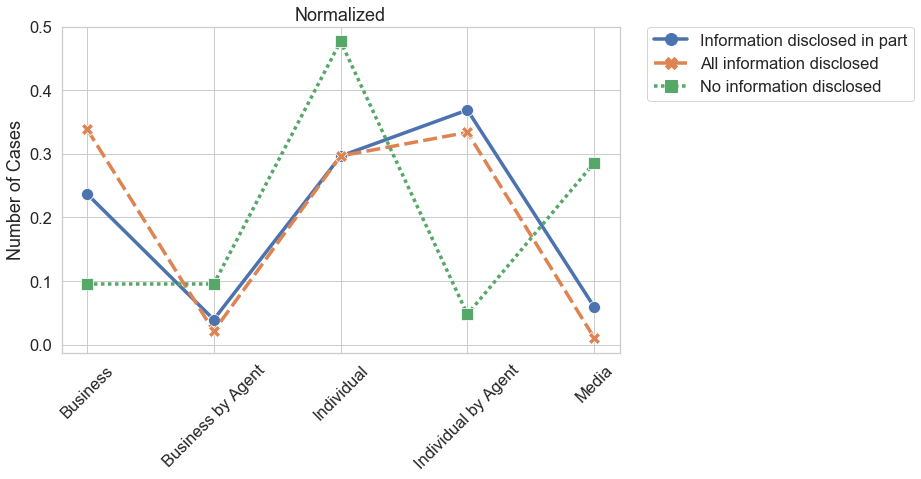

In [272]:
# Decisions add up to 100%
plt.figure(figsize=(10, 6))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 3.5, "lines.markersize": 12.0})
ax = sns.lineplot(data=norm_sub_df_byEntity.T, markers=True)
ax.set(ylabel='Number of Cases', title='Normalized')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

- Of the requests where all the information was disclosed, 35% belong to business, 30% to individuals, and 33% to individuals by agents.
- For partially disclosed information, 37% were for individuals by agents, 30% for individuals, and 25% for businesses. 
- Almost 50% of the requests where no information was disclosed were made by individuals, and 30% were made by the media. 

And transposing those results, again, each type of decision adds up to 100%.

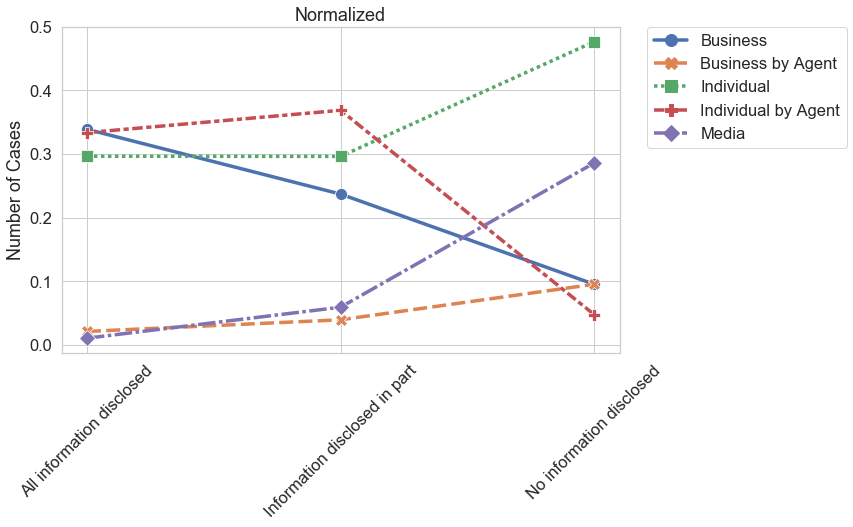

In [404]:
plt.figure(figsize=(10, 6))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 3.5, "lines.markersize": 12.0})
ax = sns.lineplot(data=norm_sub_df_byEntity, markers=True)
ax.set(ylabel='Number of Cases', title='Normalized')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Now, doing a grouped bar plot for all the decisions.

In [405]:
df_byDecision

Abandoned  All information disclosed  \
Business                          3                         64   
Individual                        5                         56   
Individual by Agent               4                         63   
Business by Agent                 0                          4   
Media                             0                          2   
Individual for dependant          1                          0   

                          Correction granted  Correction refused  \
Business                                   0                   0   
Individual                                 1                   1   
Individual by Agent                        0                   0   
Business by Agent                          0                   0   
Media                                      0                   0   
Individual for dependant                   0                   0   

                          Information disclosed in part  \
Business                                             36   
Individual                                           45   
Individual by Agent                                  56   
Business by Agent                                     6   
Media                                                 9   
Individual for dependant                              0   

                          No additional records exist  \
Business                                            0   
Individual                                          1   
Individual by Agent                                 0   
Business by Agent                                   0   
Media                                               0   
Individual for dependant                            0   

                          No information disclosed  No records exist  \
Business                                         2                43   
Individual                                      10                14   
Individual by Agent                              1                20   
Business by Agent                                2                 2   
Media                                            6                 1   
Individual for dependant                         0                 0   

                          Partly non-existent  Request withdrawn  Transferred  
Business                                   10                 38            2  
Individual                                  9                 23            7  
Individual by Agent                         3                 13            6  
Business by Agent                           0                  5            0  
Media                                       1                  1            0  
Individual for dependant                    0                  0            0

In [408]:
# Normalizing the subset by row - that is, each row (source) adds up to 100%
norm_df_byDecision = df_byDecision.div(df_byDecision.sum(axis=1), axis=0)
norm_df_byDecision = norm_df_byDecision.drop('Individual for dependant')
norm_df_byDecision

Abandoned  All information disclosed  Correction granted  \
Business              0.015152                   0.323232            0.000000   
Individual            0.029070                   0.325581            0.005814   
Individual by Agent   0.024096                   0.379518            0.000000   
Business by Agent     0.000000                   0.210526            0.000000   
Media                 0.000000                   0.100000            0.000000   

                     Correction refused  Information disclosed in part  \
Business                       0.000000                       0.181818   
Individual                     0.005814                       0.261628   
Individual by Agent            0.000000                       0.337349   
Business by Agent              0.000000                       0.315789   
Media                          0.000000                       0.450000   

                     No additional records exist  No information disclosed  \
Business                                0.000000                  0.010101   
Individual                              0.005814                  0.058140   
Individual by Agent                     0.000000                  0.006024   
Business by Agent                       0.000000                  0.105263   
Media                                   0.000000                  0.300000   

                     No records exist  Partly non-existent  Request withdrawn  \
Business                     0.217172             0.050505           0.191919   
Individual                   0.081395             0.052326           0.133721   
Individual by Agent          0.120482             0.018072           0.078313   
Business by Agent            0.105263             0.000000           0.263158   
Media                        0.050000             0.050000           0.050000   

                     Transferred  
Business                0.010101  
Individual              0.040698  
Individual by Agent     0.036145  
Business by Agent       0.000000  
Media                   0.000000

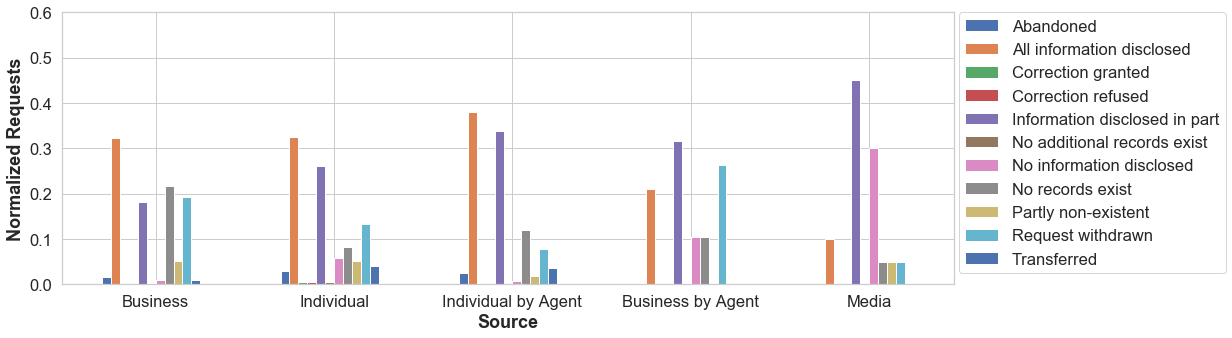

In [491]:
categ = list(norm_df_byDecision.index)

dec_norm_df_byDecision = norm_df_byDecision.columns.values.tolist()

plt.subplots(figsize=(16, 5))

# Set width of bar
barWidth = 0.05

bars = []
 
# Set height of bar
for dec in dec_norm_df_byDecision:
    bars.append(norm_df_byDecision[dec])

rs = []
r = np.arange(len(bars[0]))
rs.append(r)
# Set position of bar on X axis
for bw in range(1, len(bars)):
    rn = [x + barWidth for x in r]
    rs.append(rn)
    r = rn
    
# Make the plot
counter = 0

for dec in dec_norm_df_byDecision:
    plt.bar(rs[counter], bars[counter], width=barWidth, edgecolor='white', label=dec)
    counter += 1

# Add xticks on the middle of the group bars
center_lb = len(dec_norm_df_byDecision)/2
plt.xlabel('Source', fontweight='bold')
plt.xticks([r + center_lb*barWidth for r in range(len(bars[0]))], categ)
 
# Create legend & Show graphic
plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
plt.ylabel('Normalized Requests', fontweight='bold')
plt.ylim(0, 0.6)
plt.show()


And if we drop decisions that have less than 15 instances:

In [467]:
norm_df_byDecision_over15 = df_byDecision.copy()

dec_norm_df_byDecision_over15 = norm_df_byDecision_over15.columns.values.tolist()

todrop = []

for dec in dec_norm_df_byDecision_over15:
    if norm_df_byDecision_over15[dec].sum(axis=0) < 15:
        todrop.append(dec)

for decs in todrop:
    norm_df_byDecision_over15 = norm_df_byDecision_over15.drop(columns=decs)

norm_df_byDecision_over15      
    

All information disclosed  \
Business                                         64   
Individual                                       56   
Individual by Agent                              63   
Business by Agent                                 4   
Media                                             2   
Individual for dependant                          0   

                          Information disclosed in part  \
Business                                             36   
Individual                                           45   
Individual by Agent                                  56   
Business by Agent                                     6   
Media                                                 9   
Individual for dependant                              0   

                          No information disclosed  No records exist  \
Business                                         2                43   
Individual                                      10                14   
Individual by Agent                              1                20   
Business by Agent                                2                 2   
Media                                            6                 1   
Individual for dependant                         0                 0   

                          Partly non-existent  Request withdrawn  Transferred  
Business                                   10                 38            2  
Individual                                  9                 23            7  
Individual by Agent                         3                 13            6  
Business by Agent                           0                  5            0  
Media                                       1                  1            0  
Individual for dependant                    0                  0            0

In [470]:
# Normalizing the subset by row - that is, each row (source) adds up to 100%
norm_df_byDecision_over15 = norm_df_byDecision_over15.drop('Individual for dependant')
norm_df_byDecision_over15 = norm_df_byDecision_over15.div(norm_df_byDecision_over15.sum(axis=1), axis=0)
norm_df_byDecision_over15

All information disclosed  Information disclosed in part  \
Business                              0.328205                       0.184615   
Individual                            0.341463                       0.274390   
Individual by Agent                   0.388889                       0.345679   
Business by Agent                     0.210526                       0.315789   
Media                                 0.100000                       0.450000   

                     No information disclosed  No records exist  \
Business                             0.010256          0.220513   
Individual                           0.060976          0.085366   
Individual by Agent                  0.006173          0.123457   
Business by Agent                    0.105263          0.105263   
Media                                0.300000          0.050000   

                     Partly non-existent  Request withdrawn  Transferred  
Business                        0.051282           0.194872     0.010256  
Individual                      0.054878           0.140244     0.042683  
Individual by Agent             0.018519           0.080247     0.037037  
Business by Agent               0.000000           0.263158     0.000000  
Media                           0.050000           0.050000     0.000000

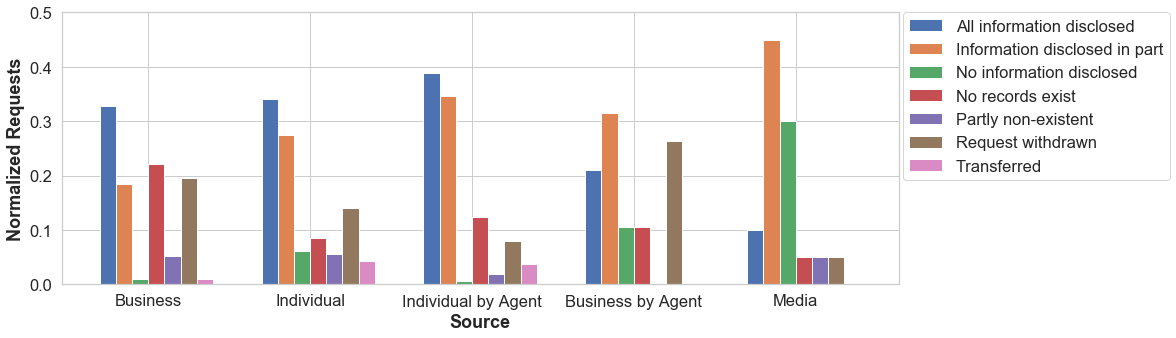

In [492]:
categ = list(norm_df_byDecision_over15.index)

dec_norm_df_byDecision_over15 = norm_df_byDecision_over15.columns.values.tolist()

plt.subplots(figsize=(15, 5))

# Set width of bar
barWidth = 0.1

bars = []
 
# Set height of bar
for dec in dec_norm_df_byDecision_over15:
    bars.append(norm_df_byDecision_over15[dec])

rs = []
r = np.arange(len(bars[0]))
rs.append(r)
# Set position of bar on X axis
for bw in range(1, len(bars)):
    rn = [x + barWidth for x in r]
    rs.append(rn)
    r = rn
    
# Make the plot
counter = 0

for dec in dec_norm_df_byDecision_over15:
    plt.bar(rs[counter], bars[counter], width=barWidth, edgecolor='white', label=dec)
    counter += 1

# Add xticks on the middle of the group bars
plt.xlabel('Source', fontweight='bold')
center_lb = len(norm_df_byDecision_over15)/2
plt.xticks([r + center_lb*barWidth for r in range(len(bars[0]))], categ)
 
# Create legend & Show graphic
plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
plt.ylabel('Normalized Requests', fontweight='bold')
plt.ylim(0, 0.5)
plt.show()


# NLP

Now we proceed to analize the actual *Summary_of_Requests*. For this, we turn to Natural Language Processing libraries, such as NLTK and spaCy, and the help of sklearn.

Broadly generalizing, there are few steps one needs to do before analyzing any text:
- Tokenize the text: Break the text in single words, i.e., tokens.
- Remove any unwanted characters, such as returns (\n), and punctuation, such as "-", "...", "”".
- Remove URLs or replace them by a word, say, "URL".
- Remove screen names or replace the '@' by a word, say, "screen_name".
- Remove capitalization of words.
- Remove words with less than 4 characters.
- Remove "stopwords", i.e., the most common words in a language. These words probably won't help classifying our text, examples are articles such as , 'a', 'the', 'and'. There is no single universal list of stop words.
- Lemmatization, which is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form.

In [74]:
import string
import re
import spacy
import nltk

from spacy.lang.en import English
parser = English()
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

from nltk.corpus import wordnet as wn

# To make word clouds
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# look at the most common item in a list
from collections import Counter

In [75]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/bertaerodriguez-
[nltk_data]     milla/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Generating a larger stop words list, a combination of the stop words of NLTK, scikit learn, and wordcloud. And adding also a symbols list.

In [870]:
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS) + list(STOPWORDS))
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "``", ",", ".", ":", "''"]

Defining a function that tokenizes, and cleans by removing white spaces, words with less than three characters, stopwords, and other specified symbols. This version also includes the spaCy lemmatizer.

In [871]:
def tokenize_lemm_rmstop_Text(sample):
    lda_tokens = []
    tokens = parser(sample)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token) 
    lemmas = []
    for tok in lda_tokens:    # spaCy lemmatization
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    lda_tokens = lemmas    
    lda_tokens = [tok for tok in lda_tokens if len(tok) > 3]
    lda_tokens = [tok for tok in lda_tokens if tok not in STOPLIST]
    lda_tokens = [tok for tok in lda_tokens if tok not in SYMBOLS]
    return lda_tokens

And one that just tokenizes the text.

In [872]:
def tokenize_rmSym_Text(sample):
    lda_tokens = []
    tokens = parser(sample)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token) 
    low = []
    for tok in lda_tokens:
        low.append(tok.text.lower().strip())
    lda_tokens = low  
    lda_tokens = [tok for tok in lda_tokens if tok not in SYMBOLS]
    return lda_tokens

Function than removes carriage returns and line breaks.

In [78]:
def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    return text

Function that gets the lemma of a word using NLTK.

In [79]:
# NLTK lemma
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    

Combining the tokenizer, which includes the lemmatizer, and clean functions. We won't use the NLKT one. This function, prepares a text in general, it will serve for our future analysis using LDA and LSA. 

In [740]:
def prepare_text_tlc(text):
    text = cleanText(text)
    tokens = tokenize_lemm_rmstop_Text(text)
    #tokens = [get_lemma(token) for token in tokens]
    return tokens

And isolating the summary of requests into a panda series, 

In [81]:
all_text = adf['Summary_of_Request']
print(all_text[:10])
print("No. of requests %d" % len(all_text))

0    Minutes of Service Delivery Subcommittee of ES...
1    Public Health inspection reports for the {loca...
2    Public Health inspection records for {location...
3    Public Health inspection records for {address ...
4    Vendor list report with total of year-to-date ...
5    Public Health inspection file for {name remove...
6    Scope of work and deliverables sections of con...
7    Number of contracts and dollar amount of contr...
8    Public Health inspection report regarding a co...
9    Phase I environmental site assessment regardin...
Name: Summary_of_Request, dtype: object
No. of requests 576


## N-grams and Word Clouds

With the purpose of finding out which are the most common words (unigrams) and phrases consisting of 2, 3, or n-words (bigrams, trigrams, and n-grams), it is easier if one combines all the words into a single string.

In [495]:
# Merging all the requests into a single line
all_text_merged = ''

for lines in range(0,len(all_text)):
    all_text_merged = all_text_merged + ' ' + all_text[lines]

In [498]:
print(all_text_merged[:200])    # Showing just 200 characters

 Minutes of Service Delivery Subcommittee of ESCAC for period of January 1, 1997 to January 13, 1999. Public Health inspection reports for the {location removed}, Kitchener for the past 3 years. Publi


Now that we have a single string, let's get the unigrams, bigrams (two consecutive words), and trigrams (three consecutive words.)

In [84]:
# Preparing text and getting unigrams
tokens = prepare_text_tlc(all_text_merged)
unigrams = tokens

In [85]:
print(unigrams[:25])
print("No. of unigrams %d" % len(unigrams))

['minutes', 'service', 'delivery', 'subcommittee', 'escac', 'period', 'january', '1997', 'january', '1999', 'public', 'health', 'inspection', 'report', 'location', 'remove', 'kitchener', 'past', 'year', 'public', 'health', 'inspection', 'record', 'location', 'remove']
No. of unigrams 6013


In [86]:
bigrams = nltk.bigrams(unigrams)
trigrams = nltk.trigrams(unigrams)

unigrams_counter = Counter(unigrams)
bigrams_counter = Counter(bigrams)
trigrams_counter = Counter(trigrams)

And showing the top ten most common grams,

In [87]:
print("No. of unique unigrams: %d" % len(unigrams_counter))
for unigram in unigrams_counter.most_common(10):
    print(unigram)

No. of unique unigrams: 1147
('remove', 284)
('file', 150)
('address', 123)
('removed}.', 123)
('ontario', 121)
('waterloo', 119)
('environmental', 115)
('copy', 110)
('site', 110)
('assessment', 107)


In [88]:
print("No. of unique bigrams: %d" % len(bigrams_counter))
for bigram in bigrams_counter.most_common(10):
    print(bigram)

No. of unique bigrams: 3420
(('address', 'remove'), 112)
(('ontario', 'works'), 102)
(('environmental', 'site'), 98)
(('site', 'assessment'), 97)
(('phase', 'environmental'), 97)
(('assessment', 'address'), 83)
(('copy', 'ontario'), 81)
(('complete', 'copy'), 78)
(('file', 'removed}.'), 77)
(('client', 'file'), 71)


In [89]:
print("No. of unique trigrams: %d" % len(trigrams_counter))
for trigram in trigrams_counter.most_common(10):
    print(trigram)

No. of unique trigrams: 4316
(('environmental', 'site', 'assessment'), 97)
(('phase', 'environmental', 'site'), 96)
(('site', 'assessment', 'address'), 82)
(('assessment', 'address', 'remove'), 80)
(('copy', 'ontario', 'works'), 79)
(('complete', 'copy', 'ontario'), 72)
(('ontario', 'works', 'client'), 67)
(('works', 'client', 'file'), 66)
(('client', 'file', 'removed}.'), 55)
(('address', 'remove', 'kitchener'), 36)


Visualizing the word cloud with a maximum of 100 words

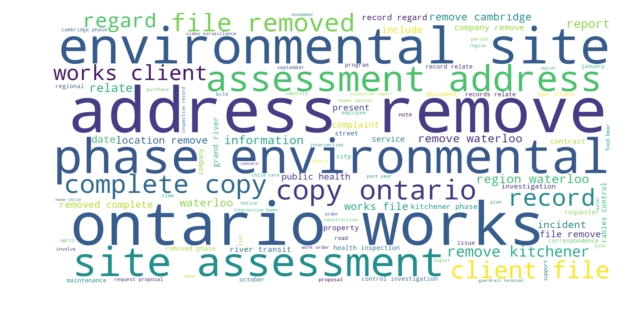

In [90]:
wordcloud1 = WordCloud(
                stopwords=STOPLIST,
                background_color='white',
                width=2000,
                height=1000,
                max_words=100
             ).generate(" ".join(unigrams))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud1, interpolation="bilinear", aspect='auto')
plt.axis('off')
plt.show()

And with no collocations, this is, with no bigrams, we get something that features the word "remove" quite prominently.

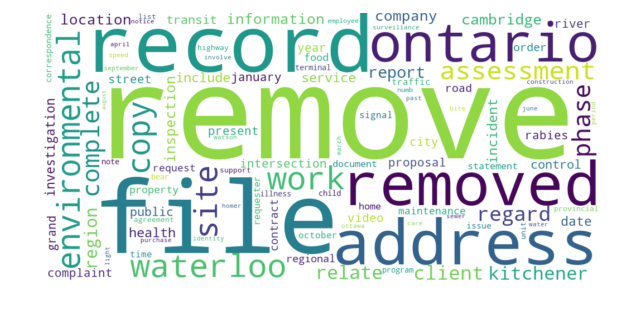

In [91]:
wordcloud2 = WordCloud(
                stopwords=STOPLIST,
                background_color='white',
                width=1000,
                height=500,
                collocations=False,
                max_words=100
             ).generate(" ".join(unigrams))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud2, interpolation="bilinear", aspect='auto')
plt.axis('off')
plt.show()

## N-grams and Word Clouds after removing phrases that include *"{ ... removed}"*

So, why is the word "remove" so important? It turns out, many of these requests have names of people or locations that needed to be removed for privacy reasons. So, let's reprocess the text taking this into account by using regular expressions.

In [92]:
# {address removed}, {name removed} {names removed} {location removed} {company name removed}
# {intersection removed}
# {request number removed}

new_stop_words = []
regex_phrase = r'(?:\{\w+\s*\w*\s*\w*\s*\w*\s*\w*\s*\w*\}|\(\w+\s*\w*\s*\w*\s*\w*\s*\w*\s*\w*\}|\{\w+\s*\w*\s*\w*\s*\w*\s*\w*\s*\w*\)|\(\w+\s*removed\)|\{\w+\s*\w*\s*\w*\s*\w*\s*\w*\s*\w*\{)'
'''
# Somehow splitting the regEx chain changes the output!
regex_phrase = r'(?:\{\w+\s*\w*\s*\w*\s*\w*\s*\w*\s*\w*\}|\
                  \(\w+\s*\w*\s*\w*\s*\w*\s*\w*\s*\w*\}|\
                  \{\w+\s*\w*\s*\w*\s*\w*\s*\w*\s*\w*\)|\
                  \{\w+\s*\w*\s*\w*\s*\w*\s*\w*\s*\w*\{|\(\w+\s*removed\)|\
                  )'
'''

matches = re.findall(regex_phrase, all_text_merged)
for match in matches:
    #print(match)
    new_stop_words.append(match)

# Change array to a set to remove duplicates
new_stop_words = set(new_stop_words)
# Turn back to a list
new_stop_words = list(new_stop_words)
print("No. of phrases to be removed: ", len(new_stop_words))    # 33
print(new_stop_words)
    
    

No. of phrases to be removed:  33
['{locations removed}', '{companies removed}', '{company names removed}', '(name removed}', '{request number removed}', '{Company name removed}', '{company removed}', '{developer removed}', '{company name removed}', '{street name removed}', '{addresses removed}', '{institutions removed}', '{address removed}', '{intersection removed}', '{date removed}', '{organization name removed}', '{location removed}', '{address}', '{Name removed}', '{name removed}', '{name and position removed}', '(name removed)', '{company name and address removed}', '{facility removed}', '(address removed}', '{restaurant removed}', '{names removed}', '(location removed)', '{restaurant name removed}', '{orgnization name removed}', '{individual by agent}', '{name removed{', '{business removed}']


In [93]:
all_text_merged_removed = all_text_merged

# Replace phases by nothing
for stop in new_stop_words:
    all_text_merged_removed = all_text_merged_removed.replace(stop, '')
    

In [94]:
all_text_merged_removed[:500]

"a Minutes of Service Delivery Subcommittee of ESCAC for period of January 1, 1997 to January 13, 1999. Public Health inspection reports for the , Kitchener for the past 3 years. Public Health inspection records for , Cambridge for the past 2 years. Public Health inspection records for , Cambridge, relating to sink odours in 1994. Vendor list report with total of year-to-date purchases at fiscal year end for 1996, 1997, and 1998. Public Health inspection file for  at  regarding requester's dismis"

So, let's find the unigrams, bigrams, trigrams, and n-grams (4-5 words), and their most commom occurrences, with this new text.

In [95]:
tokens_rm = prepare_text_tlc(all_text_merged_removed)

In [96]:
unigrams_rm = tokens_rm
unigrams_counter_rm = Counter(unigrams_rm)
print("No. of unique unigrams: %d" % len(unigrams_counter_rm))
for unigram in unigrams_counter_rm.most_common(10):
    print(unigram)

No. of unique unigrams: 1139
('file', 150)
('ontario', 121)
('waterloo', 119)
('environmental', 115)
('copy', 110)
('site', 110)
('assessment', 107)
('record', 104)
('works', 102)
('phase', 99)


In [97]:
bigrams_rm = nltk.bigrams(unigrams_rm)
bigrams_counter_rm = Counter(bigrams_rm)
print("No. of unique bigrams: %d" % len(bigrams_counter_rm))
for bigram in bigrams_counter_rm.most_common(20):
    print(bigram)

No. of unique bigrams: 3314
(('ontario', 'works'), 102)
(('environmental', 'site'), 98)
(('site', 'assessment'), 97)
(('phase', 'environmental'), 97)
(('copy', 'ontario'), 84)
(('complete', 'copy'), 78)
(('client', 'file'), 71)
(('works', 'client'), 67)
(('region', 'waterloo'), 45)
(('works', 'file'), 33)
(('assessment', 'kitchener'), 30)
(('file', 'complete'), 28)
(('public', 'health'), 26)
(('assessment', 'waterloo'), 25)
(('record', 'regard'), 24)
(('assessment', 'cambridge'), 22)
(('river', 'transit'), 21)
(('grand', 'river'), 21)
(('kitchener', 'phase'), 20)
(('rabies', 'control'), 19)


In [98]:
trigrams_rm = nltk.trigrams(unigrams_rm)
trigrams_counter_rm = Counter(trigrams_rm)
print("No. of unique trigrams: %d" % len(trigrams_counter_rm))
for trigram in trigrams_counter_rm.most_common(20):
    print(trigram)

No. of unique trigrams: 4062
(('environmental', 'site', 'assessment'), 97)
(('phase', 'environmental', 'site'), 96)
(('copy', 'ontario', 'works'), 81)
(('complete', 'copy', 'ontario'), 74)
(('ontario', 'works', 'client'), 67)
(('works', 'client', 'file'), 66)
(('ontario', 'works', 'file'), 33)
(('site', 'assessment', 'kitchener'), 30)
(('file', 'complete', 'copy'), 24)
(('site', 'assessment', 'waterloo'), 22)
(('site', 'assessment', 'cambridge'), 22)
(('grand', 'river', 'transit'), 21)
(('kitchener', 'phase', 'environmental'), 20)
(('assessment', 'kitchener', 'phase'), 18)
(('public', 'health', 'inspection'), 16)
(('rabies', 'control', 'investigation'), 14)
(('waterloo', 'phase', 'environmental'), 13)
(('client', 'file', 'complete'), 13)
(('works', 'file', 'complete'), 12)
(('food', 'bear', 'illness'), 12)


In [99]:
everygrams_rm = nltk.everygrams(unigrams_rm, min_len=4, max_len=4)
everygrams_counter_rm = Counter(everygrams_rm)
print("No. of unique everygrams size 4: %d" % len(everygrams_counter_rm))
for everygram in everygrams_counter_rm.most_common(10):
    print(everygram)

No. of unique everygrams size 4: 4396
(('phase', 'environmental', 'site', 'assessment'), 96)
(('complete', 'copy', 'ontario', 'works'), 72)
(('ontario', 'works', 'client', 'file'), 66)
(('copy', 'ontario', 'works', 'client'), 59)
(('environmental', 'site', 'assessment', 'kitchener'), 30)
(('file', 'complete', 'copy', 'ontario'), 23)
(('environmental', 'site', 'assessment', 'cambridge'), 22)
(('environmental', 'site', 'assessment', 'waterloo'), 22)
(('copy', 'ontario', 'works', 'file'), 22)
(('kitchener', 'phase', 'environmental', 'site'), 20)


In [100]:
everygrams_rm_5 = nltk.everygrams(unigrams_rm, min_len=4, max_len=5)
everygrams_counter_rm_5 = Counter(everygrams_rm_5)
print("No. of unique everygrams size 4 or 5: %d" % len(everygrams_counter_rm_5))
for everygram in everygrams_counter_rm_5.most_common(50):
    print(everygram)

No. of unique everygrams size 4 or 5: 9014
(('phase', 'environmental', 'site', 'assessment'), 96)
(('complete', 'copy', 'ontario', 'works'), 72)
(('ontario', 'works', 'client', 'file'), 66)
(('copy', 'ontario', 'works', 'client'), 59)
(('copy', 'ontario', 'works', 'client', 'file'), 59)
(('complete', 'copy', 'ontario', 'works', 'client'), 51)
(('environmental', 'site', 'assessment', 'kitchener'), 30)
(('phase', 'environmental', 'site', 'assessment', 'kitchener'), 30)
(('file', 'complete', 'copy', 'ontario', 'works'), 23)
(('file', 'complete', 'copy', 'ontario'), 23)
(('environmental', 'site', 'assessment', 'cambridge'), 22)
(('environmental', 'site', 'assessment', 'waterloo'), 22)
(('copy', 'ontario', 'works', 'file'), 22)
(('phase', 'environmental', 'site', 'assessment', 'waterloo'), 22)
(('phase', 'environmental', 'site', 'assessment', 'cambridge'), 22)
(('complete', 'copy', 'ontario', 'works', 'file'), 21)
(('kitchener', 'phase', 'environmental', 'site'), 20)
(('kitchener', 'phase',

And just for the fun of visualizing it, wordclouds!

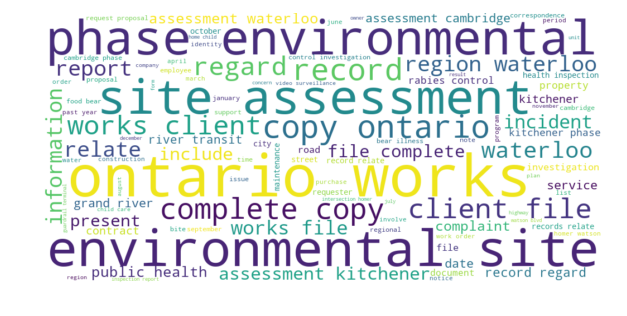

In [101]:
wordcloud3 = WordCloud(
                stopwords=STOPLIST,
                background_color='white',
                width=1000,
                height=500,
                max_words=100
            ).generate(" ".join(unigrams_rm))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud3, interpolation="bilinear", aspect='auto')
plt.axis('off')
plt.show()

And without bigrams:

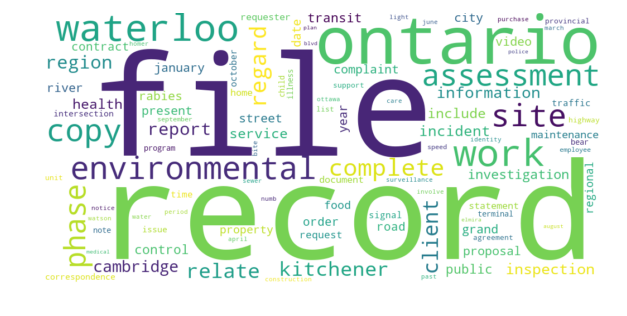

In [102]:
wordcloud4 = WordCloud(
                stopwords=STOPLIST,
                background_color='white',
                width=1000,
                height=500,
                collocations=False,
                max_words=100
            ).generate(" ".join(unigrams_rm))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud4, interpolation="bilinear", aspect='auto')
plt.axis('off')
plt.show()

## Most-used Phrases and Decisions

Looking at the n-grams, one finds phrases that commonly appear throughout the requests:

- "Ontario Works" appears in 8 out of the top 20 n-grams.
- "Environmental site (assessment)" as "Environmental site" or "Site assessment" appears in 11 of the top 20. 

... And those word combinations make up the top 50!

Using bigrams, other few phrases come to light:

- "Grand River Transit" as "Grand River" or "River Transit"
- "Rabies control" or "control investigation"
- "(Public) Health inspection"
- "Food bear" or "bear illness" (Lemmatize version of "Food-borne illness")



Based on these phrases, we try to find if there is a pattern concerning the *Decision*. 

Since we will be working with prepared and processed text, we will just add that cleaned, tokenized, and lemmatized text as a column, called "Edited_Summary" to a new dataframe. 

In [103]:
tokenized_adf = adf.copy()

In [104]:
new_col = []
for index in range(0, len(tokenized_adf)):
    current_line = tokenized_adf['Summary_of_Request'][index]
    for stop in new_stop_words:
        if stop in current_line:
            current_line = current_line.replace(stop, '')
    line_tokens = prepare_text_tlc(current_line)

    rejoined_text =  "".join([" " + i if not i.startswith("'") and i not in string.punctuation 
                              else i for i in line_tokens]).strip()
    new_col.append(rejoined_text)
    
tokenized_adf['Edited_Summary'] = new_col

In [105]:
tokenized_adf.head(5)

Request_Number Request_Type      Source  \
0           99001      General    Business   
1           99002      General    Business   
2           99003      General    Business   
3           99004      General  Individual   
4           99005      General    Business   

                                  Summary_of_Request  \
0  Minutes of Service Delivery Subcommittee of ES...   
1  Public Health inspection reports for the {loca...   
2  Public Health inspection records for {location...   
3  Public Health inspection records for {address ...   
4  Vendor list report with total of year-to-date ...   

                        Decision  \
0  Information disclosed in part   
1      All information disclosed   
2  Information disclosed in part   
3      All information disclosed   
4      All information disclosed   

                                      Edited_Summary  
0  minutes service delivery subcommittee escac pe...  
1  public health inspection report kitchener past...  
2  public health inspection record cambridge past...  
3  public health inspection record cambridge rela...  
4  vendor list report total year date purchase fi...

While looking at the n-grams, we noted that there are few recurrent phrases and its variations:

* 'ontario works', 'complete copy ontario works client file'
* 'environmental site', 'site assessment', 'environmental site assessment'
* 'grand river', 'river transit', 'grand river transit'
* 'public health', 'health inspection', 'public health inspection'
* 'rabies control', 'control investigation', 'rabies control investigation'
* 'food bear', 'bear illness', 'food bear illness'

So, if we are to determine a decision probability based on these phrases, which ones are we going to use?

For the first one, 'ontario works' will encompass most of the requests. For the others, let's find out which phrase represents the majority.



In [521]:
# Arrays to store the 'Request_Number's
s1_array = []
s2_array  = []
s3_array  = []

string1 = 'environmental site'
string2 = 'site assessment'
string3 = 'environmental site assessment'

for index in range(0, len(tokenized_adf)):
    current_line = tokenized_adf['Edited_Summary'][index]
    if string1 in current_line:
        s1_array.append(tokenized_adf['Request_Number'][index])
    if string2 in current_line:
        s2_array.append(tokenized_adf['Request_Number'][index])
    if string3 in current_line:
        s3_array.append(tokenized_adf['Request_Number'][index])

s1_set = set(s1_array) 
s2_set = set(s2_array) 
s3_set = set(s3_array) 

if s1_set != s2_set:
    print("s1 is not equal to s2")
if s2_set != s3_set:
    print("s2 is not equal to s3")
if s1_set != s3_set:
    print("s1 is not equal to s3")
    
diff_set = s1_set.symmetric_difference(s2_set)
    
for index in range(0, len(tokenized_adf)):
    rn = tokenized_adf['Request_Number'][index]
    if rn in diff_set:
        print("Request Number:", rn, "Text:", tokenized_adf['Edited_Summary'][index])


s1 is not equal to s2
s1 is not equal to s3
Request Number: 2016077 Text: record environmental concern regard elmsdale drive include information contain environmental site information index


*'environmental site'* is the one that includes the most requests, so let's use that phrase.

In [517]:
# Arrays to store the 'Request_Number's
s1_array = []
s2_array  = []
s3_array  = []

string1 = 'grand river'
string2 = 'river transit'
string3 = 'grand river transit'

for index in range(0, len(tokenized_adf)):
    current_line = tokenized_adf['Edited_Summary'][index]
    if string1 in current_line:
        s1_array.append(tokenized_adf['Request_Number'][index])
    if string2 in current_line:
        s2_array.append(tokenized_adf['Request_Number'][index])
    if string3 in current_line:
        s3_array.append(tokenized_adf['Request_Number'][index])
        
s1_set = set(s1_array) 
s2_set = set(s2_array) 
s3_set = set(s3_array) 

if s1_set != s2_set:
    print("s1 is not equal to s2")
if s2_set != s3_set:
    print("s2 is not equal to s3")
if s1_set != s3_set:
    print("s1 is not equal to s3")
    
diff_set = s1_set.symmetric_difference(s2_set)
print(diff_set)
    
for index in range(0, len(tokenized_adf)):
    rn = tokenized_adf['Request_Number'][index]
    if rn in diff_set:
        print("Request Number:", rn, "; Text:", tokenized_adf['Edited_Summary'][index])


set()


All options give the same result, so let's use the the full phrase, *'grand river transit'*.

In [523]:
# Arrays to store the 'Request_Number's
s1_array = []
s2_array  = []
s3_array  = []

string1 = 'public health'
string2 = 'health inspection'
string3 = 'public health inspection'


for index in range(0, len(tokenized_adf)):
    current_line = tokenized_adf['Edited_Summary'][index]
    if string1 in current_line:
        s1_array.append(tokenized_adf['Request_Number'][index])
    if string2 in current_line:
        s2_array.append(tokenized_adf['Request_Number'][index])
    if string3 in current_line:
        s3_array.append(tokenized_adf['Request_Number'][index])

        
s1_set = set(s1_array) 
s2_set = set(s2_array) 
s3_set = set(s3_array) 

if s1_set != s2_set:
    print("s1 is not equal to s2")
if s2_set != s3_set:
    print("s2 is not equal to s3")
if s1_set != s3_set:
    print("s1 is not equal to s3")
    
diff_set = s1_set.symmetric_difference(s2_set)
    
#print(diff_set)

for index in range(0, len(tokenized_adf)):
    rn = tokenized_adf['Request_Number'][index]
    if rn in diff_set:
        print("Request Number:", rn, "Text:", tokenized_adf['Edited_Summary'][index])


s1 is not equal to s2
s1 is not equal to s3
Request Number: 2002009 Text: competition file 2002 public health nurse sexual health
Request Number: 2002010 Text: personal information competition file 2002 public health nurse sexual health
Request Number: 2003002 Text: information regard public health nurse staff qualification perform sexual health counsel
Request Number: 2003012 Text: rabies control record incident occur deal halton public health
Request Number: 2006009 Text: public health record regard contamination investigation
Request Number: 2006021 Text: public health investigation record regard kitchener
Request Number: 2007001 Text: public health investigation file regard coli 0157 outbreak requester home care
Request Number: 2007005 Text: public health investigation record regard requester daughter coli 0157 infection home child care operate
Request Number: 2015032 Text: investigation file note natan somer public health inspector regard investigation salmonella poison
Request Nu

*'public health* seems to broaden the topics, so, let's stick to *public health inspection* instead.

In [525]:
# Arrays to store the 'Request_Number's
s1_array = []
s2_array  = []
s3_array  = []

string1 = 'rabies control'
string2 = 'control investigation'
string3 = 'rabies control investigation'

for index in range(0, len(tokenized_adf)):
    current_line = tokenized_adf['Edited_Summary'][index]
    if string1 in current_line:
        s1_array.append(tokenized_adf['Request_Number'][index])
    if string2 in current_line:
        s2_array.append(tokenized_adf['Request_Number'][index])
    if string3 in current_line:
        s3_array.append(tokenized_adf['Request_Number'][index])
        
s1_set = set(s1_array) 
s2_set = set(s2_array) 
s3_set = set(s3_array) 

if s1_set != s2_set:
    print("s1 is not equal to s2")
if s2_set != s3_set:
    print("s2 is not equal to s3")
if s1_set != s3_set:
    print("s1 is not equal to s3")
    
diff_set = s1_set.symmetric_difference(s2_set)
    
print(diff_set)

for index in range(0, len(tokenized_adf)):
    rn = tokenized_adf['Request_Number'][index]
    if rn in diff_set:
        print("Request Number:", rn, "Text:", tokenized_adf['Edited_Summary'][index])



s1 is not equal to s2
s1 is not equal to s3
{2012037, 2003011, 2003012, 99013, 2007023}
Request Number: 99013 Text: rabies control record relate bite affect report bite involve
Request Number: 2003011 Text: rabies control record incident occur january 2003 kitchener
Request Number: 2003012 Text: rabies control record incident occur deal halton public health
Request Number: 2007023 Text: rabies control inspection record involve august 2007
Request Number: 2012037 Text: rabies control inspection record incident occur


Let's use *'rabies control'.

In [526]:
# Arrays to store the 'Request_Number's

s1_array = []
s2_array  = []
s3_array  = []

string1 = 'food bear'
string2 = 'bear illness'
string3 = 'food bear illness'

for index in range(0, len(tokenized_adf)):
    current_line = tokenized_adf['Edited_Summary'][index]
    if string1 in current_line:
        s1_array.append(tokenized_adf['Request_Number'][index])
    if string2 in current_line:
        s2_array.append(tokenized_adf['Request_Number'][index])
    if string3 in current_line:
        s3_array.append(tokenized_adf['Request_Number'][index])
          
s1_set = set(s1_array) 
s2_set = set(s2_array) 
s3_set = set(s3_array) 

if s1_set != s2_set:
    print("s1 is not equal to s2")
if s2_set != s3_set:
    print("s2 is not equal to s3")
if s1_set != s3_set:
    print("s1 is not equal to s3")
    
diff_set = s1_set.symmetric_difference(s2_set)
    
print(diff_set)


for index in range(0, len(tokenized_adf)):
    rn = tokenized_adf['Request_Number'][index]
    if rn in diff_set:
        print("Request Number:", rn, "Text:", tokenized_adf['Edited_Summary'][index])


set()


All sets are the same, so let's use 'food bear illness'.

Now that we know which phrases to use, let's analyze the decisions based on those.

In [106]:
# Looking at acceptance rates based on the following phrases
# 'ontario works'
# 'environmental site'
# 'grand river transit'
# 'rabies control'
# 'public health inspection'
# 'food bear illness'

list_commom_phrases = {'ontario works', 'environmental site', 
                       'grand river transit', 'public health inspection', 
                       'rabies control', 'food bear illness'}


Making a matrix of the number of decisions for each of these phrases,

In [107]:
# Defining the unique decisions as our rows of our new dataframe
counter_rows = np.append(tokenized_adf.Decision.unique(), 'All')

# Starting a dataframe with such rows, and the common phrases as columns. Set initial values of zero
counter_df = pd.DataFrame(0, index=counter_rows, columns=list_commom_phrases)

# Changing values to occurances based on decisions
for index in range(0, len(tokenized_adf)):
    current_line = tokenized_adf['Edited_Summary'][index]
    current_decision = tokenized_adf['Decision'][index]
    for phrase in list_commom_phrases:
        if phrase in current_line:
            counter_df[phrase]['All'] = counter_df[phrase]['All'] + 1
            counter_df[phrase][current_decision] = counter_df[phrase][current_decision] + 1
    
counter_df

grand river transit  public health inspection  \
Information disclosed in part                    4                         8   
All information disclosed                       10                         6   
Request withdrawn                                1                         1   
Partly non-existent                              0                         0   
Transferred                                      0                         0   
No records exist                                 0                         1   
No information disclosed                         0                         0   
Correction refused                               0                         0   
Correction granted                               0                         0   
Abandoned                                        2                         0   
No additional records exist                      0                         0   
All                                             17                        16   

                               food bear illness  rabies control  \
Information disclosed in part                  4              15   
All information disclosed                      7               3   
Request withdrawn                              0               0   
Partly non-existent                            0               0   
Transferred                                    0               1   
No records exist                               1               0   
No information disclosed                       0               0   
Correction refused                             0               0   
Correction granted                             0               0   
Abandoned                                      0               0   
No additional records exist                    0               0   
All                                           12              19   

                               environmental site  ontario works  
Information disclosed in part                   5             31  
All information disclosed                      24             41  
Request withdrawn                              22             10  
Partly non-existent                             7              5  
Transferred                                     0              1  
No records exist                               40             11  
No information disclosed                        0              0  
Correction refused                              0              0  
Correction granted                              0              0  
Abandoned                                       0              3  
No additional records exist                     0              0  
All                                            98            102

In [110]:
# Total number of requests with this phrases
total_w_phrases = counter_df[11:12].sum(axis=1)

What fraction of entries have these phrases?

In [111]:
total_w_phrases/tokenized_adf.shape[0]

All    0.458333
dtype: float64

So, 46% of the requests made over 18 years involve one of the following phrases: 'ontario works', 'environmental site', 'grand river transit', 'public health inspection', 'rabies control', or 'food bear illness'. 

In order to normalize the results, we should remove the "All" column.

In [112]:
counter_df_Dec = counter_df.drop('All')

In [113]:
counter_df_Dec_byDecision = counter_df_Dec.div(counter_df_Dec.sum(axis=0), axis=1)
counter_df_Dec_byDecision

grand river transit  public health inspection  \
Information disclosed in part             0.235294                    0.5000   
All information disclosed                 0.588235                    0.3750   
Request withdrawn                         0.058824                    0.0625   
Partly non-existent                       0.000000                    0.0000   
Transferred                               0.000000                    0.0000   
No records exist                          0.000000                    0.0625   
No information disclosed                  0.000000                    0.0000   
Correction refused                        0.000000                    0.0000   
Correction granted                        0.000000                    0.0000   
Abandoned                                 0.117647                    0.0000   
No additional records exist               0.000000                    0.0000   

                               food bear illness  rabies control  \
Information disclosed in part           0.333333        0.789474   
All information disclosed               0.583333        0.157895   
Request withdrawn                       0.000000        0.000000   
Partly non-existent                     0.000000        0.000000   
Transferred                             0.000000        0.052632   
No records exist                        0.083333        0.000000   
No information disclosed                0.000000        0.000000   
Correction refused                      0.000000        0.000000   
Correction granted                      0.000000        0.000000   
Abandoned                               0.000000        0.000000   
No additional records exist             0.000000        0.000000   

                               environmental site  ontario works  
Information disclosed in part            0.051020       0.303922  
All information disclosed                0.244898       0.401961  
Request withdrawn                        0.224490       0.098039  
Partly non-existent                      0.071429       0.049020  
Transferred                              0.000000       0.009804  
No records exist                         0.408163       0.107843  
No information disclosed                 0.000000       0.000000  
Correction refused                       0.000000       0.000000  
Correction granted                       0.000000       0.000000  
Abandoned                                0.000000       0.029412  
No additional records exist              0.000000       0.000000

Now we can make a plot of the results.

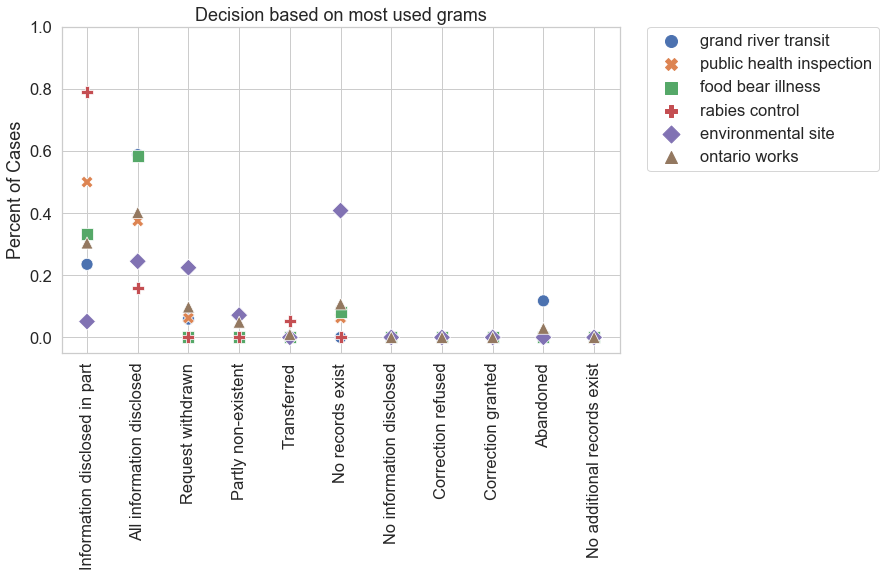

In [114]:
plt.figure(figsize=(10, 6))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 3.5, "lines.markersize": 12.0})
ax = sns.scatterplot(data=counter_df_Dec_byDecision, markers=True)
ax.set(ylabel='Percent of Cases', title='Decision based on most used grams', ylim=(-0.05, 1))
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

And to make the results clearer, we remove the zero values. We do this by replacing them with 'NaN' values, since seaborn would not plot those points.

In [1034]:
nan_counter_df = counter_df_Dec_byDecision.copy()

In [1035]:
nan_counter_df = nan_counter_df.replace(0.0, 'NaN')

In [1036]:
nan_counter_df

food bear illness environmental site  \
Information disclosed in part          0.333333          0.0510204   
All information disclosed              0.583333           0.244898   
Request withdrawn                           NaN            0.22449   
Partly non-existent                         NaN          0.0714286   
Transferred                                 NaN                NaN   
No records exist                      0.0833333           0.408163   
No information disclosed                    NaN                NaN   
Correction refused                          NaN                NaN   
Correction granted                          NaN                NaN   
Abandoned                                   NaN                NaN   
No additional records exist                 NaN                NaN   

                              ontario works grand river transit  \
Information disclosed in part      0.303922            0.235294   
All information disclosed          0.401961            0.588235   
Request withdrawn                 0.0980392           0.0588235   
Partly non-existent               0.0490196                 NaN   
Transferred                      0.00980392                 NaN   
No records exist                   0.107843                 NaN   
No information disclosed                NaN                 NaN   
Correction refused                      NaN                 NaN   
Correction granted                      NaN                 NaN   
Abandoned                         0.0294118            0.117647   
No additional records exist             NaN                 NaN   

                              rabies control public health inspection  
Information disclosed in part       0.789474                      0.5  
All information disclosed           0.157895                    0.375  
Request withdrawn                        NaN                   0.0625  
Partly non-existent                      NaN                      NaN  
Transferred                        0.0526316                      NaN  
No records exist                         NaN                   0.0625  
No information disclosed                 NaN                      NaN  
Correction refused                       NaN                      NaN  
Correction granted                       NaN                      NaN  
Abandoned                                NaN                      NaN  
No additional records exist              NaN                      NaN

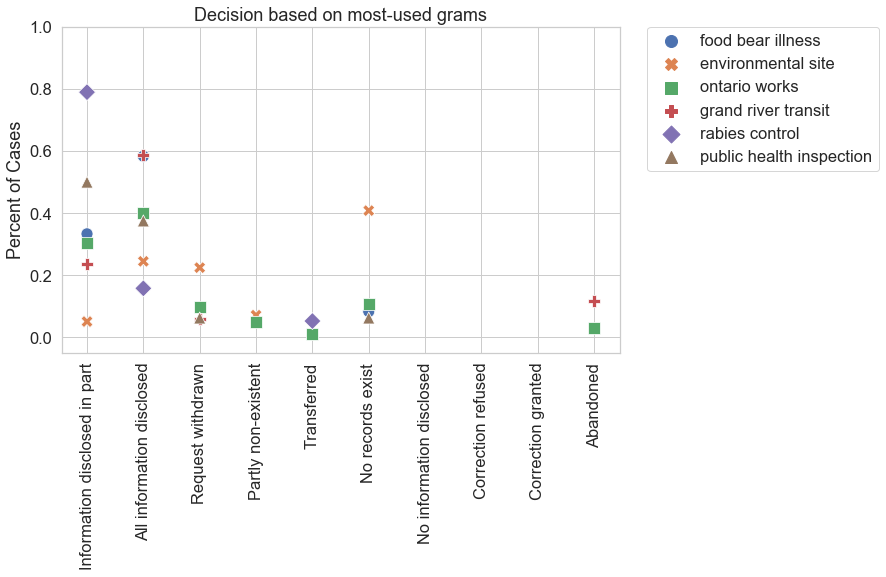

In [1037]:
plt.figure(figsize=(10, 6))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 3.5, "lines.markersize": 12.0})
ax1 = sns.scatterplot(data = nan_counter_df, markers=True)
ax1.set(ylabel='Percent of Cases', title='Decision based on most-used grams', ylim=(-0.05, 1))
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [542]:
dash_counter_perc_df  = counter_df_Dec.div(counter_df_Dec.sum(axis=0)/100, axis=1).round(decimals=2)

In [544]:
dash_counter_perc_df = dash_counter_perc_df.replace(0.0, '--')

In [545]:
dash_counter_perc_df

food bear illness environmental site  \
Information disclosed in part             33.33                5.1   
All information disclosed                 58.33              24.49   
Request withdrawn                            --              22.45   
Partly non-existent                          --               7.14   
Transferred                                  --                 --   
No records exist                           8.33              40.82   
No information disclosed                     --                 --   
Correction refused                           --                 --   
Correction granted                           --                 --   
Abandoned                                    --                 --   
No additional records exist                  --                 --   

                              ontario works grand river transit  \
Information disclosed in part         30.39               23.53   
All information disclosed              40.2               58.82   
Request withdrawn                       9.8                5.88   
Partly non-existent                     4.9                  --   
Transferred                            0.98                  --   
No records exist                      10.78                  --   
No information disclosed                 --                  --   
Correction refused                       --                  --   
Correction granted                       --                  --   
Abandoned                              2.94               11.76   
No additional records exist              --                  --   

                              rabies control public health inspection  
Information disclosed in part          78.95                       50  
All information disclosed              15.79                     37.5  
Request withdrawn                         --                     6.25  
Partly non-existent                       --                       --  
Transferred                             5.26                       --  
No records exist                          --                     6.25  
No information disclosed                  --                       --  
Correction refused                        --                       --  
Correction granted                        --                       --  
Abandoned                                 --                       --  
No additional records exist               --                       --

It is interesting to note that none of these phrases got a single "No information disclosed" decision. In summary, 46% of all of our data contains these phrases, and of those phrases,

- *"Food bear illness"*: 92% of the cases got full or partial information disclosed, with 8% where no information exists.
- *"Environmental site"*: there was no information for 41% of the cases, for 22% of the cases the request was withdrawn. Full or partial information was given to 30%, while the remaining 7% had partially non-existent information.  
- *"Ontario Works"*: 70% got full or partial information disclosed, 13% of the cases were abandoned or withdrawn, information did not exist for 11%, while 5% had only partial existing information, and 1% gor transferred.
- *"Grand River Transit"*: 82% of cases got a full or partial information disclosed, while 18% of the cases were abandoned or withdrawn.
- *"Rabies control"* got about 95% with all or partially information disclosed, and 5% of the cases were tranferred.
- *"Public health Inspection"*: 88% got full or partial information disclosed, 6% had no records, and 6% of the requests were withdrawn. 

## *Summary_of_Request* Statistics

It is be also interesting to see with how much data our ML algorith would be working. This is, what is the length of those "Summary_of_Request". Remember we don't get the full version submitted for review, but the summary made by the clerk. 

First, let's examine the full text we obtained directly from the files.

In [119]:
num_chars = []
num_words = []
counter = 0

for index in range(0, len(all_text)):
    chars_num = len(all_text[index])
    words_num = len(parser(all_text[index]))
    num_chars.append(chars_num)
    num_words.append(words_num)
    if words_num > 100:
        counter += 1
        print(all_text[index])
        #print(parser(all_text[index]))
        print("Number of characters: %d" % chars_num)
        number_words = parser(all_text[index])
        print("Number of words: %d \n" % words_num)
print("Total number of entries with more than 100 words: ", counter)


1. A copy of the successful proposal in response to the RFP C2014-39 for Tender Preparation, Contract Administration and Construction Inspection Services for the Construction of the Waterloo Spur Line Trail from Regina Street in the City of Waterloo to Ahrens Street in the City of Kitchener issued by the Regional Municipality of Waterloo on October 15, 2014.� Please exclude any promotional material that may have been submitted with the proposal and may be considered proprietary. 2. The total number of submissions and the dollar value of the top three submissions for RFP C2014-39.
Number of characters: 586
Number of words: 106 

1) Records for the past two years up to most current for the inspection, testing and maintaining of the traffic control signal system sub-systems at the intersection of Homer Watson Blvd. and Ottawa St. pursuant to "ONTARIO REGULATION 239/02 MINIMUM MAINTENANCE STANDARDS FOR MUNICIPAL HIGHWAYS", section 14 subsection (1).  2) Records for the past two years up to

Average number of words per request is 20.491319, while the median is 15.000000


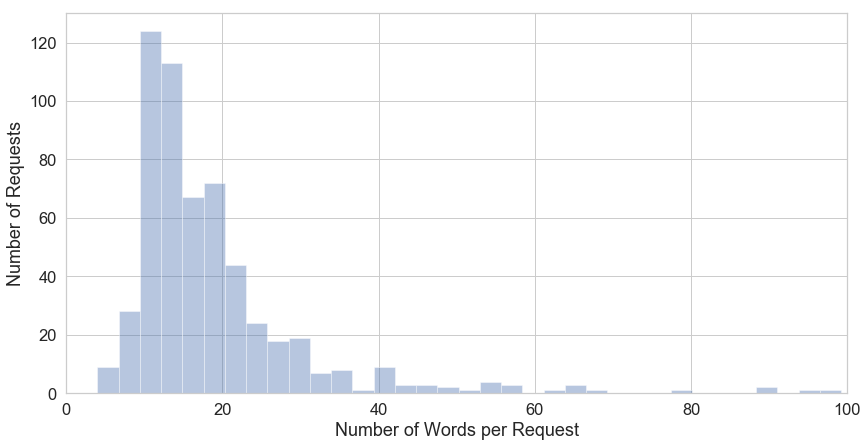

In [120]:
np_num_words = np.array(num_words)
mean_words = np_num_words.mean()
median_words = np.median(num_words)

plt.figure(figsize=(14, 7))
plt.xlim(0, 100)
plt.xlabel('Number of Words per Request')
plt.ylabel('Number of Requests')
sns.distplot(num_words, bins=100, kde=False)

print("Average number of words per request is %f, while the median is %f" %(mean_words, median_words))


As for the tokenized version of it:

In [121]:
all_text_tokenized = tokenized_adf['Edited_Summary']

In [547]:
# Merging all the requests into a single line
all_text_tokenized_merged = ''

for lines in range(0, len(all_text_tokenized)):
    all_text_tokenized_merged = all_text_tokenized_merged + ' ' + all_text_tokenized[lines]
    
#all_text_tokenized_merged
# typos: phase environemntal site assesment 

In [549]:
num_chars_t = []
num_words_t = []
small_req = []
counter = 0
counter_sm = 0

for index in range(0, len(all_text_tokenized)):
    chars_num_t = len(all_text_tokenized[index])
    words_num_t = len(parser(all_text_tokenized[index]))
    num_chars_t.append(chars_num_t)
    num_words_t.append(words_num_t)
    if words_num_t > 100:
        counter += 1
        print(all_text_tokenized[index])
        print("Number of characters: %d" % chars_num_t)
        number_words = parser(all_text_tokenized[index])
        print("Number of words: %d \n" % words_num_t)
    if words_num_t < 6:
        small_req.append(all_text_tokenized[index])
        counter_sm += 1
        
print("Total number of entries with more than 100 words: ", counter)
print("Total number of entries with less than 6 words: %d, which is %0.1f%% of the total number of requests" 
      %(counter_sm, (100.*counter_sm / len(all_text_tokenized))))


records past year current inspection test maintain traffic control signal intersection homer watson blvd ottawa pursuant ontario regulation 239/02 minimum maintenance standards municipal highways section subsection records past year current inspection test maintain conflict monitor(s intersection homer watson blvd ottawa pursuant ontario regulation 239/02 minimum maintenance standards municipal highways section subsection records past year current inspection test maintenance light camera intersection homer watson blvd ottawa records past year current year corrective maintenance need place traffic control signal intersection homer watson blvd ottawa records past year current year corrective maintenance need place conflict monitor(s intersection homer watson blvd ottawa records past year current year corrective maintenance need place light camera intersection homer watson blvd ottawa
Number of characters: 894
Number of words: 114 

Total number of entries with more than 100 words:  1
Tot

Average number of words per request is 9.338542, while the median is 7.000000


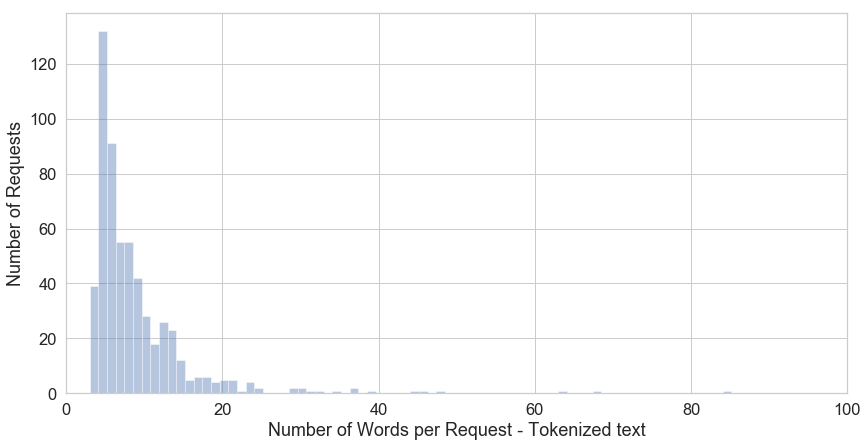

In [124]:
np_num_words_t = np.array(num_words_t)
mean_words_t = np_num_words_t.mean()
median_words_t = np.median(num_words_t)

plt.figure(figsize=(14, 7))
plt.xlim(0, 100)
plt.xlabel('Number of Words per Request - Tokenized text')
plt.ylabel('Number of Requests')
sns.distplot(num_words_t, bins=100, kde=False)

print("Average number of words per request is %f, while the median is %f" %(mean_words_t, median_words_t))


Seven words (7!), the median, is not much with which to work...

30% of the requests have 5 words or less. They are listed below.

In [125]:
small_req

['records relate complaint cambridge',
 'personnel file period 1990/10/01 1999/10/31',
 'phase environmental site assessment kitchener',
 'home child care provider file',
 'identity owner close restaurant',
 'proposals pride network p2002',
 'contracts payment make region waterloo',
 'records mould growth home kitchener',
 'results tender t2003 carpet replacement',
 'records regard municipal regulation pesticide',
 'analysis sewage composition cambridge 2003',
 'email send cupe member refer',
 'record correspondence ontario works file',
 'rabies control investigation file',
 'social worker client file pertain',
 'phase environmental site assessment elmira',
 'phase environmental site assessment elmira',
 'phase environmental site assessment elmira',
 'phase environmental site assessment cambridge',
 'employee file attendance datum',
 'phase environmental site assessment cambridge',
 'record regard hepatitis outbreak waterloo',
 'rabies control investigation file',
 'phase environmental

In [126]:
df_small_req = pd.DataFrame({'Tokenized_Requests_lt_6': small_req})


Of those 171 *small requests*, some are the same type of requests. We break down the number and phases below. We only show those with more than 2 cases. 

In [127]:
#df_small_req['Tokenized_Requests_lt_6'].unique()
print("Number of unique values: ", df_small_req['Tokenized_Requests_lt_6'].nunique())
df_small_req['Tokenized_Requests_lt_6'].value_counts().head(12)


Number of unique values:  62


phase environmental site assessment kitchener    30
phase environmental site assessment waterloo     22
phase environmental site assessment cambridge    22
complete copy ontario works file                 21
complete ontario works file                       7
phase environmental site assessment elmira        6
rabies control investigation file                 4
phase environmental site assessment               3
2416 outside video footage 2:00                   2
copy complete ontario works file                  2
rabies control investigation record               1
incident report involve individual                1
Name: Tokenized_Requests_lt_6, dtype: int64

## POS Tagging

How about tag types? For this we will use spaCy.

One can do the analysis including empty spaces and punctuation. Instead, I chose to remove them first, therefore, we need to tokenize the text and then remove unwanted characters and symbols.  


However, the *nlp( )* function of spaCy, the one that will provide the tags, requires a string. We will need to stitch back together the tokens.

In [873]:
# Tokenizing text, while removing symbols
full_text_tok = tokenize_rmSym_Text(all_text_merged)

# Merging all the tokens into a single line
full_text = ''

for words in range(0, len(full_text_tok)):
    full_text = full_text + ' ' + full_text_tok[words]


In [940]:
full_text_nlp = nlp(full_text)    # spaCy nlp()

tags = []    # Array where the spacy tags will be stored

for token in full_text_nlp:
    tags.append(token.tag_)

tags_df = pd.DataFrame(data = tags, columns=['Tags'])

print("Number of unique tag values: ", tags_df['Tags'].nunique())
print("Total number of words: ", len(tags_df['Tags']))

# Make a dataframe out of unique values
tags_value_counts = tags_df['Tags'].value_counts(dropna=True, sort=True)
tags_value_counts_df = tags_value_counts.rename_axis('Unique_Values').reset_index(name='Counts')

# And normalizing the count values
tags_value_counts_df['Normalized_Count'] = tags_value_counts_df['Counts'] / len(tags_df['Tags'])

tags_value_counts_df.head(10)

#spacy.explain(tags_value_counts_df['Unique_Values'][0])

Number of unique tag values:  37
Total number of words:  9875


Unique_Values  Counts  Normalized_Count
0            NN    3465          0.350886
1            IN    1615          0.163544
2            JJ     863          0.087392
3           NNS     857          0.086785
4            DT     590          0.059747
5            CD     582          0.058937
6           VBN     433          0.043848
7            CC     365          0.036962
8           VBG     243          0.024608
9           NNP     156          0.015797

Now, for those who can't remember what all of those tags mean, let's add the explanation as a new column called "Decoded" by using spacy's function *explain()*.

In [941]:
uv_decoded = []

for val in tags_value_counts_df['Unique_Values']:
    uv_decoded.append(spacy.explain(val))

tags_value_counts_df['Decoded'] = uv_decoded
tags_value_counts_df

Unique_Values  Counts  Normalized_Count  \
0             NN    3465          0.350886   
1             IN    1615          0.163544   
2             JJ     863          0.087392   
3            NNS     857          0.086785   
4             DT     590          0.059747   
5             CD     582          0.058937   
6            VBN     433          0.043848   
7             CC     365          0.036962   
8            VBG     243          0.024608   
9            NNP     156          0.015797   
10           VBD     118          0.011949   
11            VB     103          0.010430   
12           PRP     101          0.010228   
13            TO      77          0.007797   
14            RB      59          0.005975   
15           VBP      59          0.005975   
16           VBZ      35          0.003544   
17           WDT      35          0.003544   
18             .      27          0.002734   
19           POS      22          0.002228   
20            MD      21          0.002127   
21           WRB       8          0.000810   
22            RP       7          0.000709   
23          PRP$       7          0.000709   
24           RBS       4          0.000405   
25           JJS       4          0.000405   
26            FW       3          0.000304   
27           AFX       3          0.000304   
28            WP       3          0.000304   
29            UH       2          0.000203   
30            EX       2          0.000203   
31           JJR       1          0.000101   
32            XX       1          0.000101   
33           PDT       1          0.000101   
34            ''       1          0.000101   
35            LS       1          0.000101   
36                     1          0.000101   

                                      Decoded  
0                      noun, singular or mass  
1   conjunction, subordinating or preposition  
2                                   adjective  
3                                noun, plural  
4                                  determiner  
5                             cardinal number  
6                       verb, past participle  
7                   conjunction, coordinating  
8          verb, gerund or present participle  
9                       noun, proper singular  
10                           verb, past tense  
11                            verb, base form  
12                          pronoun, personal  
13                             infinitival to  
14                                     adverb  
15      verb, non-3rd person singular present  
16          verb, 3rd person singular present  
17                              wh-determiner  
18          punctuation mark, sentence closer  
19                          possessive ending  
20                      verb, modal auxiliary  
21                                  wh-adverb  
22                           adverb, particle  
23                        pronoun, possessive  
24                        adverb, superlative  
25                     adjective, superlative  
26                               foreign word  
27                                      affix  
28                       wh-pronoun, personal  
29                               interjection  
30                          existential there  
31                     adjective, comparative  
32                                    unknown  
33                              predeterminer  
34                     closing quotation mark  
35                           list item marker  
36                                       None

Given the range of values, it does not make much sense to plot anything under 20 occurances.

In [942]:
tags_value_counts_df_gt20 = tags_value_counts_df[tags_value_counts_df['Counts'] > 20]

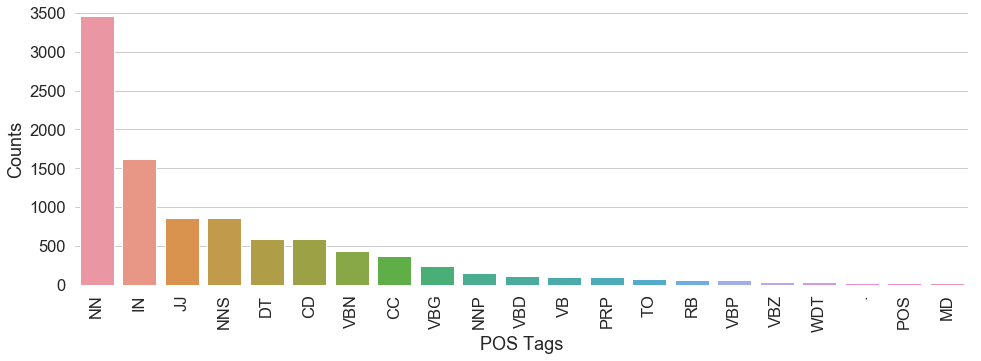

In [943]:
categ = list(tags_value_counts_df_gt20['Unique_Values'])

f, ax = plt.subplots(figsize=(16, 5))

sns.set_color_codes('dark')
sns.barplot(y=tags_value_counts_df_gt20['Counts'], x=categ)
ax.set(xlabel="POS Tags", ylim=(0, 3500), ylabel="Counts")
plt.xticks(rotation=90)
sns.despine(left=True, bottom=True)

And to be more explicit, let's write the descriptions instead.

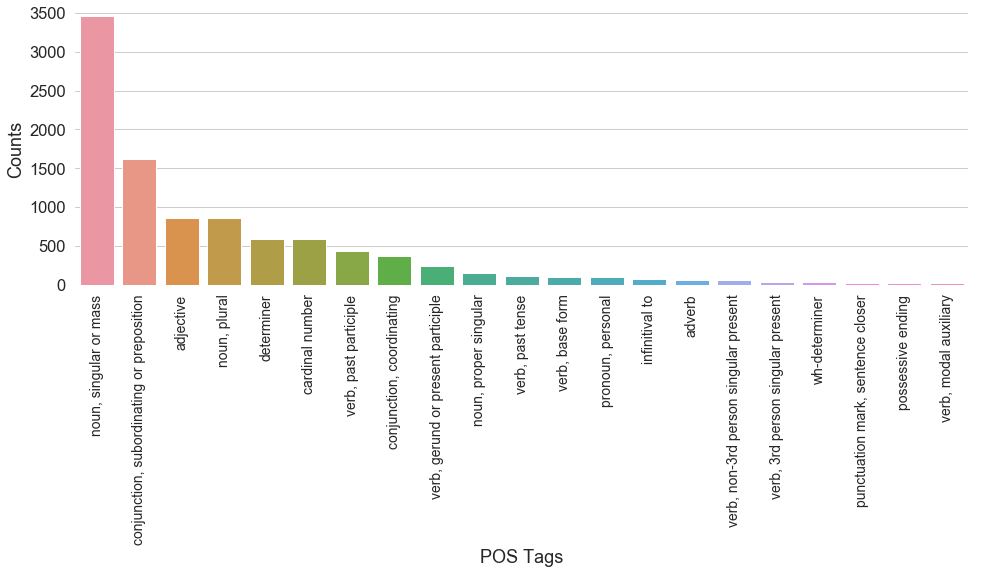

In [944]:
categ = list(tags_value_counts_df_gt20['Decoded'])

f, ax = plt.subplots(figsize=(16, 5))

sns.set_color_codes('dark')
sns.barplot(y=tags_value_counts_df_gt20['Counts'], x=categ)
ax.set(xlabel="POS Tags", ylim=(0, 3500), ylabel="Counts")
plt.xticks(rotation=90, fontsize=14)
sns.despine(left=True, bottom=True)

And with normalized values,

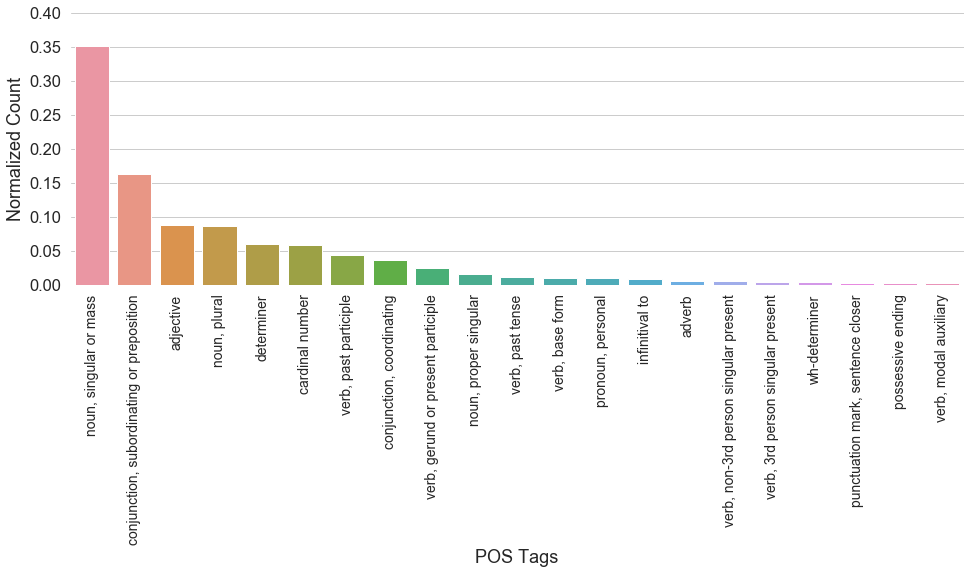

In [1040]:
categ = list(tags_value_counts_df_gt20['Decoded'])

f, ax = plt.subplots(figsize=(16, 5))

sns.set_color_codes('dark')
sns.barplot(y=tags_value_counts_df_gt20['Normalized_Count'], x=categ)
ax.set(xlabel="POS Tags", ylim=(0, 0.4), ylabel="Normalized Count")
plt.xticks(rotation=90, fontsize=14)
sns.despine(left=True, bottom=True)

It is interesting to see how much text is composed of nouns (singular, plural,...), verbs (present, past,...), numbers, conjunctions, pronouns, adverbs, and adjectives.

In [985]:
pos_types = ['noun', 'pronoun', 'verb', 'adjective', 'adverb', 'conjunction', 'cardinal']

tag_tag = []
tag_count = []
tag_percent = []

for tag in pos_types:
    # Adding the columns that fit the constraint
    tag_array = tags_value_counts_df[(tags_value_counts_df['Decoded'].str.startswith(tag, na=False))].sum(axis=0)
    tag_tag.append(tag)
    # tag_array: [0]=Unique_Values, [1]=Counts, [2]=Normalized_Count, [3]=Decoded
    tag_count.append(tag_array[1])
    tag_percent.append(tag_array[2])
    
#print(tag_count)

d = {'Tags':tag_tag, 'Counts':tag_count, 'Normalized_Count':tag_percent}

tags_df = pd.DataFrame(d)
tags_df = tags_df.sort_values(by='Counts', ascending=False)
tags_df

Counts  Normalized_Count         Tags
0    4478          0.453468         noun
5    1980          0.200506  conjunction
2    1012          0.102481         verb
3     868          0.087899    adjective
6     582          0.058937     cardinal
1     108          0.010937      pronoun
4      70          0.007089       adverb

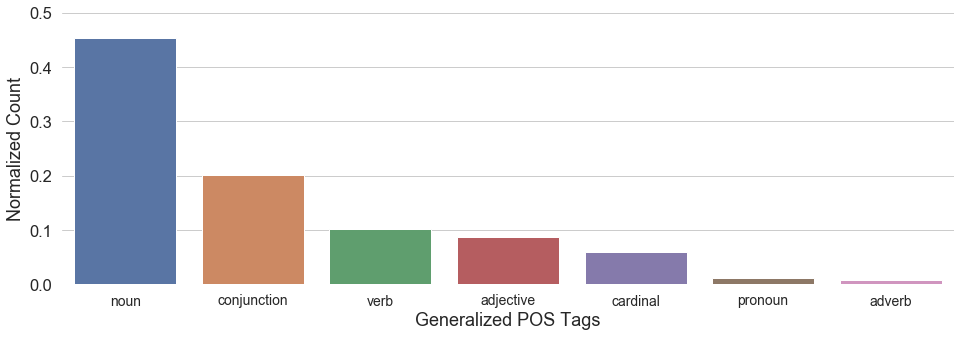

In [1044]:
categ = list(tags_df['Tags'])

f, ax = plt.subplots(figsize=(16, 5))

sns.set_color_codes('dark')
sns.barplot(y=tags_df['Normalized_Count'], x=categ)
ax.set(xlabel="Generalized POS Tags", ylim=(0, 0.5), ylabel="Normalized Count")
plt.xticks(rotation=0, fontsize=14)
sns.despine(left=True, bottom=True)

In summary, our corpus includes 45% nouns, 20% conjunctions, 10% verbs, 9% adjectives, 6% numbers, 1% pronouns, among others (9%).

## LSA and LDA Analysis using Bokeh, scikit-learn, and t-SNE

Following Susan Li's posts. We present here LSA and LDA analysis of the text.

In [252]:
from sklearn.manifold import TSNE

In [248]:
# LSA
from sklearn.decomposition import TruncatedSVD

In [552]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation

In [256]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()
from bokeh.models import Range1d

Loading BokehJS ...

In [1105]:
import matplotlib.patheffects as path_effects

In [1093]:
# Susan Li's predefined functions

def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)
    
def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:, index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(", ".join(topic_words))         
    return top_words

def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        reviews_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                reviews_in_that_topic.append(two_dim_vectors[i])    
        
        reviews_in_that_topic = np.vstack(reviews_in_that_topic)
        mean_review_in_that_topic = np.mean(reviews_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_review_in_that_topic)
    return mean_topic_vectors

def get_median_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of median-centroid vectors from each predicted topic category
    '''
    median_topic_vectors = []
    for t in range(n_topics):
        reviews_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                reviews_in_that_topic.append(two_dim_vectors[i])    
        
        reviews_in_that_topic = np.vstack(reviews_in_that_topic)
        median_review_in_that_topic = np.median(reviews_in_that_topic, axis=0)
        median_topic_vectors.append(median_review_in_that_topic)
    return median_topic_vectors

In [1094]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

## Preprocessing text for LDA and LSA, using tf-idf vectorizer

In [1102]:
reindexed_data = tokenized_adf['Edited_Summary']    # Edited_Summary is tokenized, lemmatized, and without symbols and stopwords
tfidf_vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True)
reindexed_data = reindexed_data.values
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)


## LSA - scikit-learn - tf-idf vectorizer

Of the 10 topics found, five of the previously six discussed common phrases are included, except for *"Public Health Inspection"*.


Topic 1:  works, ontario, file, complete
Topic 2:  phase, assessment, site, environmental
Topic 3:  record, regard, relate, waterloo
Topic 4:  kitchener, mould, 2003, street
Topic 5:  rabies, investigation, control, file
Topic 6:  cambridge, records, vicinity, relate
Topic 7:  health, public, milk, sell
Topic 8:  transit, grand, river, video
Topic 9:  food, illness, bear, investigation
Topic 10:  child, care, home, provider


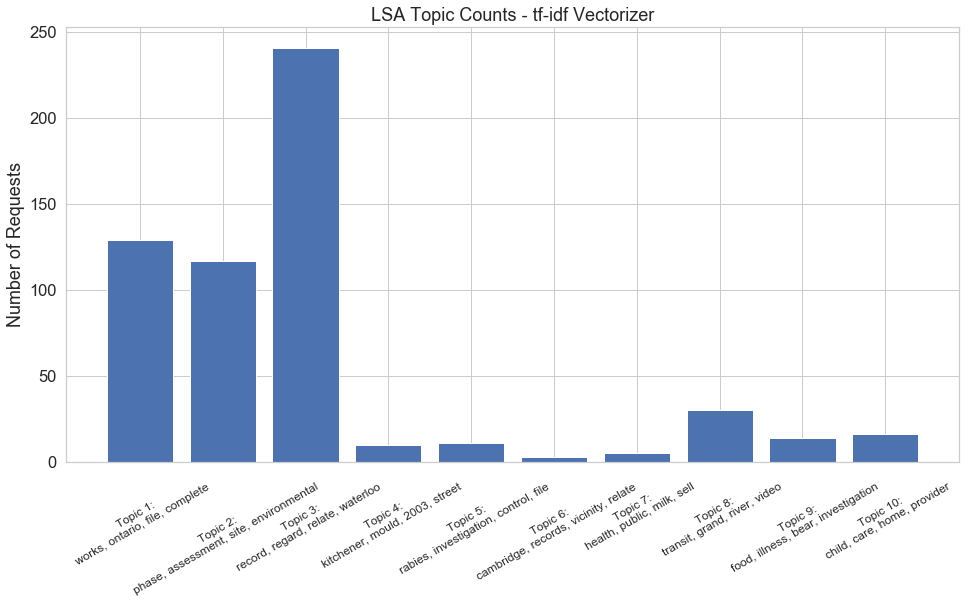

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 576 samples in 0.001s...
[t-SNE] Computed neighbors for 576 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 576 / 576
[t-SNE] Mean sigma: 0.090932
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.772839
[t-SNE] KL divergence after 2000 iterations: 0.330207


In [1119]:
n_topics = 10
lsa_model = TruncatedSVD(n_components=n_topics, random_state=42)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)
top_n_words_lsa = get_top_n_words(4, lsa_keys, document_term_matrix, tfidf_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i + 1), top_n_words_lsa[i])
    
# Plotting
labels = ['Topic {}: \n'.format(i + 1) + top_n_words_lsa[i] for i in lsa_categories]
fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of Requests');
ax.set_title('LSA Topic Counts - tf-idf Vectorizer');
plt.xticks(rotation=30, fontsize=12)
plt.show();

#Bokeh and t-SNE
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=42, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

top_4_words_lsa = get_top_n_words(4, lsa_keys, document_term_matrix, tfidf_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics - tf-idf Vectorizer".format(n_topics), 
              plot_width=700, plot_height=700, x_range=[-30,50])

plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_4_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

While there seems to be defined clusters for *food bear illness*, *rabies*, *ontario works*, and *environmental site*, these last two also overlap with the *record regard relate waterloo* topic, which is also overlaps with the other topics. 

## LDA - scikit learn - tf-idf vectorizer

Of the 10 topics found, LDA found four of the previously six discussed common phrases are included, except for *"Grand River Transit"* and *food bear illness*.

Topic 1:  relate, policy, environmentally, sensitive
Topic 2:  health, public, inspection, food
Topic 3:  service, winning, blueprinting, file
Topic 4:  phase, site, assessment, environmental
Topic 5:  water, 000, refer, maintenance
Topic 6:  speed, 2013, charge, regard
Topic 7:  record, waterloo, signal, street
Topic 8:  works, complete, ontario, file
Topic 9:  rabies, control, investigation, record
Topic 10:  identity, report, application, include


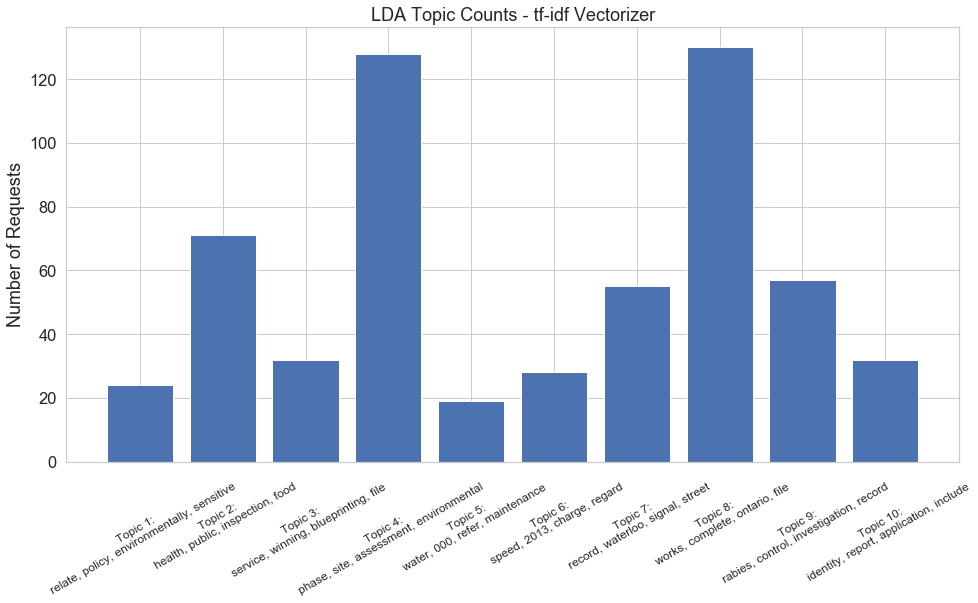

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 576 samples in 0.001s...
[t-SNE] Computed neighbors for 576 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 576 / 576
[t-SNE] Mean sigma: 0.001239
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.165726
[t-SNE] KL divergence after 2000 iterations: 0.174454


In [1085]:
n_topics = 10
lda_model_sk = LatentDirichletAllocation(n_components=n_topics, 
                                         random_state=42, verbose=0)
lda_topic_matrix_sk = lda_model_sk.fit_transform(document_term_matrix)

lda_keys = get_keys(lda_topic_matrix_sk)
lda_categories, lda_counts = keys_to_counts(lda_keys)
top_n_words_lda = get_top_n_words(4, lda_keys, document_term_matrix, tfidf_vectorizer)


for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i + 1), top_n_words_lda[i])
    
labels = ['Topic {}: \n'.format(i + 1) + top_n_words_lda[i] for i in lda_categories]
fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of Requests');
ax.set_title('LDA Topic Counts - tf-idf Vectorizer');
plt.xticks(rotation=30, fontsize=12)
plt.show();


# Bokeh and t-SNE
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=42, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix_sk)

top_4_words_lda = get_top_n_words(4, lda_keys, document_term_matrix, tfidf_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics - tf-idf Vectorizer".format(n_topics), 
              plot_width=700, plot_height=700, x_range=[-30,50])

plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_4_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

t-SNE for LDA with tf-idf provides more defined clusters compared to LSA. 

## Preprocessing text for LDA and LSA, using CountVectorizer

This time, let's use a CountVectorizer.

In [1090]:
reindexed_data = tokenized_adf['Edited_Summary']
count_vectorizer = CountVectorizer(ngram_range=(1, 5))
reindexed_data = reindexed_data.values
document_term_matrix = count_vectorizer.fit_transform(reindexed_data)

## LSA - scikit learn - CountVectorizer

It seems like LSA + CountVectorizer does not give better results. It did find three of the topics, but t-SNE gives overlapping clusters and the top topics include bigrams, too. And while the words *Waterloo* and *Kitchener* are present in many requests, as expected, it is probably not a good idea for those to be topics themselves.

Topic 1:  year, records, homer, homer watson
Topic 2:  file, ontario, works, ontario works
Topic 3:  environmental, site, assessment, phase
Topic 4:  terminal, guardrail terminal, guardrail, waterloo
Topic 5:  centre, waterloo city centre, city, waterloo city
Topic 6:  transit, river transit, river, grand river transit
Topic 7:  signal, january, traffic, intersection
Topic 8:  record, waterloo, regard, relate
Topic 9:  numb, total, park, 2014
Topic 10:  kitchener, january, street, street south kitchener


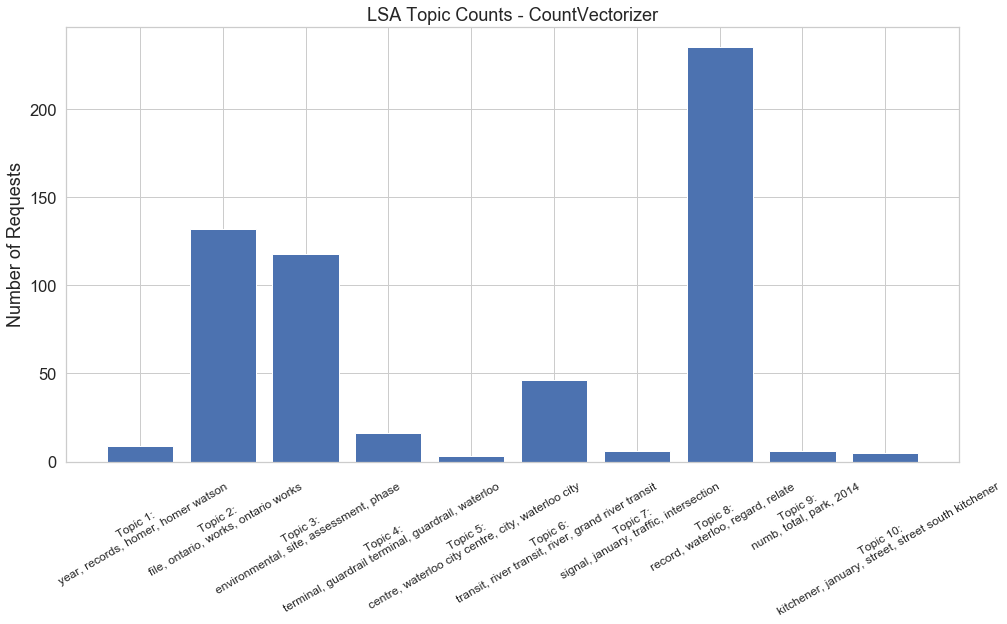

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 576 samples in 0.000s...
[t-SNE] Computed neighbors for 576 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 576 / 576
[t-SNE] Mean sigma: 0.236402
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.945583
[t-SNE] KL divergence after 1800 iterations: 0.282286


In [1091]:
n_topics = 10
lsa_model = TruncatedSVD(n_components=n_topics, random_state=42)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)
top_n_words_lsa = get_top_n_words(4, lsa_keys, document_term_matrix, count_vectorizer)

#print(len(top_n_words_lsa))

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i + 1), top_n_words_lsa[i])
    
top_4_words = get_top_n_words(4, lsa_keys, document_term_matrix, count_vectorizer)
labels = ['Topic {}: \n'.format(i + 1) + top_4_words[i] for i in lsa_categories]
fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of Requests');
ax.set_title('LSA Topic Counts - CountVectorizer');
plt.xticks(rotation=30, fontsize=12)
plt.show();

#Bokeh and t-SNE
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=42, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics - CountVectorizer".format(n_topics), plot_width=700, plot_height=700, 
              x_range=[-20,50], y_range=[-20,40])

plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_n_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

## LDA - scikit learn - CountVectorizer

While t-DNE gives more defined clusters for LSA + CountVectorizer, it is obvious by looking at the topics that this is not a good model for our data.

Topic 1:  regard, file, record, health
Topic 2:  waterloo, region, region waterloo, record
Topic 3:  record, regard, relate, file
Topic 4:  relate, record, waterloo, region
Topic 5:  environmental, environmental site, assessment, phase
Topic 6:  include, terminal, guardrail, guardrail terminal
Topic 7:  regard, record, waterloo, relate
Topic 8:  waterloo, file, relate, maintenance
Topic 9:  transit, incident, relate, record
Topic 10:  file, ontario, ontario works, works


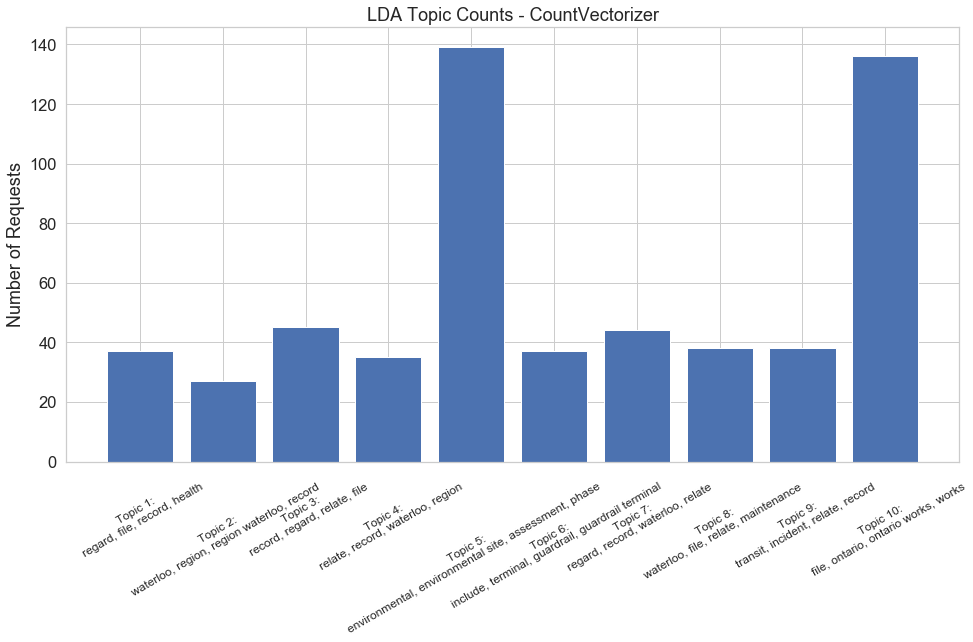

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 576 samples in 0.000s...
[t-SNE] Computed neighbors for 576 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 576 / 576
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.079788
[t-SNE] KL divergence after 2000 iterations: 0.070793


In [1082]:
n_topics = 10
lda_model_sk = LatentDirichletAllocation(n_components=n_topics, 
                                         random_state=42, verbose=0)
lda_topic_matrix_sk = lda_model_sk.fit_transform(document_term_matrix)

lda_keys = get_keys(lda_topic_matrix_sk)
lda_categories, lda_counts = keys_to_counts(lda_keys)
top_n_words_lda = get_top_n_words(4, lda_keys, document_term_matrix, count_vectorizer)


for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i + 1), top_n_words_lda[i])
    
top_4_words = get_top_n_words(4, lda_keys, document_term_matrix, count_vectorizer)
labels = ['Topic {}: \n'.format(i + 1) + top_4_words[i] for i in lda_categories]
fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of Requests');
ax.set_title('LDA Topic Counts - CountVectorizer');
plt.xticks(rotation=30, fontsize=12)
plt.show();

# Bokeh and t-SNE
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=42, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix_sk)

lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics - CountVectorizer".format(n_topics), 
              plot_width=700, plot_height=700, x_range=[-30,50])

plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_n_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

## LDA Analysis using Gensim and pyLDAvis

### Gensim
Another tool for LDA analysis is gensim, an open-source library for unsupervised topic modeling and natural language processing. Gensim is specifically designed to handle large text collections using data streaming and incremental online algorithms, which differentiates it from most other machine learning software packages that target only in-memory processing.

In [1018]:
import gensim
import pyLDAvis.gensim    # To visualize our output
from gensim import corpora

In [1019]:
import warnings 
warnings.filterwarnings('ignore')

In [1016]:
# 'Edited_Summary' has the tokens already, no need to preprocess or prepare the text

text_data = []
for index in range(0, len(tokenized_adf)):
    current_line = tokenized_adf['Edited_Summary'][index]
    line_tokens = prepare_text_tlc(current_line)
    text_data.append(line_tokens)

In [1017]:
#Convert document into the bag-of-words format 
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

# To be able to save model to hard drive
import pickle
pickle.dump(corpus, open('data/corpus/corpus.pkl', 'wb'))
dictionary.save('data/gensim/dictionary.gensim')

Let's try extracting a different number of topics, from 3 to 15, and print the top 5 words of each.

In [1021]:
NUM_TOPICS = 3
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('data/gensim/model3.gensim')
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.048*"environmental" + 0.046*"site" + 0.045*"assessment" + 0.041*"phase" + 0.038*"waterloo"')
(1, '0.032*"record" + 0.028*"regard" + 0.020*"report" + 0.018*"health" + 0.017*"investigation"')
(2, '0.068*"file" + 0.056*"work" + 0.055*"ontario" + 0.050*"copy" + 0.046*"complete"')


In [1022]:
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('data/gensim/model5.gensim')
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.072*"file" + 0.068*"ontario" + 0.066*"environmental" + 0.063*"assessment" + 0.063*"work"')
(1, '0.034*"record" + 0.028*"regard" + 0.023*"waterloo" + 0.019*"inspection" + 0.018*"year"')
(2, '0.033*"waterloo" + 0.032*"record" + 0.029*"region" + 0.023*"relate" + 0.020*"incident"')
(3, '0.024*"record" + 0.022*"regard" + 0.020*"river" + 0.020*"transit" + 0.019*"video"')
(4, '0.020*"file" + 0.015*"waterloo" + 0.014*"record" + 0.014*"road" + 0.013*"control"')


In [1023]:
NUM_TOPICS = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('data/gensim/model10.gensim')
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.025*"record" + 0.020*"service" + 0.017*"2013" + 0.016*"relate" + 0.015*"regard"')
(1, '0.032*"proposal" + 0.026*"speed" + 0.025*"request" + 0.023*"provincial" + 0.020*"include"')
(2, '0.045*"record" + 0.043*"investigation" + 0.036*"regard" + 0.031*"rabies" + 0.031*"control"')
(3, '0.095*"file" + 0.092*"ontario" + 0.086*"work" + 0.085*"copy" + 0.073*"complete"')
(4, '0.038*"record" + 0.036*"transit" + 0.036*"grand" + 0.035*"river" + 0.027*"video"')
(5, '0.077*"health" + 0.065*"public" + 0.042*"inspection" + 0.026*"waterloo" + 0.023*"record"')
(6, '0.037*"waterloo" + 0.031*"region" + 0.028*"relate" + 0.022*"correspondence" + 0.017*"january"')
(7, '0.112*"environmental" + 0.107*"site" + 0.103*"assessment" + 0.096*"phase" + 0.039*"kitchener"')
(8, '0.035*"year" + 0.024*"waterloo" + 0.019*"past" + 0.019*"intersection" + 0.018*"region"')
(9, '0.030*"kitchener" + 0.022*"report" + 0.022*"road" + 0.022*"record" + 0.019*"service"')


In [1020]:
NUM_TOPICS = 15
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('data/gensim/model15.gensim')
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.147*"environmental" + 0.143*"site" + 0.141*"assessment" + 0.130*"phase" + 0.050*"kitchener"')
(1, '0.046*"transit" + 0.034*"grand" + 0.034*"river" + 0.022*"incident" + 0.019*"regard"')
(2, '0.031*"relate" + 0.030*"waterloo" + 0.022*"construction" + 0.021*"water" + 0.019*"region"')
(3, '0.036*"1996" + 0.031*"year" + 0.027*"child" + 0.024*"december" + 0.022*"1998"')
(4, '0.060*"control" + 0.058*"rabies" + 0.053*"investigation" + 0.044*"record" + 0.043*"file"')
(5, '0.030*"signal" + 0.028*"record" + 0.025*"intersection" + 0.024*"homer" + 0.024*"watson"')
(6, '0.030*"proposal" + 0.023*"request" + 0.021*"2016" + 0.020*"january" + 0.018*"2009"')
(7, '0.032*"waterloo" + 0.022*"record" + 0.018*"guardrail" + 0.018*"terminal" + 0.018*"include"')
(8, '0.032*"2001" + 0.026*"incident" + 0.026*"2004" + 0.024*"record" + 0.023*"illness"')
(9, '0.036*"record" + 0.034*"relate" + 0.027*"include" + 0.019*"report" + 0.018*"2015"')
(10, '0.029*"waterloo" + 0.021*"city" + 0.018*"relate" + 0.017*"recor

### pyLDAvis

pyLDAvis is a python library for interactive topic model visualization. It is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. The package extracts information from a fitted LDA topic model to inform an interactive web-based visualization.



In [1024]:
pyLDAvis.enable_notebook()

In [1025]:
# We can load the dictionary and corpus from the files we already stored in the hard drive. 
dictionary = gensim.corpora.Dictionary.load('data/gensim/dictionary.gensim')
corpus = pickle.load(open('data/corpus/corpus.pkl', 'rb'))


Let's now visualize our data for all the models, which range from 3 to 15 topics. It seems that perhaps 3-5 topics give the clearer distinction between topics in the distance map. Realistically, we know the number topics should be more. Increasing the number of topics just brings up the issue that for our models, given the number of words and data we have, there is no clear separation of topics.

In [1026]:
lda = gensim.models.ldamodel.LdaModel.load('data/gensim/model15.gensim')
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [1027]:
lda = gensim.models.ldamodel.LdaModel.load('data/gensim/model10.gensim')
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [1028]:
lda = gensim.models.ldamodel.LdaModel.load('data/gensim/model5.gensim')
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [1029]:
lda = gensim.models.ldamodel.LdaModel.load('data/gensim/model3.gensim')
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

## LSI Analysis using Gensim

In [1100]:
NUM_TOPICS = 10
lsimodel = gensim.models.lsimodel.LsiModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary)
lsimodel.save('data/gensim/model10_lsi.gensim')
topics = lsimodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '-0.344*"record" + -0.272*"ontario" + -0.271*"year" + -0.233*"file" + -0.214*"work"')
(1, '0.400*"file" + 0.351*"work" + 0.346*"copy" + 0.319*"complete" + 0.317*"ontario"')
(2, '0.425*"site" + 0.423*"assessment" + 0.398*"environmental" + 0.362*"phase" + 0.336*"waterloo"')
(3, '0.318*"waterloo" + 0.306*"terminal" + 0.287*"guardrail" + 0.270*"region" + -0.239*"phase"')
(4, '-0.343*"guardrail" + -0.326*"terminal" + 0.317*"regard" + 0.233*"record" + -0.214*"plus"')
(5, '0.410*"waterloo" + 0.355*"city" + 0.316*"centre" + -0.247*"record" + 0.209*"canviro"')
(6, '0.454*"record" + -0.365*"transit" + -0.324*"river" + -0.323*"grand" + -0.197*"video"')
(7, '-0.438*"january" + -0.289*"support" + -0.268*"signal" + -0.224*"2014" + -0.219*"2016"')
(8, '-0.401*"employee" + -0.361*"park" + -0.275*"report" + -0.272*"incident" + -0.231*"total"')
(9, '0.401*"region" + 0.284*"waterloo" + -0.219*"report" + -0.197*"centre" + -0.196*"regard"')


# Machine Learning

Having taken a deep look at our text, we now proceed to try to predict the *Decision* based on the *Summary_of_Request* text. We move forward even though our colleague Scott Jones already worked with this data and found ML does not work very well given the size of our set. He, instead, proceeded to add the freedom of information requests from Toronto and surrounding areas. 

But, hey, we are learning, so let's give ML a shot (again) given what we already know about the limitations of the data and the preprocessing we did. We also add other models to the analysis.

In [1289]:
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm
from sklearn import tree

from sklearn.base import TransformerMixin
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import mlxtend
from mlxtend.plotting import category_scatter
from mlxtend.plotting import plot_decision_regions

import scikitplot as skplt

from xgboost import XGBClassifier

In [1290]:
from spacy import displacy
import en_core_web_sm
nlp = en_core_web_sm.load()

In [1291]:
class CleanTextTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    
def get_params(self, deep=True):
        return {}

As a reminder, we have 11 types of decisions in a unbalanced set.

In [1482]:
print(tokenized_adf['Decision'].value_counts())

All information disclosed        189
Information disclosed in part    152
No records exist                  80
Request withdrawn                 80
Partly non-existent               23
No information disclosed          21
Transferred                       15
Abandoned                         13
No additional records exist        1
Correction refused                 1
Correction granted                 1
Name: Decision, dtype: int64


We will be using two vectorizers for our analysis, CountVectorizer and tf-idf.

In [1483]:
count_vect = CountVectorizer(tokenizer=tokenize_lemm_rmstop_Text, ngram_range=(1, 5))
tfidf_vect = TfidfVectorizer(tokenizer=tokenize_lemm_rmstop_Text, ngram_range=(1, 5))

Let's choose the MultinomialNB model as a start,

In [1484]:
count_clf = MultinomialNB()
tfidf_clf = MultinomialNB()

and define a pipeline for our text, to clean it up, select and apply both the vectorizer and classifier.

In [1485]:
count_pipe = Pipeline([
    ('cleanText', CleanTextTransformer()),
    ('vectorizer', count_vect),
    ('clf', count_clf)
])

tfidf_pipe = Pipeline([
    ('cleanText', CleanTextTransformer()),
    ('vectorizer', tfidf_vect),
    ('clf', tfidf_clf)
])

We will work with our dataframe whose column *'Edited_Summary'* has the cleaned and tokenized text, where symbols and stopwords have been removed already.

In [1486]:
y = tokenized_adf['Decision']

In [1487]:
X1 = tokenized_adf['Edited_Summary']
X1_train, X1_test, y1_train, y1_test=train_test_split(X1, y, test_size=0.33, random_state=42)

We will train in 67% of the set, which is about 385 requests.

In [1488]:
len(X1_train), len (y1_train)

(385, 385)

In [1489]:
X1_train.sample(5)

31     public health inspection report food bear illn...
164    radio operations centre patrol diary february ...
342        phase environmental site assessment kitchener
523    records respect incident occur island grill je...
486                          complete ontario works file
Name: Edited_Summary, dtype: object

### CountVectorizer with MultinomialNB - full set of decisions

In [1490]:
count_pipe.fit(X1_train, y1_train)
count_preds = count_pipe.predict(X1_test)
print("Accuracy:", accuracy_score(y1_test, count_preds))


Accuracy: 0.4293193717277487


CountVectorizer with MultinomialNB gives about 43% accuracy, bummer! Let's look at the confusion matrix.

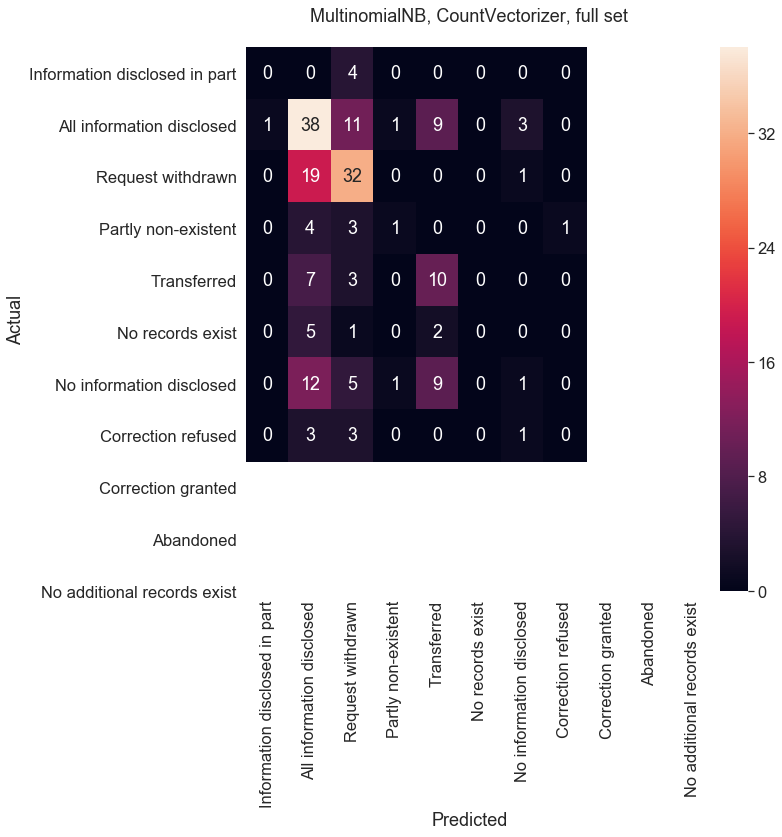

In [1491]:
count_conf_mat = confusion_matrix(y1_test, count_preds) 
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(count_conf_mat, annot=True, fmt='d',
            xticklabels=tokenized_adf['Decision'].unique(), yticklabels=tokenized_adf['Decision'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
ax.set(title='MultinomialNB, CountVectorizer, full set\n')
plt.show()


### tf-idf with LinearSVC - full set of decisions

In [1492]:
tfidf_pipe.fit(X1_train, y1_train)
tfidf_preds = tfidf_pipe.predict(X1_test)
print("Accuracy:", accuracy_score(y1_test, tfidf_preds))

Accuracy: 0.418848167539267


tf-idf with MultinomialNB gives about 42% accuracy, not better. Let's look at the confusion matrix.

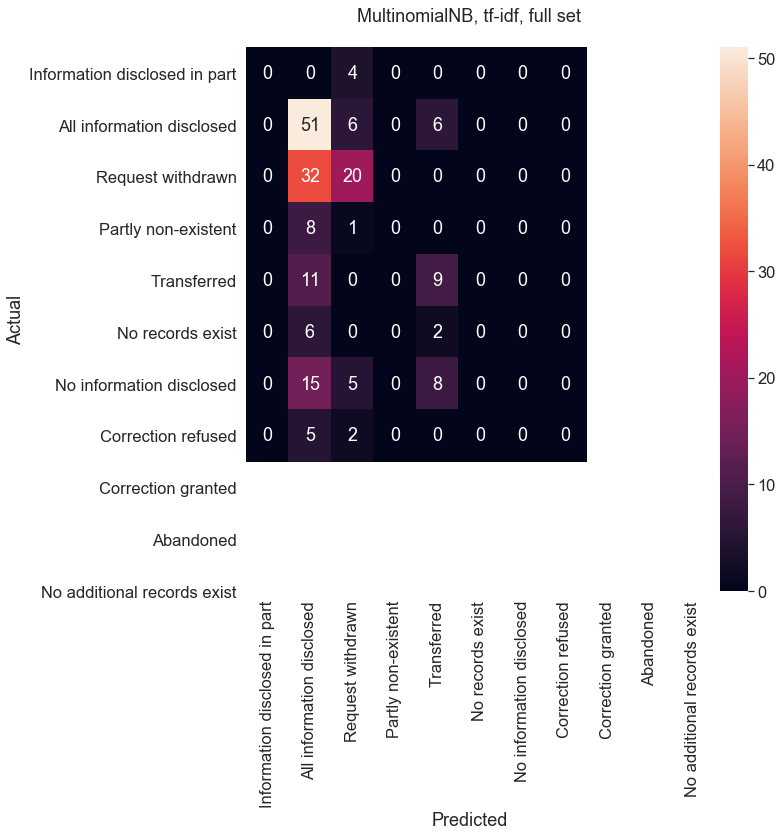

In [1493]:
tfidf_conf_mat = confusion_matrix(y1_test, tfidf_preds)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(tfidf_conf_mat, annot=True, fmt='d',
            xticklabels=tokenized_adf['Decision'].unique(), yticklabels=tokenized_adf['Decision'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
ax.set(title='MultinomialNB, tf-idf, full set\n')
plt.show()

By observing the matrix, we can see that it could not predict decisions that had few instances, like *'Correction granted'*, which has only once instance, since it was in the training set but not in the prediction set, or vice versa, but not both.

We decided to take 3 approaches to this:

a) Keep our set of decisions, except for the ones with less than 15 instances (just to keep *'Transferred'*.)

b) Binning all decisions into 3 basic categories, all, partial, or no information disclosed.

a) Remove cases with less than 15 cases and where a decision was not made, this, when the request was either *'Withdrawn'* or *'Abandoned'*. 


## a) Using Decisions with more than 15 instances

In [1494]:
print(tokenized_adf['Decision'].value_counts())

All information disclosed        189
Information disclosed in part    152
No records exist                  80
Request withdrawn                 80
Partly non-existent               23
No information disclosed          21
Transferred                       15
Abandoned                         13
No additional records exist        1
Correction refused                 1
Correction granted                 1
Name: Decision, dtype: int64


In [1495]:
tokenized_adf_over15 = tokenized_adf.groupby('Decision').filter(lambda x: len(x) >= 15)
print(tokenized_adf_over15['Decision'].value_counts())

All information disclosed        189
Information disclosed in part    152
No records exist                  80
Request withdrawn                 80
Partly non-existent               23
No information disclosed          21
Transferred                       15
Name: Decision, dtype: int64


### Model comparison

Now we will introduce a way to compare 8 classifiers at once, both numerically and visually. We start with CounterVectorizer, for both *balanced* and regular class weights, and then we will change our vectorizer to tf-idf.


In [1500]:
gb = []    # Setting up a array of dataframes to be put all the results together later on.

In [1501]:
count = CountVectorizer(min_df=3, ngram_range=(1, 4), tokenizer=tokenize_lemm_rmstop_Text)

features = count.fit_transform(tokenized_adf_over15['Edited_Summary'])
labels = tokenized_adf_over15['Decision']
features.shape

(560, 539)

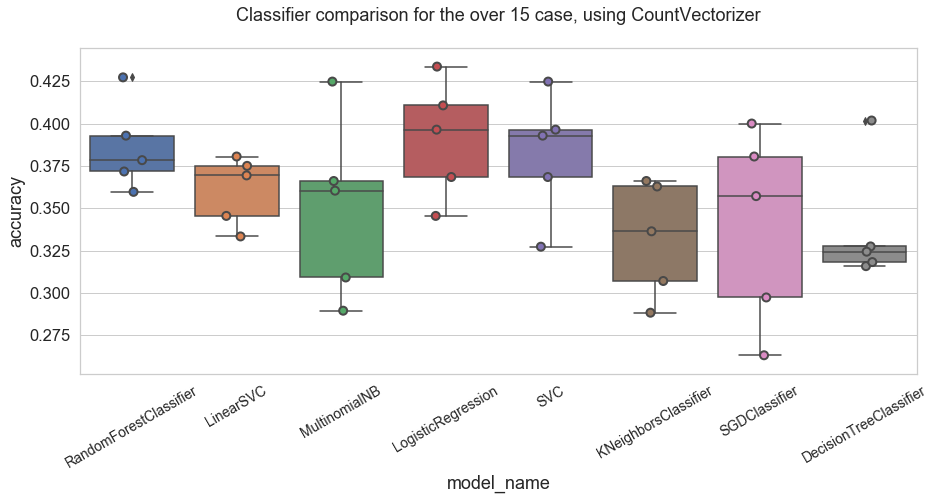

Acc., ov15, CVec
model_name                              
DecisionTreeClassifier          0.337503
KNeighborsClassifier            0.332115
LinearSVC                       0.360738
LogisticRegression              0.390923
MultinomialNB                   0.349955
RandomForestClassifier          0.385968
SGDClassifier                   0.339626
SVC                             0.381945

In [1502]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3,
                          random_state=42),
    LinearSVC(), 
    MultinomialNB(),
    LogisticRegression(random_state=42),
    SVC(gamma="scale"),
    KNeighborsClassifier(),
    SGDClassifier(loss='hinge', random_state=42, penalty='l2',
                  max_iter=5, tol=None),
    DecisionTreeClassifier()
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels,
                                 scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
             size=8, jitter=True, edgecolor="gray", linewidth=2)
ax.set(title='Classifier comparison for the over 15 case, using CountVectorizer\n')
plt.xticks(rotation=30, fontsize=14)
plt.show()

gb_df = cv_df.groupby('model_name').accuracy.mean()
gb_df = gb_df.to_frame()
gb_df.rename(index=str, columns={"accuracy": "Acc., ov15, CVec"}, inplace=True)
gb.append(gb_df)
gb_df

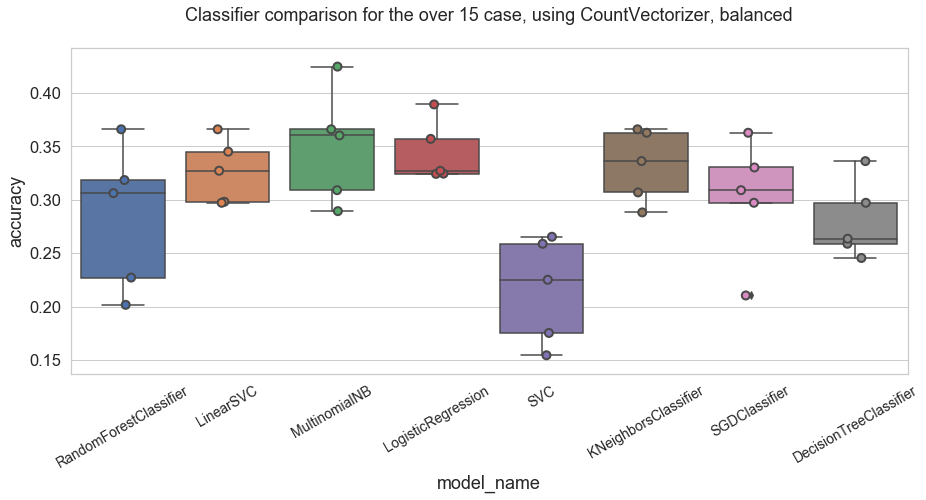

Acc., o15, CVec, bal.
model_name                                   
DecisionTreeClassifier               0.280352
KNeighborsClassifier                 0.332115
LinearSVC                            0.326804
LogisticRegression                   0.344536
MultinomialNB                        0.349955
RandomForestClassifier               0.283998
SGDClassifier                        0.302021
SVC                                  0.215925

In [1503]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3,
                          random_state=42, class_weight='balanced'),
    LinearSVC(class_weight='balanced'),
    MultinomialNB(),
    LogisticRegression(random_state=42, class_weight='balanced'),
    SVC(gamma="scale", class_weight='balanced'),
    KNeighborsClassifier(),
    SGDClassifier(loss='hinge', random_state=42, penalty='l2',
                  max_iter=5, tol=None, class_weight='balanced'),
    DecisionTreeClassifier(class_weight='balanced')
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels,
                                 scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
             size=8, jitter=True, edgecolor="gray", linewidth=2)
ax.set(title='Classifier comparison for the over 15 case, using CountVectorizer, balanced\n')
plt.xticks(rotation=30, fontsize=14)
plt.show()

gb_df = cv_df.groupby('model_name').accuracy.mean()
gb_df = gb_df.to_frame()
gb_df.rename(index=str, columns={"accuracy": "Acc., o15, CVec, bal."}, inplace=True)
gb.append(gb_df)
gb_df

In [1504]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=3, norm='l2',
                        ngram_range=(1, 4), tokenizer=tokenize_lemm_rmstop_Text)

features = tfidf.fit_transform(tokenized_adf_over15['Edited_Summary'])
labels = tokenized_adf_over15['Decision']
features.shape

(560, 539)

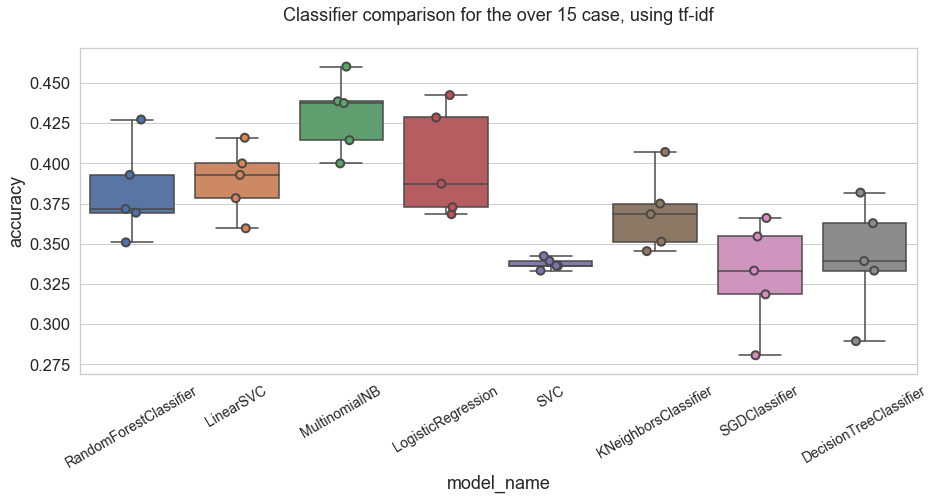

Acc., o15, tf-idf
model_name                               
DecisionTreeClassifier           0.341349
KNeighborsClassifier             0.369461
LinearSVC                        0.389363
LogisticRegression               0.399917
MultinomialNB                    0.430138
RandomForestClassifier           0.382412
SGDClassifier                    0.330647
SVC                              0.337522

In [1505]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3,
                          random_state=42),
    LinearSVC(), 
    MultinomialNB(),
    LogisticRegression(random_state=42),
    SVC(gamma="scale"),
    KNeighborsClassifier(),
    SGDClassifier(loss='hinge', random_state=42, penalty='l2',
                  max_iter=5, tol=None),
    DecisionTreeClassifier()
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels,
                                 scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
             size=8, jitter=True, edgecolor="gray", linewidth=2)
ax.set(title='Classifier comparison for the over 15 case, using tf-idf\n')
plt.xticks(rotation=30, fontsize=14)
plt.show()

gb_df = cv_df.groupby('model_name').accuracy.mean()
gb_df = gb_df.to_frame()
gb_df.rename(index=str, columns={"accuracy": "Acc., o15, tf-idf"}, inplace=True)
gb.append(gb_df)
gb_df


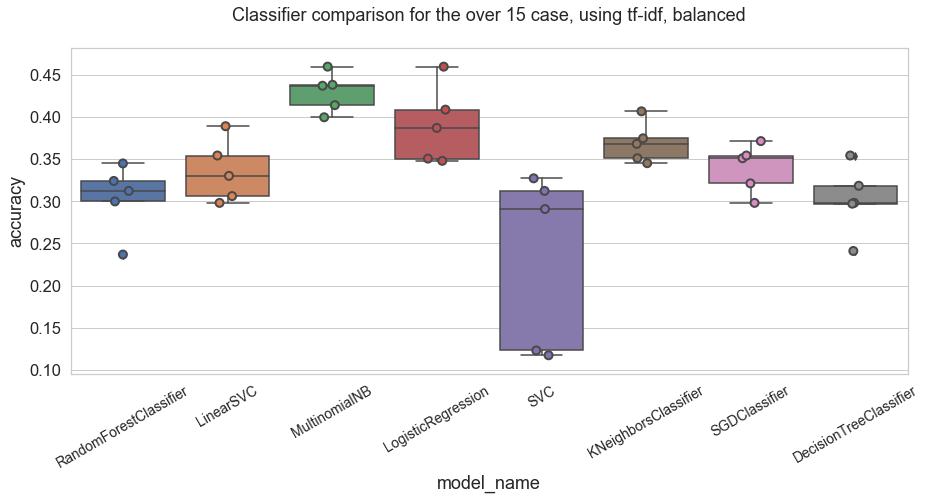

Accuracy, o15, tf-idf, bal.
model_name                                         
DecisionTreeClassifier                     0.301949
KNeighborsClassifier                       0.369461
LinearSVC                                  0.335767
LogisticRegression                         0.391149
MultinomialNB                              0.430138
RandomForestClassifier                     0.303760
SGDClassifier                              0.339450
SVC                                        0.234153

In [1506]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3,
                          random_state=42, class_weight='balanced'),
    LinearSVC(class_weight='balanced'),
    MultinomialNB(),
    LogisticRegression(random_state=42, class_weight='balanced'),
    SVC(gamma="scale", class_weight='balanced'),
    KNeighborsClassifier(),
    SGDClassifier(loss='hinge', random_state=42, penalty='l2',
                  max_iter=5, tol=None, class_weight='balanced'),
    DecisionTreeClassifier(class_weight='balanced')
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels,
                                 scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
             size=8, jitter=True, edgecolor="gray", linewidth=2)
ax.set(title='Classifier comparison for the over 15 case, using tf-idf, balanced\n')
plt.xticks(rotation=30, fontsize=14)
plt.show()

gb_df = cv_df.groupby('model_name').accuracy.mean()
gb_df = gb_df.to_frame()
gb_df.rename(index=str, columns={"accuracy": "Acc., o15, tf-idf, bal."}, inplace=True)
gb.append(gb_df)
gb_df

### Grid Search

MultinomialNB with tf-idf seems to do better. Therefore, we are going to show an example of the approach using GridSearch to find the best parameters for a classifier, in this case, for MultinomialNB, and the vectorizer. We will find the scores and the confusion matrix.


Setting our training and test sets.

In [1507]:
y_s_over15 = tokenized_adf_over15['Decision']

In [1508]:
X_s_over15 = tokenized_adf_over15['Edited_Summary']
X_s_over15_train, X_s_over15_test, y_s_over15_train, y_s_over15_test=train_test_split(X_s_over15, 
                                                y_s_over15, test_size=0.33, random_state=42)



Finding parameters.

In [1509]:
tfidf_vect = TfidfVectorizer()
parameters = {'vectorizer__ngram_range': [(1, 2), (1, 3), (1, 4)],
              'clf__alpha': (1, 1e-1, 1e-2, 1e-3)
             }
tfidf_clf = MultinomialNB()
tfidf_pipe = Pipeline([
    ('vectorizer', tfidf_vect),
    ('clf', tfidf_clf)
])
gs_clf = GridSearchCV(tfidf_pipe, parameters, cv=5, iid=False, n_jobs=-1)
gs_clf = gs_clf.fit(X_s_over15_train, y_s_over15_train)
print("Best score: ", gs_clf.best_score_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))


Best score:  0.4393272845875586
clf__alpha: 0.1
vectorizer__ngram_range: (1, 4)


Running our model with the parameters just found.

MultinomialNB Accuracy, tfidf, over 15 case: 0.43243243243243246


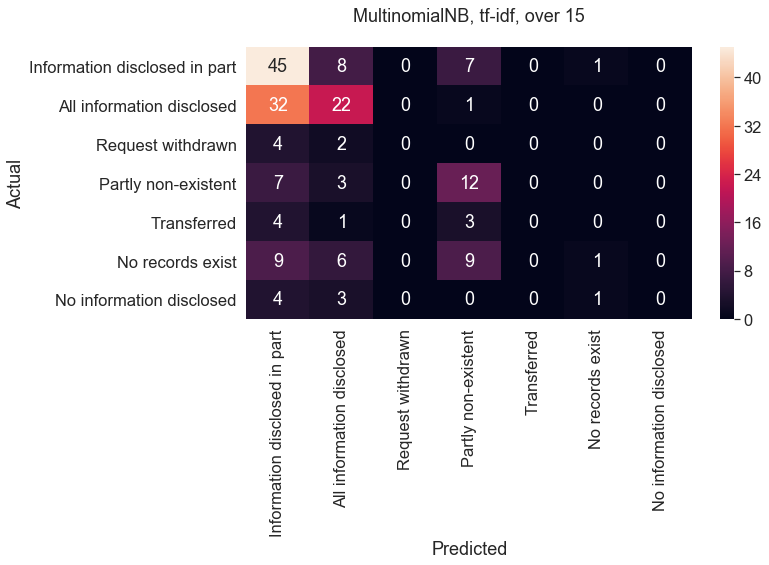

                               precision    recall  f1-score   support

Information disclosed in part       0.43      0.74      0.54        61
    All information disclosed       0.49      0.40      0.44        55
            Request withdrawn       0.00      0.00      0.00         6
          Partly non-existent       0.38      0.55      0.44        22
                  Transferred       0.00      0.00      0.00         8
             No records exist       0.33      0.04      0.07        25
     No information disclosed       0.00      0.00      0.00         8

                    micro avg       0.43      0.43      0.43       185
                    macro avg       0.23      0.25      0.21       185
                 weighted avg       0.38      0.43      0.37       185



In [1510]:
tfidf_vect = TfidfVectorizer(ngram_range=(1, 4))
tfidf_clf = MultinomialNB(alpha=0.1)

tfidf_pipe.fit(X_s_over15_train, y_s_over15_train)
tfidf_preds = tfidf_pipe.predict(X_s_over15_test)
print("MultinomialNB Accuracy, tfidf, over 15 case:", accuracy_score(y_s_over15_test, tfidf_preds))

tfidf_conf_mat = confusion_matrix(y_s_over15_test, tfidf_preds) 
fig, ax = plt.subplots(figsize=(10, 5))
label_names = tokenized_adf_over15['Decision'].unique()

sns.heatmap(tfidf_conf_mat, annot=True, fmt='d',
            xticklabels=label_names, 
            yticklabels=label_names)

plt.ylabel('Actual')
plt.xlabel('Predicted')
ax.set(title='MultinomialNB, tf-idf, over 15\n')
plt.show()
print(classification_report(y_s_over15_test, tfidf_preds,
                            target_names=tokenized_adf_over15['Decision'].unique()))

## b) Binning into 3 basic categories: all, partial, or no information disclosed

So, let's reduce the categories to three: all, partial, and no information disclosed. We'll bin them according to:

- All information disclosed (plus 'Correction granted')

- Information disclosed in part (plus 'Partly non-existent')

- No information disclosed (plus 'Transferred', 'No records exist', 'Correction refused', 'No additional records exist', 'Withdrawn', and 'Abandoned')

We will do this by adding a new column to our array, *'Sub_Decision'*.

In [1511]:
tokenized_adf.head(4)

Request_Number Request_Type      Source  \
0           99001      General    Business   
1           99002      General    Business   
2           99003      General    Business   
3           99004      General  Individual   

                                  Summary_of_Request  \
0  Minutes of Service Delivery Subcommittee of ES...   
1  Public Health inspection reports for the {loca...   
2  Public Health inspection records for {location...   
3  Public Health inspection records for {address ...   

                        Decision  \
0  Information disclosed in part   
1      All information disclosed   
2  Information disclosed in part   
3      All information disclosed   

                                      Edited_Summary  \
0  minutes service delivery subcommittee escac pe...   
1  public health inspection report kitchener past...   
2  public health inspection record cambridge past...   
3  public health inspection record cambridge rela...   

                    Sub_Decision  
0  Information disclosed in part  
1      All information disclosed  
2  Information disclosed in part  
3      All information disclosed

In [1512]:
tokenized_adf['Sub_Decision'] = tokenized_adf['Decision']

In [1513]:
tokenized_adf.head(4)

Request_Number Request_Type      Source  \
0           99001      General    Business   
1           99002      General    Business   
2           99003      General    Business   
3           99004      General  Individual   

                                  Summary_of_Request  \
0  Minutes of Service Delivery Subcommittee of ES...   
1  Public Health inspection reports for the {loca...   
2  Public Health inspection records for {location...   
3  Public Health inspection records for {address ...   

                        Decision  \
0  Information disclosed in part   
1      All information disclosed   
2  Information disclosed in part   
3      All information disclosed   

                                      Edited_Summary  \
0  minutes service delivery subcommittee escac pe...   
1  public health inspection report kitchener past...   
2  public health inspection record cambridge past...   
3  public health inspection record cambridge rela...   

                    Sub_Decision  
0  Information disclosed in part  
1      All information disclosed  
2  Information disclosed in part  
3      All information disclosed

Replacing our decisions for a generic version.

In [1514]:
pos_dec = {'Correction granted'}
part_dec = {'Partly non-existent'}
neg_dec = {'Request withdrawn', 'Transferred', 'No records exist', 'Correction refused', 'Abandoned', 
           'No additional records exist'}

In [1515]:
for pos in pos_dec:
    tokenized_adf['Sub_Decision'] = tokenized_adf['Sub_Decision'].str.replace(
                                    pos,'All information disclosed')

In [1516]:
for part in part_dec:
    tokenized_adf['Sub_Decision'] = tokenized_adf['Sub_Decision'].str.replace(
                                    part,'Information disclosed in part')

In [1517]:
for neg in neg_dec:
    tokenized_adf['Sub_Decision'] = tokenized_adf['Sub_Decision'].str.replace(
                                    neg,'No information disclosed')

In [1518]:
tokenized_adf.head(11)

Request_Number Request_Type      Source  \
0            99001      General    Business   
1            99002      General    Business   
2            99003      General    Business   
3            99004      General  Individual   
4            99005      General    Business   
5            99006     Personal  Individual   
6            99007      General  Individual   
7            99008      General  Individual   
8            99009     Personal  Individual   
9            99010      General    Business   
10           99011      General    Business   

                                   Summary_of_Request  \
0   Minutes of Service Delivery Subcommittee of ES...   
1   Public Health inspection reports for the {loca...   
2   Public Health inspection records for {location...   
3   Public Health inspection records for {address ...   
4   Vendor list report with total of year-to-date ...   
5   Public Health inspection file for {name remove...   
6   Scope of work and deliverables sections of con...   
7   Number of contracts and dollar amount of contr...   
8   Public Health inspection report regarding a co...   
9   Phase I environmental site assessment regardin...   
10  Complete fiscal year end vendor report for yea...   

                         Decision  \
0   Information disclosed in part   
1       All information disclosed   
2   Information disclosed in part   
3       All information disclosed   
4       All information disclosed   
5       All information disclosed   
6       All information disclosed   
7               Request withdrawn   
8       All information disclosed   
9               Request withdrawn   
10            Partly non-existent   

                                       Edited_Summary  \
0   minutes service delivery subcommittee escac pe...   
1   public health inspection report kitchener past...   
2   public health inspection record cambridge past...   
3   public health inspection record cambridge rela...   
4   vendor list report total year date purchase fi...   
5   public health inspection file regard requester...   
6   scope work deliverable section contract region...   
7   number contract dollar contract region waterlo...   
8   public health inspection report regard complai...   
9    phase environmental site assessment regard sewer   
10  complete fiscal year vendor report year 1996 1...   

                     Sub_Decision  
0   Information disclosed in part  
1       All information disclosed  
2   Information disclosed in part  
3       All information disclosed  
4       All information disclosed  
5       All information disclosed  
6       All information disclosed  
7        No information disclosed  
8       All information disclosed  
9        No information disclosed  
10  Information disclosed in part

In [1519]:
tokenized_adf['Sub_Decision'].unique()

array(['Information disclosed in part', 'All information disclosed',
       'No information disclosed'], dtype=object)

In [1520]:
tokenized_adf.Sub_Decision.value_counts()

No information disclosed         211
All information disclosed        190
Information disclosed in part    175
Name: Sub_Decision, dtype: int64

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

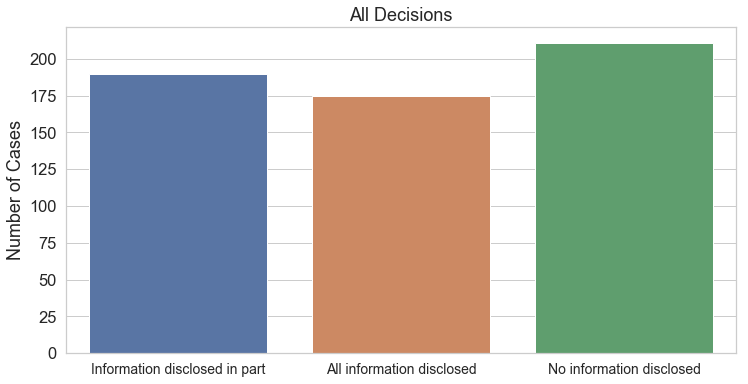

In [1521]:
columns_sub = []
for i in range(0,tokenized_adf.Sub_Decision.nunique()):
    columns_sub.append(tokenized_adf.Sub_Decision.unique()[i])

tokenized_adf_groupbySubDecision = tokenized_adf.groupby('Sub_Decision').count()[['Source']]

fig, ax = plt.subplots(figsize=(12, 6))
sns.set(style="whitegrid", font_scale=1.5)
ax = sns.barplot(x=columns_sub, y='Source', data=tokenized_adf_groupbySubDecision)
ax.set(ylabel='Number of Cases', title='All Decisions')
plt.xticks(rotation=0, fontsize=14)

And now our set seems more balanced.

### Model comparison, 3-bin case

Let's compare eight different classifiers with two vectorizers, CountVectorizer and tf-idf.

In [1522]:
count = CountVectorizer(min_df=3, ngram_range=(1, 4), tokenizer=tokenize_lemm_rmstop_Text)

features = count.fit_transform(tokenized_adf['Edited_Summary'])
labels = tokenized_adf['Sub_Decision']
features.shape

(576, 564)

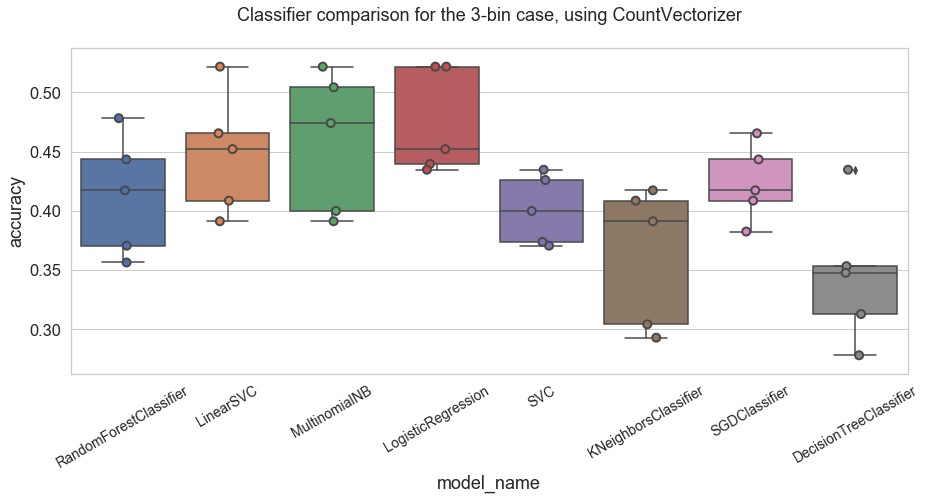

Acc., 3b, CVec
model_name                            
DecisionTreeClassifier        0.345472
KNeighborsClassifier          0.362969
LinearSVC                     0.447886
LogisticRegression            0.474018
MultinomialNB                 0.458306
RandomForestClassifier        0.413268
SGDClassifier                 0.423538
SVC                           0.401094

In [1523]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3,
                          random_state=42), #, class_weight = 'balanced'),
    LinearSVC(), #class_weight='balanced'),
    MultinomialNB(),
    LogisticRegression(random_state=42),#, class_weight = 'balanced'),
    SVC(gamma="scale"),
    KNeighborsClassifier(),
    SGDClassifier(loss='hinge', random_state=42, penalty='l2',
                          max_iter=5, tol=None),
    DecisionTreeClassifier()
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels,
                                 scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
             size=8, jitter=True, edgecolor="gray", linewidth=2)
ax.set(title='Classifier comparison for the 3-bin case, using CountVectorizer\n')
plt.xticks(rotation=30, fontsize=14)
plt.show()

gb_df = cv_df.groupby('model_name').accuracy.mean()
gb_df = gb_df.to_frame()
gb_df.rename(index=str, columns={"accuracy": "Acc., 3b, CVec"}, inplace=True)
gb.append(gb_df)
gb_df


In [1524]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=3, norm='l2',
                        ngram_range=(1, 4), tokenizer=tokenize_lemm_rmstop_Text)

features = tfidf.fit_transform(tokenized_adf['Edited_Summary'])
labels = tokenized_adf['Sub_Decision']
features.shape

(576, 564)

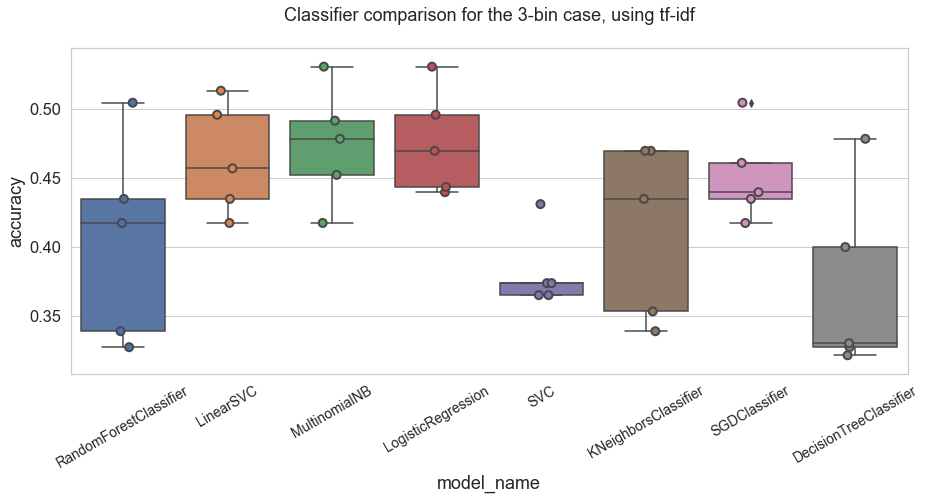

Acc., 3b, tf-idf
model_name                              
DecisionTreeClassifier          0.371604
KNeighborsClassifier            0.413298
LinearSVC                       0.463553
LogisticRegression              0.475757
MultinomialNB                   0.473928
RandomForestClassifier          0.404648
SGDClassifier                   0.451409
SVC                             0.381859

In [1525]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3,
                          random_state=42),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=42),
    SVC(gamma="scale"),
    KNeighborsClassifier(),
    SGDClassifier(loss='hinge', random_state=42, penalty='l2',
                          max_iter=5, tol=None),
    DecisionTreeClassifier()
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels,
                                 scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
             size=8, jitter=True, edgecolor="gray", linewidth=2)
ax.set(title='Classifier comparison for the 3-bin case, using tf-idf\n')
plt.xticks(rotation=30, fontsize=14)
plt.show()

gb_df = cv_df.groupby('model_name').accuracy.mean()
gb_df = gb_df.to_frame()
gb_df.rename(index=str, columns={"accuracy": "Acc., 3b, tf-idf"}, inplace=True)
gb.append(gb_df)
gb_df




It seems like LogisticRegression with tf-idf does slightly better this time. Let's find the best parameters and take a look at the confusion matrix and the scores.

In [1526]:
y_s = tokenized_adf['Sub_Decision']

In [1527]:
X_s = tokenized_adf['Edited_Summary']
X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_s, y_s, test_size=0.33, random_state=42)

In [1528]:
len(X_s_train), len (y_s_train)

(385, 385)

In [1529]:
X_s_train.sample(5)

169    ambulance report emergency medical services 20...
170    signal time summary 2003/10/27 regard motor ve...
316    records relate sidewalk repair inspection comp...
183       phase environmental site assessment heidelberg
27     correspondence 1996 1997 regard shades water t...
Name: Edited_Summary, dtype: object

### GridSearch for LogisticRegression - tf-idf

Finding parameters.

In [1530]:
# tf-idf
tfidf_vect = TfidfVectorizer()
tfidf_clf = LogisticRegression()
tfidf_pipe = Pipeline([
    ('vectorizer', tfidf_vect),
    ('clf', tfidf_clf)
])

parameters = {'vectorizer__ngram_range': [(1, 2), (1, 3), (1, 4)],
              'clf__penalty' : ['l1', 'l2'],
              'clf__C' : np.logspace(-4, 4, 20),
              'clf__solver' : ['liblinear']
             }

gs_clf = GridSearchCV(tfidf_pipe, parameters, cv=5)
gs_clf = gs_clf.fit(X_s_train, y_s_train)
print("For MultinomialNB Classifier with tf-idf:\n")
print("Best score: ", gs_clf.best_score_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))


For MultinomialNB Classifier with tf-idf:

Best score:  0.5142857142857142
clf__C: 78.47599703514607
clf__penalty: 'l2'
clf__solver: 'liblinear'
vectorizer__ngram_range: (1, 4)


Running our model with the parameters just found.

In [1531]:
tfidf_vect = TfidfVectorizer(ngram_range=(1, 4))
tfidf_clf = LogisticRegression(C=78, penalty='l2', solver='liblinear')
tfidf_pipe.fit(X_s_train, y_s_train)
tfidf_preds = tfidf_pipe.predict(X_s_test)
print("LogisticRegression Accuracy - tfidf - 3 bins:", accuracy_score(y_s_test, tfidf_preds))

LogisticRegression Accuracy - tfidf - 3 bins: 0.44502617801047123


Finding confusion matrix and report.

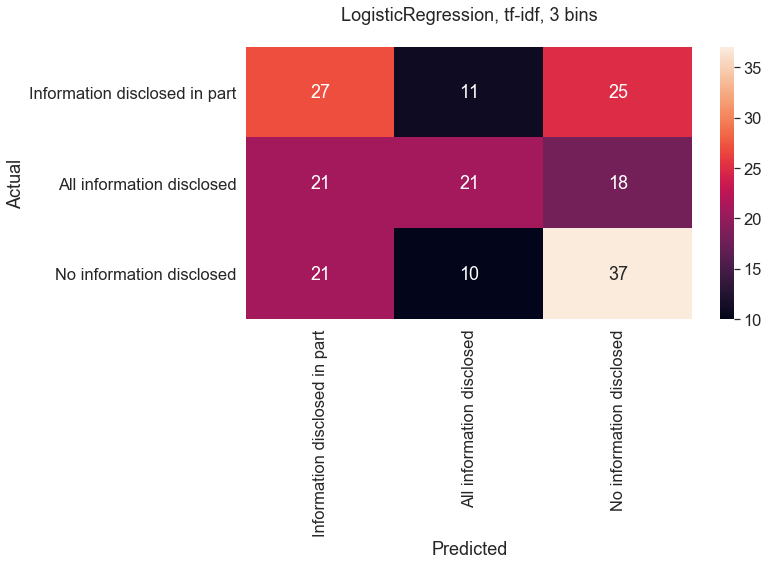

                               precision    recall  f1-score   support

Information disclosed in part       0.39      0.43      0.41        63
    All information disclosed       0.50      0.35      0.41        60
     No information disclosed       0.46      0.54      0.50        68

                    micro avg       0.45      0.45      0.45       191
                    macro avg       0.45      0.44      0.44       191
                 weighted avg       0.45      0.45      0.44       191



In [1532]:
tfidf_conf_mat = confusion_matrix(y_s_test, tfidf_preds) 
fig, ax = plt.subplots(figsize=(10, 5))
label_names = tokenized_adf['Sub_Decision'].unique()

sns.heatmap(tfidf_conf_mat, annot=True, fmt='d',
            xticklabels=label_names, 
            yticklabels=label_names)

plt.ylabel('Actual')
plt.xlabel('Predicted')
ax.set(title='LogisticRegression, tf-idf, 3 bins\n')
plt.show()
print(classification_report(y_s_test, tfidf_preds,
                            target_names=tokenized_adf['Sub_Decision'].unique()))

## c) Removing cases with less than 15 cases and where a decision was not made

Let's call this dataframe 'independent'. Removing *'Withdrawn'* or *'Abandoned'* leaves us with 483 out of 576 total requests.

In [1533]:
tokenized_adf_indep = tokenized_adf_over15.copy()

In [1534]:
tokenized_adf_indep = tokenized_adf_indep[tokenized_adf_indep.Decision != 'Request withdrawn']

In [1535]:
tokenized_adf_indep = tokenized_adf_indep[tokenized_adf_indep.Decision != 'Abandoned']

In [1536]:
print(tokenized_adf_indep['Decision'].value_counts())

All information disclosed        189
Information disclosed in part    152
No records exist                  80
Partly non-existent               23
No information disclosed          21
Transferred                       15
Name: Decision, dtype: int64


In [1537]:
len(tokenized_adf_indep)

480

In [1538]:
len(tokenized_adf)

576

In [1539]:
count = CountVectorizer(min_df=3, ngram_range=(1, 4), tokenizer=tokenize_lemm_rmstop_Text)

features = count.fit_transform(tokenized_adf_indep['Edited_Summary'])
labels = tokenized_adf_indep['Decision']
features.shape

(480, 470)

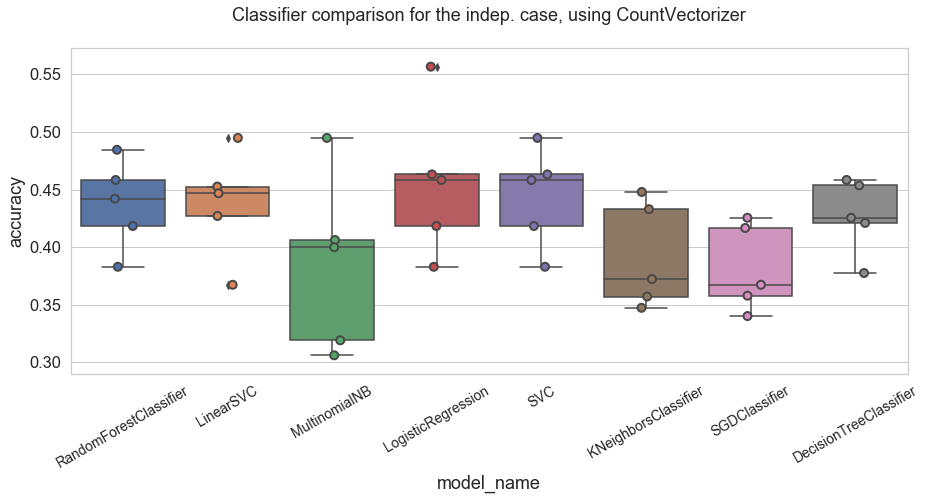

Acc., Ind., CVec
model_name                              
DecisionTreeClassifier          0.427215
KNeighborsClassifier            0.391552
LinearSVC                       0.437743
LogisticRegression              0.455908
MultinomialNB                   0.385273
RandomForestClassifier          0.437264
SGDClassifier                   0.381529
SVC                             0.443537

In [1540]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3,
                          random_state=42),
    LinearSVC(), 
    MultinomialNB(),
    LogisticRegression(random_state=42),
    SVC(gamma="scale"),
    KNeighborsClassifier(),
    SGDClassifier(loss='hinge', random_state=42, penalty='l2',
                          max_iter=5, tol=None),
    DecisionTreeClassifier()
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels,
                                 scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
             size=8, jitter=True, edgecolor="gray", linewidth=2)
ax.set(title='Classifier comparison for the indep. case, using CountVectorizer\n')
plt.xticks(rotation=30, fontsize=14)
plt.show()

gb_df = cv_df.groupby('model_name').accuracy.mean()
gb_df = gb_df.to_frame()
gb_df.rename(index=str, columns={"accuracy": "Acc., Ind., CVec"}, inplace=True)
gb.append(gb_df)
gb_df


In [1541]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=3, norm='l2',
                        ngram_range=(1, 4), tokenizer=tokenize_lemm_rmstop_Text)

features = tfidf.fit_transform(tokenized_adf_indep['Edited_Summary'])
labels = tokenized_adf_indep['Decision']
features.shape

(480, 470)

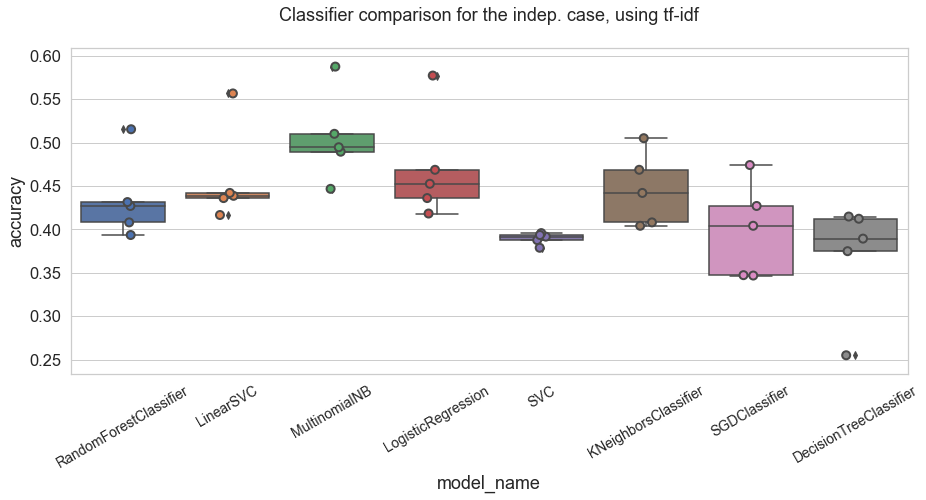

Acc., Ind., tf-idf
model_name                                
DecisionTreeClassifier            0.369368
KNeighborsClassifier              0.445686
LinearSVC                         0.458084
LogisticRegression                0.470648
MultinomialNB                     0.505792
RandomForestClassifier            0.435181
SGDClassifier                     0.399975
SVC                               0.389581

In [1542]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3,
                          random_state=42),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=42),
    SVC(gamma="scale"),
    KNeighborsClassifier(),
    SGDClassifier(loss='hinge', random_state=42, penalty='l2',
                          max_iter=5, tol=None),
    DecisionTreeClassifier()
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels,
                                 scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
             size=8, jitter=True, edgecolor="gray", linewidth=2)
ax.set(title='Classifier comparison for the indep. case, using tf-idf\n')
plt.xticks(rotation=30, fontsize=14)
plt.show()

gb_df = cv_df.groupby('model_name').accuracy.mean()
gb_df = gb_df.to_frame()
gb_df.rename(index=str, columns={"accuracy": "Acc., Ind., tf-idf"}, inplace=True)
gb.append(gb_df)
gb_df




It seems like MultinomialNB with tf-idf does better this time. Let's find the best parameters and take a look at the confusion matrix and the scores.

### GridSearch for MultinomialNB - tf-idf

Finding parameters.

In [1543]:
y_i = tokenized_adf_indep['Decision']

In [1544]:
X2 = tokenized_adf_indep['Edited_Summary']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y_i, test_size=0.33, random_state=42)

In [1545]:
# tf-idf
tfidf_vect = TfidfVectorizer()
tfidf_clf = MultinomialNB()
tfidf_pipe = Pipeline([
    ('vectorizer', tfidf_vect),
    ('clf', tfidf_clf)
])

parameters = {'vectorizer__ngram_range': [(1, 2), (1, 3), (1, 4)],
              'clf__alpha': (1, 1e-1, 1e-2, 1e-3)
             }

gs_clf = GridSearchCV(tfidf_pipe, parameters, cv=5)
gs_clf = gs_clf.fit(X2_train, y2_train)
print("For MultinomialNB Classifier with tf-idf:\n")
print("Best score: ", gs_clf.best_score_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))


For MultinomialNB Classifier with tf-idf:

Best score:  0.4766355140186916
clf__alpha: 0.1
vectorizer__ngram_range: (1, 4)


Running our model with the parameters just found.

In [1546]:
tfidf_vect = TfidfVectorizer(ngram_range=(1, 4))
tfidf_clf = MultinomialNB(alpha=0.1)
tfidf_pipe.fit(X2_train, y2_train)
tfidf_preds = tfidf_pipe.predict(X2_test)
print("MultinomialNB Accuracy - tfidf - indep:", accuracy_score(y2_test, tfidf_preds))

MultinomialNB Accuracy - tfidf - indep: 0.49056603773584906


Finding confusion matrix and report.

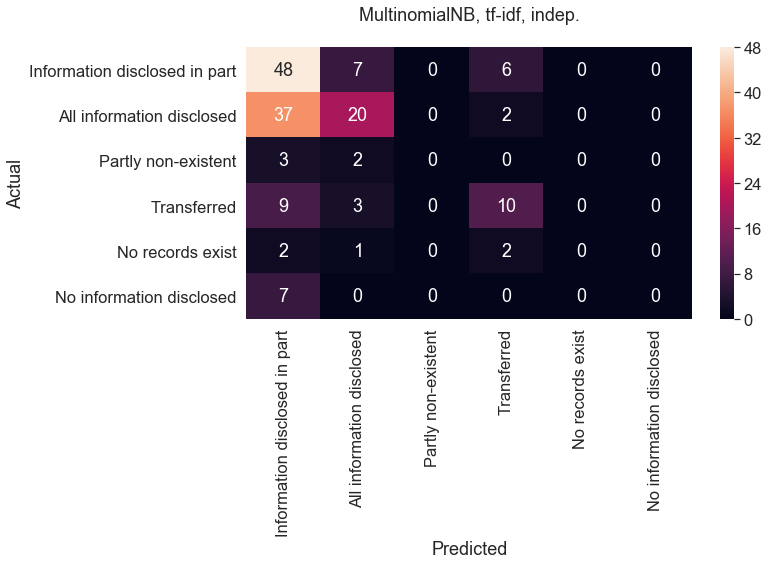

                               precision    recall  f1-score   support

Information disclosed in part       0.45      0.79      0.57        61
    All information disclosed       0.61      0.34      0.43        59
          Partly non-existent       0.00      0.00      0.00         5
                  Transferred       0.50      0.45      0.48        22
             No records exist       0.00      0.00      0.00         5
     No information disclosed       0.00      0.00      0.00         7

                    micro avg       0.49      0.49      0.49       159
                    macro avg       0.26      0.26      0.25       159
                 weighted avg       0.47      0.49      0.45       159



In [1547]:
tfidf_conf_mat = confusion_matrix(y2_test, tfidf_preds) 
fig, ax = plt.subplots(figsize=(10, 5))
label_names = tokenized_adf_indep['Decision'].unique()

sns.heatmap(tfidf_conf_mat, annot=True, fmt='d',
            xticklabels=label_names, 
            yticklabels=label_names)

plt.ylabel('Actual')
plt.xlabel('Predicted')
ax.set(title='MultinomialNB, tf-idf, indep.\n')
plt.show()
print(classification_report(y2_test, tfidf_preds,
                            target_names=tokenized_adf_indep['Decision'].unique()))

And putting all the accuracy scores together, and giving it some *Style* to make the results clearer.

In [1549]:
gb_all = pd.DataFrame()

In [1550]:
gb_all = pd.concat(gb, axis=1)

In [1564]:
gb_all

Acc., ov15, CVec  Acc., o15, CVec, bal.  \
model_name                                                        
DecisionTreeClassifier          0.337503               0.280352   
KNeighborsClassifier            0.332115               0.332115   
LinearSVC                       0.360738               0.326804   
LogisticRegression              0.390923               0.344536   
MultinomialNB                   0.349955               0.349955   
RandomForestClassifier          0.385968               0.283998   
SGDClassifier                   0.339626               0.302021   
SVC                             0.381945               0.215925   

                        Acc., o15, tf-idf  Acc., o15, tf-idf, bal.  \
model_name                                                           
DecisionTreeClassifier           0.341349                 0.301949   
KNeighborsClassifier             0.369461                 0.369461   
LinearSVC                        0.389363                 0.335767   
LogisticRegression               0.399917                 0.391149   
MultinomialNB                    0.430138                 0.430138   
RandomForestClassifier           0.382412                 0.303760   
SGDClassifier                    0.330647                 0.339450   
SVC                              0.337522                 0.234153   

                        Acc., 3b, CVec  Acc., 3b, tf-idf  Acc., Ind., CVec  \
model_name                                                                   
DecisionTreeClassifier        0.345472          0.371604          0.427215   
KNeighborsClassifier          0.362969          0.413298          0.391552   
LinearSVC                     0.447886          0.463553          0.437743   
LogisticRegression            0.474018          0.475757          0.455908   
MultinomialNB                 0.458306          0.473928          0.385273   
RandomForestClassifier        0.413268          0.404648          0.437264   
SGDClassifier                 0.423538          0.451409          0.381529   
SVC                           0.401094          0.381859          0.443537   

                        Acc., Ind., tf-idf  
model_name                                  
DecisionTreeClassifier            0.369368  
KNeighborsClassifier              0.445686  
LinearSVC                         0.458084  
LogisticRegression                0.470648  
MultinomialNB                     0.505792  
RandomForestClassifier            0.435181  
SGDClassifier                     0.399975  
SVC                               0.389581

Adding some functions that will *style* and color the dataframe.

In [1553]:
def color_above45_green(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: green'` for above 0.45
    strings, black otherwise.
    """
    color = 'green' if val > 0.45 else 'black'
    return 'color: %s' % color

In [1555]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [1570]:
caption = 'Accuracy score for all the eight models, and 3 different cases\
         (ov15: over 15 requests, 3b: All decisions split into three bins, Ind.: over 15 and w/o Withdrawns and \
         Abandoned.) We also considered two different vectorizers, CountVectorizer (CVec) and tf-idf. Highest score per\
         case is highlighted in yellow. Scores above 45% are shown in green.'
s = gb_all.style.\
    applymap(color_above45_green).\
    apply(highlight_max).\
    set_caption(caption)
s

__We see that even though our results are not good (50% is the highest!), in general, for this case, Logistic Regression and Multinomial Naive Bayes classifiers, combined with tf-idf, worked best, as well as reducing the number of 'Decisions'.__